In [1]:
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import shap
import scipy.stats as stats
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import ADASYN, SMOTE
from sklearn.base import clone
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold, StratifiedShuffleSplit, cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Import DataSet

In [3]:
df_player = pd.read_csv('merged.csv')

In [4]:
df_player.head()

PLAYER_ID    PLAYER_NAME SEASON  SEASON_NUM   AGE PLAYER_HEIGHT_INCHES  \
0    1630639    A.J. Lawson  22-23        22.5  22.0                   78   
1    1631260       AJ Green  22-23        22.5  23.0                   77   
2    1631100     AJ Griffin  22-23        22.5  19.0                   78   
3     203932   Aaron Gordon  22-23        22.5  27.0                   80   
4    1628988  Aaron Holiday  22-23        22.5  26.0                   72   

  PLAYER_WEIGHT  GP   MIN  USG_PCT  ...  AVG_SEC_PER_TOUCH  \
0           179  13   4.8    0.182  ...               1.39   
1           190  32   9.4    0.160  ...               2.61   
2           220  66  19.4    0.174  ...               2.08   
3           235  61  30.1    0.206  ...               2.94   
4           185  57  13.7    0.128  ...               4.17   

   AVG_DRIB_PER_TOUCH  ELBOW_TOUCHES  POST_TOUCHES  PAINT_TOUCHES     TEAM  \
0                0.62            0.0           0.0            0.2      NaN   
1                1.84            0.1           0.0            0.3      NaN   
2                1.49            0.4           0.0            0.7      NaN   
3                2.11            1.8           2.1            6.8  Nuggets   
4                3.82            0.1           0.0            0.4      NaN   

   INJURED ON    RETURNED  DAYS MISSED    INJURED_TYPE  
0         NaN         NaN          NaN             NaN  
1         NaN         NaN          NaN             NaN  
2         NaN         NaN          NaN             NaN  
3  2023-02-02  2023-02-07          5.0  Sprained_ankle  
4         NaN         NaN          NaN             NaN  

[5 rows x 32 columns]

In [5]:
df_player.describe(include='all')

PLAYER_ID   PLAYER_NAME SEASON   SEASON_NUM          AGE  \
count   5.578000e+03          5578   5578  5578.000000  5578.000000   
unique           NaN          1389     10          NaN          NaN   
top              NaN  Kemba Walker  21-22          NaN          NaN   
freq             NaN            25    702          NaN          NaN   
mean    7.789375e+05           NaN    NaN    18.241484    26.533883   
std     7.189302e+05           NaN    NaN     2.829290     4.253617   
min     7.080000e+02           NaN    NaN    13.500000    19.000000   
25%     2.021300e+05           NaN    NaN    15.500000    23.000000   
50%     2.035840e+05           NaN    NaN    18.500000    26.000000   
75%     1.628399e+06           NaN    NaN    20.500000    29.000000   
max     1.641645e+06           NaN    NaN    22.500000    43.000000   

       PLAYER_HEIGHT_INCHES PLAYER_WEIGHT           GP          MIN  \
count                  5578          5578  5578.000000  5578.000000   
unique                   42           219          NaN          NaN   
top                      81           220          NaN          NaN   
freq                    542           284          NaN          NaN   
mean                    NaN           NaN    48.663858    20.101040   
std                     NaN           NaN    24.404703     9.422618   
min                     NaN           NaN     1.000000     0.500000   
25%                     NaN           NaN    30.000000    12.700000   
50%                     NaN           NaN    55.000000    19.800000   
75%                     NaN           NaN    69.000000    28.200000   
max                     NaN           NaN    83.000000    43.500000   

            USG_PCT  ...  AVG_SEC_PER_TOUCH  AVG_DRIB_PER_TOUCH  \
count   5578.000000  ...        5578.000000         5578.000000   
unique          NaN  ...                NaN                 NaN   
top             NaN  ...                NaN                 NaN   
freq            NaN  ...                NaN                 NaN   
mean       0.182185  ...           2.692180            1.879871   
std        0.056190  ...           1.294775            1.579300   
min        0.000000  ...           0.000000            0.000000   
25%        0.144000  ...           1.660000            0.580000   
50%        0.175000  ...           2.160000            1.250000   
75%        0.215000  ...           3.660000            3.030000   
max        0.571000  ...           7.590000            8.270000   

        ELBOW_TOUCHES  POST_TOUCHES  PAINT_TOUCHES    TEAM  INJURED ON  \
count     5578.000000   5578.000000    5578.000000    1214        1214   
unique            NaN           NaN            NaN      30         756   
top               NaN           NaN            NaN  Knicks  2022-04-10   
freq              NaN           NaN            NaN      70           9   
mean         1.096307      0.862370       1.972732     NaN         NaN   
std          1.370064      1.775437       2.168288     NaN         NaN   
min          0.000000      0.000000       0.000000     NaN         NaN   
25%          0.300000      0.000000       0.500000     NaN         NaN   
50%          0.600000      0.100000       1.100000     NaN         NaN   
75%          1.400000      0.900000       2.600000     NaN         NaN   
max         15.200000     19.800000      13.900000     NaN         NaN   

          RETURNED  DAYS MISSED    INJURED_TYPE  
count         1214  1214.000000            1214  
unique         736          NaN               5  
top     2020-08-12          NaN  Sprained_ankle  
freq             7          NaN             588  
mean           NaN     8.752059             NaN  
std            NaN    18.313393             NaN  
min            NaN     1.000000             NaN  
25%            NaN     2.000000             NaN  
50%            NaN     4.000000             NaN  
75%            NaN     8.000000             NaN  
max            NaN   282.000000             NaN  

[11 rows x

To eliminate redundancy, I remove duplicate records for players who experience the same type of injury multiple times within a season

In [6]:
df_player[df_player.duplicated(subset=['PLAYER_ID', 'SEASON', 'INJURED_TYPE'], keep=False)]

PLAYER_ID    PLAYER_NAME SEASON  SEASON_NUM   AGE PLAYER_HEIGHT_INCHES  \
193     1629630      Ja Morant  22-23        22.5  23.0                   74   
194     1629630      Ja Morant  22-23        22.5  23.0                   74   
231     1629750  Javonte Green  22-23        22.5  29.0                   77   
232     1629750  Javonte Green  22-23        22.5  29.0                   77   
255      202322      John Wall  22-23        22.5  32.0                   75   
...         ...            ...    ...         ...   ...                  ...   
5042     201959     Taj Gibson  14-15        14.5  30.0                   81   
5055     202699  Tobias Harris  14-15        14.5  22.0                   81   
5056     202699  Tobias Harris  14-15        14.5  22.0                   81   
5556     203092   Tyler Zeller  13-14        13.5  24.0                   84   
5557     203092   Tyler Zeller  13-14        13.5  24.0                   84   

     PLAYER_WEIGHT  GP   MIN  USG_PCT  ...  AVG_SEC_PER_TOUCH  \
193            174  55  32.1    0.341  ...               5.90   
194            174  55  32.1    0.341  ...               5.90   
231            205  30  15.5    0.129  ...               1.24   
232            205  30  15.5    0.129  ...               1.24   
255            210  34  22.2    0.259  ...               5.58   
...            ...  ..   ...      ...  ...                ...   
5042           225  62  27.3    0.175  ...               1.68   
5055           235  68  34.8    0.222  ...               2.29   
5056           235  68  34.8    0.222  ...               2.29   
5556           253  70  15.0    0.168  ...               1.42   
5557           253  70  15.0    0.168  ...               1.42   

      AVG_DRIB_PER_TOUCH  ELBOW_TOUCHES  POST_TOUCHES  PAINT_TOUCHES  \
193                 5.13            0.5           0.1            1.5   
194                 5.13            0.5           0.1            1.5   
231                 0.44            0.5           0.0            1.7   
232                 0.44            0.5           0.0            1.7   
255                 4.98            0.2           0.4            0.2   
...                  ...            ...           ...            ...   
5042                0.68            2.8           4.5            7.6   
5055                1.28            1.4           2.7            2.9   
5056                1.28            1.4           2.7            2.9   
5556                0.30            1.7           0.6            3.3   
5557                0.30            1.7           0.6            3.3   

           TEAM  INJURED ON    RETURNED  DAYS MISSED    INJURED_TYPE  
193   Grizzlies  2023-01-23  2023-01-24          1.0      Sore_ankle  
194   Grizzlies  2022-11-13  2022-11-15          2.0      Sore_ankle  
231       Bulls  2023-01-09  2023-03-20         70.0       Sore_knee  
232       Bulls  2022-12-04  2022-12-11          7.0       Sore_knee  
255    Clippers  2022-12-27  2022-12-29          2.0     Knee_injury  
...         ...         ...         ...          ...             ...  
5042      Bulls  2014-12-18  2014-12-22          4.0  Sprained_ankle  
5055      Magic  2015-03-18  2015-03-25          7.0  Sprained_ankle  
5056      Magic  2015-01-14  2015-01-21          7.0  Sprained_ankle  
5556  Cavaliers  2013-12-14  2013-12-17          3.0  Sprained_ankle  
5557  Cavaliers  2013-11-20  2013-11-22          2.0  Sprained_ankle  

[423 rows x 32 columns]

In [7]:
df_player.drop_duplicates(subset=['PLAYER_ID', 'SEASON', 'INJURED_TYPE'], keep='first', inplace=True)
df_player.describe(include='all')

PLAYER_ID   PLAYER_NAME SEASON   SEASON_NUM          AGE  \
count   5.331000e+03          5331   5331  5331.000000  5331.000000   
unique           NaN          1389     10          NaN          NaN   
top              NaN  Derrick Rose  21-22          NaN          NaN   
freq             NaN            16    635          NaN          NaN   
mean    7.851137e+05           NaN    NaN    18.186175    26.481711   
std     7.202784e+05           NaN    NaN     2.848520     4.241999   
min     7.080000e+02           NaN    NaN    13.500000    19.000000   
25%     2.023220e+05           NaN    NaN    15.500000    23.000000   
50%     2.036580e+05           NaN    NaN    18.500000    26.000000   
75%     1.628404e+06           NaN    NaN    20.500000    29.000000   
max     1.641645e+06           NaN    NaN    22.500000    43.000000   

       PLAYER_HEIGHT_INCHES PLAYER_WEIGHT           GP          MIN  \
count                  5331          5331  5331.000000  5331.000000   
unique                   42           219          NaN          NaN   
top                      81           220          NaN          NaN   
freq                    513           278          NaN          NaN   
mean                    NaN           NaN    48.448134    19.799381   
std                     NaN           NaN    24.688599     9.405311   
min                     NaN           NaN     1.000000     0.500000   
25%                     NaN           NaN    29.000000    12.400000   
50%                     NaN           NaN    55.000000    19.400000   
75%                     NaN           NaN    69.000000    27.800000   
max                     NaN           NaN    83.000000    43.500000   

            USG_PCT  ...  AVG_SEC_PER_TOUCH  AVG_DRIB_PER_TOUCH  \
count   5331.000000  ...        5331.000000         5331.000000   
unique          NaN  ...                NaN                 NaN   
top             NaN  ...                NaN                 NaN   
freq            NaN  ...                NaN                 NaN   
mean       0.180728  ...           2.676550            1.865370   
std        0.055393  ...           1.291646            1.578992   
min        0.000000  ...           0.000000            0.000000   
25%        0.143000  ...           1.660000            0.580000   
50%        0.173000  ...           2.150000            1.230000   
75%        0.213000  ...           3.620000            3.000000   
max        0.571000  ...           7.590000            8.270000   

        ELBOW_TOUCHES  POST_TOUCHES  PAINT_TOUCHES    TEAM  INJURED ON  \
count     5331.000000   5331.000000    5331.000000     967         967   
unique            NaN           NaN            NaN      30         661   
top               NaN           NaN            NaN  Knicks  2022-04-10   
freq              NaN           NaN            NaN      49           9   
mean         1.071075      0.826618       1.939298     NaN         NaN   
std          1.347224      1.729703       2.146227     NaN         NaN   
min          0.000000      0.000000       0.000000     NaN         NaN   
25%          0.300000      0.000000       0.500000     NaN         NaN   
50%          0.600000      0.100000       1.100000     NaN         NaN   
75%          1.300000      0.800000       2.500000     NaN         NaN   
max         15.200000     19.800000      13.900000     NaN         NaN   

          RETURNED  DAYS MISSED    INJURED_TYPE  
count          967   967.000000             967  
unique         641          NaN               5  
top     2020-07-31          NaN  Sprained_ankle  
freq             7          NaN             503  
mean           NaN     9.320579             NaN  
std            NaN    19.748539             NaN  
min            NaN     1.000000             NaN  
25%            NaN     2.000000             NaN  
50%            NaN     4.000000             NaN  
75%            NaN     9.000000             NaN  
max            NaN   282.000000             NaN  

[11 rows x

To ensure data accuracy, we convert the relevant numeric data that was mistakenly categorized into the correct data type. The dataset has been modified to adhere to the appropriate formats, ensuring the correctness of all data types

In [8]:
category_to_numeric = ['PLAYER_HEIGHT_INCHES', 'PLAYER_WEIGHT', 'DIST_MILES', 'AVG_SPEED', 'PULL_UP_FG3A']
df_player.replace(' None', np.nan, inplace=True)
df_player[category_to_numeric] = df_player[category_to_numeric].astype(float)
df_player.describe(exclude='number')

PLAYER_NAME SEASON    TEAM  INJURED ON    RETURNED    INJURED_TYPE
count           5331   5331     967         967         967             967
unique          1389     10      30         661         641               5
top     Derrick Rose  21-22  Knicks  2022-04-10  2020-07-31  Sprained_ankle
freq              16    635      49           9           7             503

In [9]:
df_player.drop(['SEASON_NUM', 'DAYS MISSED', 'INJURED ON', 'RETURNED', 'TEAM'], axis=1, inplace=True)

In [10]:
df_player.describe(include='number')

PLAYER_ID          AGE  PLAYER_HEIGHT_INCHES  PLAYER_WEIGHT  \
count  5.331000e+03  5331.000000           5325.000000    5325.000000   
mean   7.851137e+05    26.481711             78.736901     218.378028   
std    7.202784e+05     4.241999              3.415790      25.252407   
min    7.080000e+02    19.000000             69.000000     150.000000   
25%    2.023220e+05    23.000000             76.000000     200.000000   
50%    2.036580e+05    26.000000             79.000000     218.000000   
75%    1.628404e+06    29.000000             81.000000     237.000000   
max    1.641645e+06    43.000000             90.000000     360.000000   

                GP          MIN      USG_PCT         PACE         POSS  \
count  5331.000000  5331.000000  5331.000000  5331.000000  5331.000000   
mean     48.448134    19.799381     0.180728   100.140475  2299.740762   
std      24.688599     9.405311     0.055393     4.501923  1673.938087   
min       1.000000     0.500000     0.000000    70.430000     1.000000   
25%      29.000000    12.400000     0.143000    97.540000   718.500000   
50%      55.000000    19.400000     0.173000    99.890000  2189.000000   
75%      69.000000    27.800000     0.213000   102.290000  3697.500000   
max      83.000000    43.500000     0.571000   150.790000  6486.000000   

            FGA_PG  ...    AVG_SPEED  PULL_UP_FGA  PULL_UP_FG3A      TOUCHES  \
count  5331.000000  ...  5330.000000  5331.000000   4914.000000  5331.000000   
mean      7.016132  ...     4.243430     1.750047      0.676272    33.717164   
std       4.716895  ...     0.259398     2.148651      1.033066    20.646925   
min       0.000000  ...     0.000000     0.000000      0.000000     0.000000   
25%       3.400000  ...     4.110000     0.300000      0.100000    17.700000   
50%       5.900000  ...     4.250000     0.900000      0.300000    30.200000   
75%       9.700000  ...     4.390000     2.400000      0.900000    46.000000   
max      24.500000  ...     7.510000    13.700000     12.100000   113.300000   

       FRONT_CT_TOUCHES  AVG_SEC_PER_TOUCH  AVG_DRIB_PER_TOUCH  ELBOW_TOUCHES  \
count       5331.000000        5331.000000         5331.000000    5331.000000   
mean          18.292084           2.676550            1.865370       1.071075   
std           10.662532           1.291646            1.578992       1.347224   
min            0.000000           0.000000            0.000000       0.000000   
25%            9.950000           1.660000            0.580000       0.300000   
50%           16.800000           2.150000            1.230000       0.600000   
75%           25.300000           3.620000            3.000000       1.300000   
max           58.000000           7.590000            8.270000      15.200000   

       POST_TOUCHES  PAINT_TOUCHES  
count   5331.000000    5331.000000  
mean       0.826618       1.939298  
std        1.729703       2.146227  
min        0.000000       0.000000  
25%        0.000000       0.500000  
50%        0.100000       1.100000  
75%        0.800000       2.500000  
max       19.800000      13.900000  

[8 rows x 24 columns]

# Target Value Manipulation: Creating Modified Y

Transform the target variable Y (injury) into numeric data to facilitate subsequent training processes.

In [11]:
one_hot_injury = pd.get_dummies(df_player['INJURED_TYPE'], prefix='INJURY')

df_player = pd.concat([df_player, one_hot_injury], axis=1)

In [12]:
df_player

PLAYER_ID      PLAYER_NAME SEASON   AGE  PLAYER_HEIGHT_INCHES  \
0       1630639      A.J. Lawson  22-23  22.0                  78.0   
1       1631260         AJ Green  22-23  23.0                  77.0   
2       1631100       AJ Griffin  22-23  19.0                  78.0   
3        203932     Aaron Gordon  22-23  27.0                  80.0   
4       1628988    Aaron Holiday  22-23  26.0                  72.0   
...         ...              ...    ...   ...                   ...   
5573       2584     Willie Green  13-14  32.0                  75.0   
5574     201163  Wilson Chandler  13-14  27.0                  80.0   
5575     202333     Xavier Henry  13-14  23.0                  78.0   
5576       2216    Zach Randolph  13-14  32.0                  81.0   
5577       2585    Zaza Pachulia  13-14  30.0                  83.0   

      PLAYER_WEIGHT  GP   MIN  USG_PCT    PACE  ...  AVG_DRIB_PER_TOUCH  \
0             179.0  13   4.8    0.182  106.08  ...                0.62   
1             190.0  32   9.4    0.160  102.85  ...                1.84   
2             220.0  66  19.4    0.174  102.71  ...                1.49   
3             235.0  61  30.1    0.206  100.06  ...                2.11   
4             185.0  57  13.7    0.128  103.64  ...                3.82   
...             ...  ..   ...      ...     ...  ...                 ...   
5573          201.0  55  15.8    0.162   98.46  ...                1.84   
5574          225.0  62  31.1    0.193   99.49  ...                1.26   
5575          220.0  43  21.1    0.223  101.48  ...                2.45   
5576          260.0  79  34.2    0.258   90.59  ...                0.81   
5577          275.0  53  25.0    0.167   94.26  ...                0.54   

      ELBOW_TOUCHES  POST_TOUCHES  PAINT_TOUCHES    INJURED_TYPE  \
0               0.0           0.0            0.2             NaN   
1               0.1           0.0            0.3             NaN   
2               0.4           0.0            0.7             NaN   
3               1.8           2.1            6.8  Sprained_ankle   
4               0.1           0.0            0.4             NaN   
...             ...           ...            ...             ...   
5573            0.5           0.1            0.5             NaN   
5574            1.4           1.0            1.7             NaN   
5575            0.9           0.1            1.2             NaN   
5576            3.6          17.3            9.5             NaN   
5577            9.1           3.0            6.3             NaN   

      INJURY_Knee_injury  INJURY_Sore_ankle  INJURY_Sore_knee  \
0                      0                  0                 0   
1                      0                  0                 0   
2                      0                  0                 0   
3                      0                  0                 0   
4                      0                  0                 0   
...                  ...                ...               ...   
5573                   0                  0                 0   
5574                   0                  0                 0   
5575                   0                  0                 0   
5576                   0                  0                 0   
5577                   0                  0                 0   

      INJURY_Sore_lower_back  INJURY_Sprained_ankle  
0                          0                      0  
1                          0                      0  
2                          0                      0  
3                          0                      1  
4                          0                      0  
...                      ...                    ...  
5573                       0                      0  
5574                       0                      0  
5575                       0                      0  
5576                       0                      0  
5577                       0                      0  

[5331

# Data Overview

In [13]:
df_player.describe(include='number')

PLAYER_ID          AGE  PLAYER_HEIGHT_INCHES  PLAYER_WEIGHT  \
count  5.331000e+03  5331.000000           5325.000000    5325.000000   
mean   7.851137e+05    26.481711             78.736901     218.378028   
std    7.202784e+05     4.241999              3.415790      25.252407   
min    7.080000e+02    19.000000             69.000000     150.000000   
25%    2.023220e+05    23.000000             76.000000     200.000000   
50%    2.036580e+05    26.000000             79.000000     218.000000   
75%    1.628404e+06    29.000000             81.000000     237.000000   
max    1.641645e+06    43.000000             90.000000     360.000000   

                GP          MIN      USG_PCT         PACE         POSS  \
count  5331.000000  5331.000000  5331.000000  5331.000000  5331.000000   
mean     48.448134    19.799381     0.180728   100.140475  2299.740762   
std      24.688599     9.405311     0.055393     4.501923  1673.938087   
min       1.000000     0.500000     0.000000    70.430000     1.000000   
25%      29.000000    12.400000     0.143000    97.540000   718.500000   
50%      55.000000    19.400000     0.173000    99.890000  2189.000000   
75%      69.000000    27.800000     0.213000   102.290000  3697.500000   
max      83.000000    43.500000     0.571000   150.790000  6486.000000   

            FGA_PG  ...  AVG_SEC_PER_TOUCH  AVG_DRIB_PER_TOUCH  ELBOW_TOUCHES  \
count  5331.000000  ...        5331.000000         5331.000000    5331.000000   
mean      7.016132  ...           2.676550            1.865370       1.071075   
std       4.716895  ...           1.291646            1.578992       1.347224   
min       0.000000  ...           0.000000            0.000000       0.000000   
25%       3.400000  ...           1.660000            0.580000       0.300000   
50%       5.900000  ...           2.150000            1.230000       0.600000   
75%       9.700000  ...           3.620000            3.000000       1.300000   
max      24.500000  ...           7.590000            8.270000      15.200000   

       POST_TOUCHES  PAINT_TOUCHES  INJURY_Knee_injury  INJURY_Sore_ankle  \
count   5331.000000    5331.000000         5331.000000        5331.000000   
mean       0.826618       1.939298            0.010129           0.014631   
std        1.729703       2.146227            0.100143           0.120083   
min        0.000000       0.000000            0.000000           0.000000   
25%        0.000000       0.500000            0.000000           0.000000   
50%        0.100000       1.100000            0.000000           0.000000   
75%        0.800000       2.500000            0.000000           0.000000   
max       19.800000      13.900000            1.000000           1.000000   

       INJURY_Sore_knee  INJURY_Sore_lower_back  INJURY_Sprained_ankle  
count       5331.000000             5331.000000            5331.000000  
mean           0.048396                0.013881               0.094354  
std            0.214622                0.117008               0.292348  
min            0.000000                0.000000               0.000000  
25%            0.000000                0.000000               0.000000  
50%            0.000000                0.000000               0.000000  
75%            0.000000                0.000000               0.000000  
max            1.000000                1.000000               1.000000  

[8 rows x 29 columns]

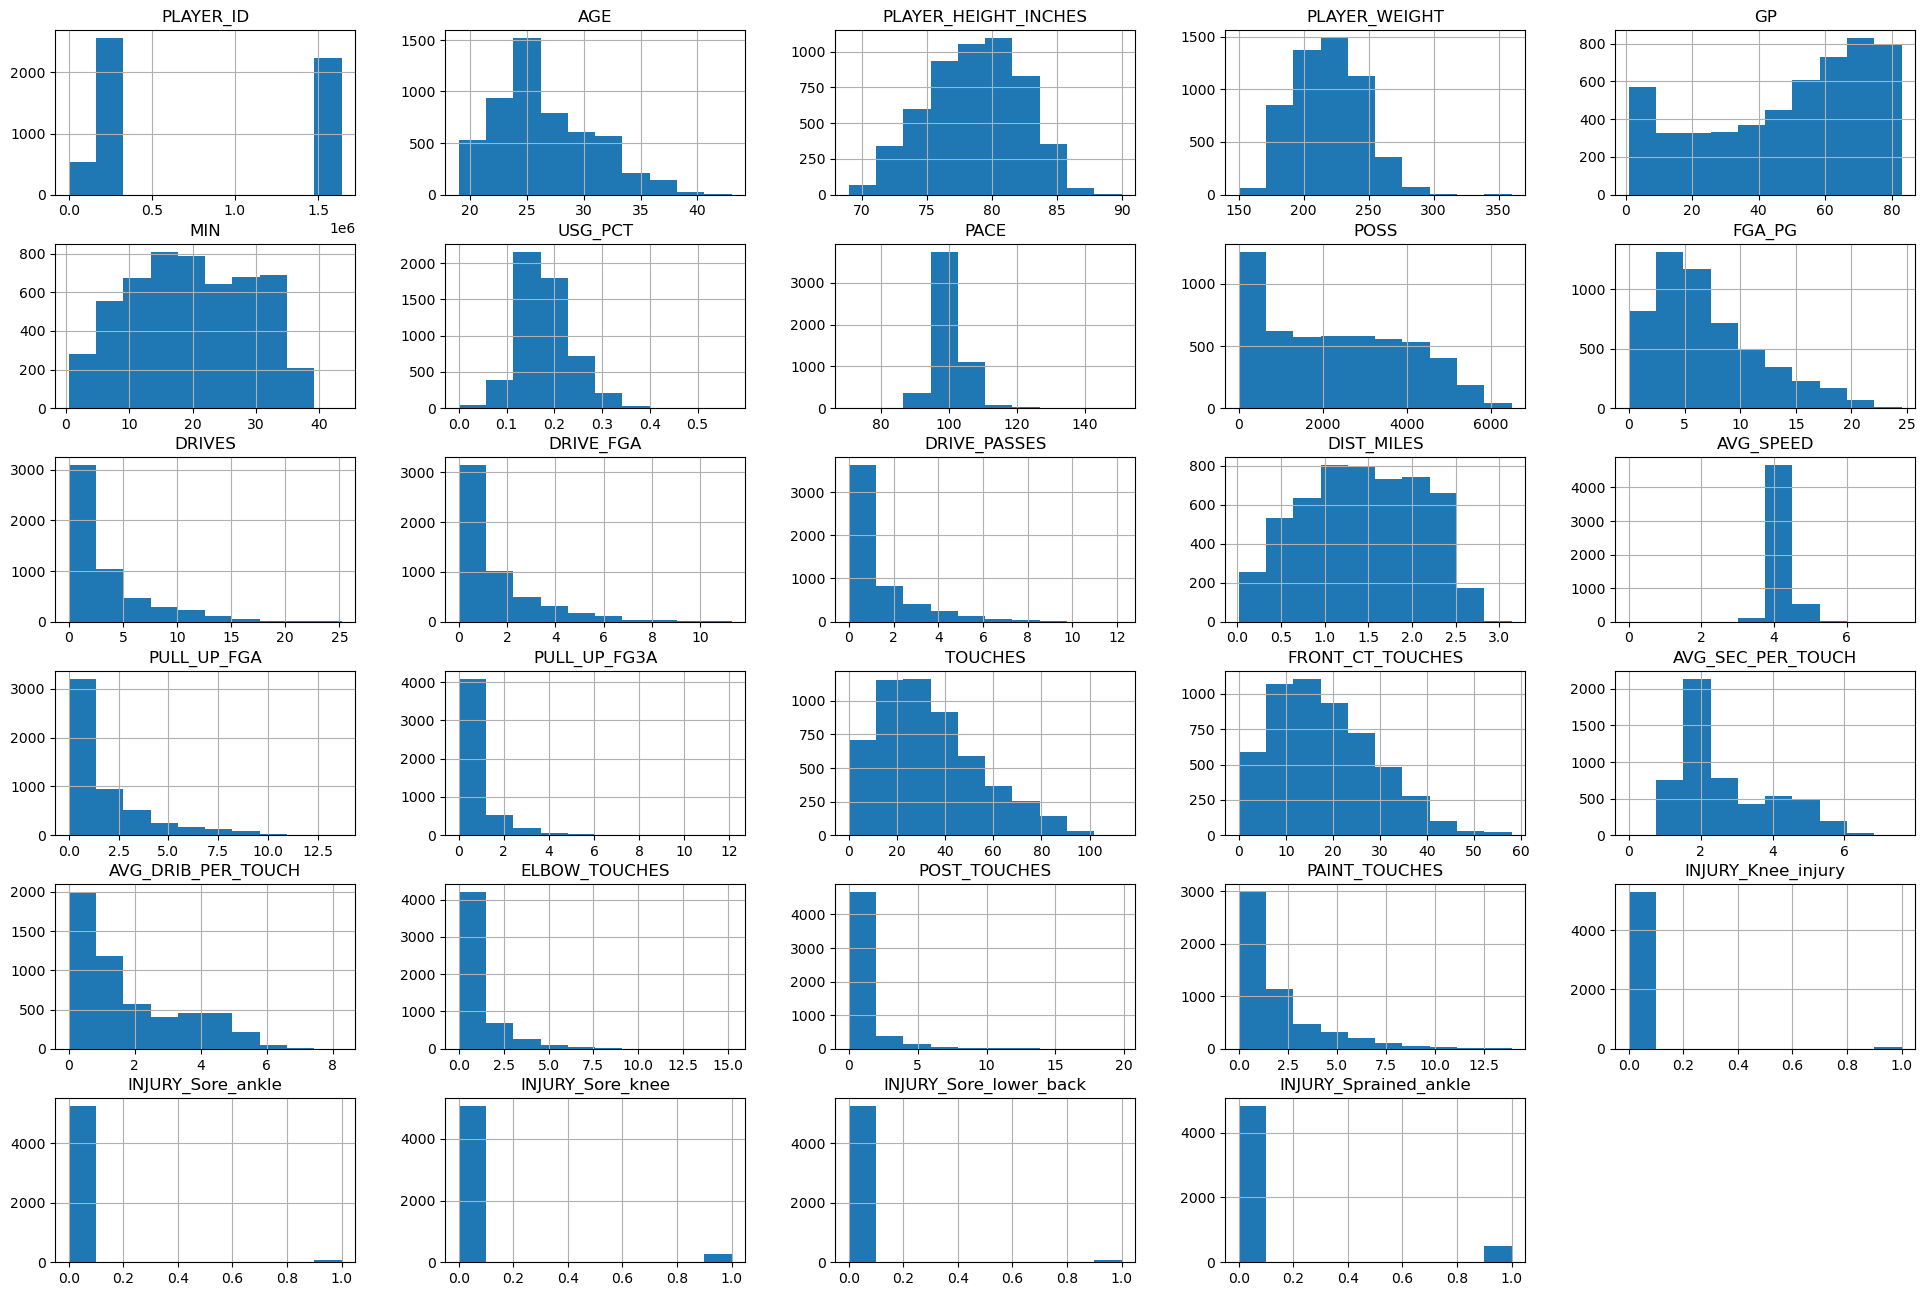

In [14]:
df_player.hist(figsize=(24, 16))

plt.xlabel('X-axis Label', fontsize=12)
plt.ylabel('Y-axis Label', fontsize=12)

plt.show()

Based on our model, which aims to predict the probability of player injury, we have made the decision to eliminate players with relatively low game play from our analysis. This is because these players may not be our target for prediction.

In [15]:
df_player = df_player[df_player['GP'] >= 20]

In [16]:
df_player['INJURED_TYPE'].value_counts()

Sprained_ankle     479
Sore_knee          246
Sore_ankle          75
Sore_lower_back     69
Knee_injury         46
Name: INJURED_TYPE, dtype: int64

In [17]:
df_player['INJURED_TYPE'] = df_player['INJURED_TYPE'].fillna('No_injury')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
df_player

PLAYER_ID      PLAYER_NAME SEASON   AGE  PLAYER_HEIGHT_INCHES  \
1       1631260         AJ Green  22-23  23.0                  77.0   
2       1631100       AJ Griffin  22-23  19.0                  78.0   
3        203932     Aaron Gordon  22-23  27.0                  80.0   
4       1628988    Aaron Holiday  22-23  26.0                  72.0   
5       1630174    Aaron Nesmith  22-23  23.0                  77.0   
...         ...              ...    ...   ...                   ...   
5573       2584     Willie Green  13-14  32.0                  75.0   
5574     201163  Wilson Chandler  13-14  27.0                  80.0   
5575     202333     Xavier Henry  13-14  23.0                  78.0   
5576       2216    Zach Randolph  13-14  32.0                  81.0   
5577       2585    Zaza Pachulia  13-14  30.0                  83.0   

      PLAYER_WEIGHT  GP   MIN  USG_PCT    PACE  ...  AVG_DRIB_PER_TOUCH  \
1             190.0  32   9.4    0.160  102.85  ...                1.84   
2             220.0  66  19.4    0.174  102.71  ...                1.49   
3             235.0  61  30.1    0.206  100.06  ...                2.11   
4             185.0  57  13.7    0.128  103.64  ...                3.82   
5             215.0  66  24.6    0.170  101.82  ...                0.80   
...             ...  ..   ...      ...     ...  ...                 ...   
5573          201.0  55  15.8    0.162   98.46  ...                1.84   
5574          225.0  62  31.1    0.193   99.49  ...                1.26   
5575          220.0  43  21.1    0.223  101.48  ...                2.45   
5576          260.0  79  34.2    0.258   90.59  ...                0.81   
5577          275.0  53  25.0    0.167   94.26  ...                0.54   

      ELBOW_TOUCHES  POST_TOUCHES  PAINT_TOUCHES    INJURED_TYPE  \
1               0.1           0.0            0.3       No_injury   
2               0.4           0.0            0.7       No_injury   
3               1.8           2.1            6.8  Sprained_ankle   
4               0.1           0.0            0.4       No_injury   
5               0.4           0.0            1.1  Sprained_ankle   
...             ...           ...            ...             ...   
5573            0.5           0.1            0.5       No_injury   
5574            1.4           1.0            1.7       No_injury   
5575            0.9           0.1            1.2       No_injury   
5576            3.6          17.3            9.5       No_injury   
5577            9.1           3.0            6.3       No_injury   

      INJURY_Knee_injury  INJURY_Sore_ankle  INJURY_Sore_knee  \
1                      0                  0                 0   
2                      0                  0                 0   
3                      0                  0                 0   
4                      0                  0                 0   
5                      0                  0                 0   
...                  ...                ...               ...   
5573                   0                  0                 0   
5574                   0                  0                 0   
5575                   0                  0                 0   
5576                   0                  0                 0   
5577                   0                  0                 0   

      INJURY_Sore_lower_back  INJURY_Sprained_ankle  
1                          0                      0  
2                          0                      0  
3                          0                      1  
4                          0                      0  
5                          0                      1  
...                      ...                    ...  
5573                       0                      0  
5574                       0                      0  
5575                       0                      0  
5576                       0                      0  
5577                       0                      0  

[4344

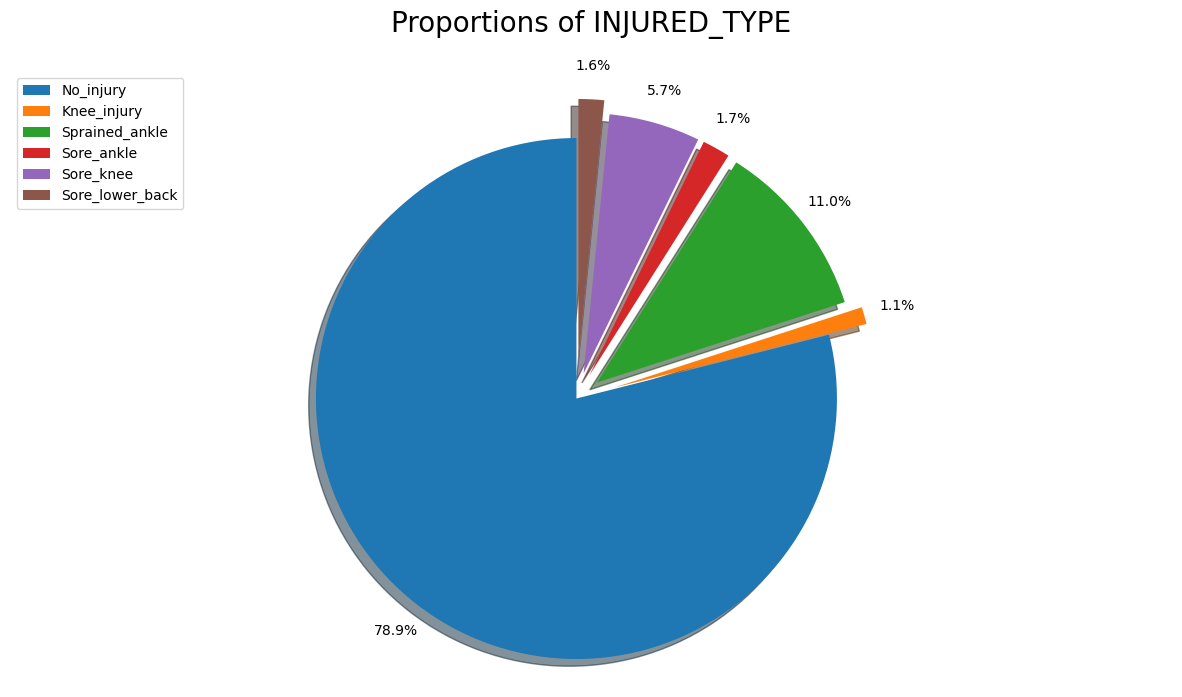

In [19]:
proportions_player_injury = df_player['INJURED_TYPE'].value_counts() / len(df_player)

labels = proportions_player_injury.index.tolist()
labels = [labels[0],labels[5],labels[1],labels[3],labels[2],labels[4]]
sizes = proportions_player_injury.values.tolist()
sizes = [sizes[0],sizes[5],sizes[1],sizes[3],sizes[2],sizes[4]]
explode = [0,0.15,0.1,0.1,0.1,0.15]

plt.figure(figsize=(15,8))
plt.pie(sizes, labels=None, autopct='%1.1f%%', startangle=90, shadow=True, pctdistance=1.13, explode=explode)

plt.title('Proportions of INJURED_TYPE', y=1.05, fontsize=20)
plt.legend(labels = labels, loc='upper left')
plt.axis('equal')

plt.show()

---
As you can observe, the incidence of most injuries is significantly lower compared to players without any injuries. Training a machine learning model for each specific injury type would result in severe overfitting due to the highly imbalanced data. Therefore, I have decided to combine all different injury types into a single category of 'injury or not.' Additionally, since these injury types can be considered cumulative injuries, I will train the data to predict whether a player will sustain cumulative injuries based on their statistics.

---

In [20]:
def check_injury(row):
    if row['INJURY_Sore_ankle'] == 1 or row['INJURY_Sore_knee'] == 1 or \
    row['INJURY_Sore_lower_back'] == 1 or row['INJURY_Sprained_ankle'] == 1 or \
    row['INJURY_Knee_injury'] == 1:
        return 1
    else:
        return 0

In [21]:
df_player['INJURY'] = df_player.apply(check_injury, axis=1)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [22]:
df_player.drop(['INJURY_Sore_ankle',
       'INJURY_Sore_knee', 'INJURY_Sore_lower_back', 'INJURY_Sprained_ankle',
       'INJURY_Knee_injury'], axis= 1, inplace = True )


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
df_player

PLAYER_ID      PLAYER_NAME SEASON   AGE  PLAYER_HEIGHT_INCHES  \
1       1631260         AJ Green  22-23  23.0                  77.0   
2       1631100       AJ Griffin  22-23  19.0                  78.0   
3        203932     Aaron Gordon  22-23  27.0                  80.0   
4       1628988    Aaron Holiday  22-23  26.0                  72.0   
5       1630174    Aaron Nesmith  22-23  23.0                  77.0   
...         ...              ...    ...   ...                   ...   
5573       2584     Willie Green  13-14  32.0                  75.0   
5574     201163  Wilson Chandler  13-14  27.0                  80.0   
5575     202333     Xavier Henry  13-14  23.0                  78.0   
5576       2216    Zach Randolph  13-14  32.0                  81.0   
5577       2585    Zaza Pachulia  13-14  30.0                  83.0   

      PLAYER_WEIGHT  GP   MIN  USG_PCT    PACE  ...  PULL_UP_FG3A  TOUCHES  \
1             190.0  32   9.4    0.160  102.85  ...           0.7     11.9   
2             220.0  66  19.4    0.174  102.71  ...           0.8     21.1   
3             235.0  61  30.1    0.206  100.06  ...           0.9     41.7   
4             185.0  57  13.7    0.128  103.64  ...           0.3     20.6   
5             215.0  66  24.6    0.170  101.82  ...           0.5     34.7   
...             ...  ..   ...      ...     ...  ...           ...      ...   
5573          201.0  55  15.8    0.162   98.46  ...           0.3     22.0   
5574          225.0  62  31.1    0.193   99.49  ...           0.4     43.7   
5575          220.0  43  21.1    0.223  101.48  ...           0.4     33.9   
5576          260.0  79  34.2    0.258   90.59  ...           0.1     56.1   
5577          275.0  53  25.0    0.167   94.26  ...           0.0     39.6   

      FRONT_CT_TOUCHES  AVG_SEC_PER_TOUCH  AVG_DRIB_PER_TOUCH  ELBOW_TOUCHES  \
1                  7.3               2.61                1.84            0.1   
2                 14.2               2.08                1.49            0.4   
3                 23.3               2.94                2.11            1.8   
4                  8.0               4.17                3.82            0.1   
5                 19.9               1.67                0.80            0.4   
...                ...                ...                 ...            ...   
5573              15.1               2.44                1.84            0.5   
5574              29.1               2.33                1.26            1.4   
5575              20.2               3.24                2.45            0.9   
5576              39.0               2.15                0.81            3.6   
5577              29.9               1.83                0.54            9.1   

      POST_TOUCHES  PAINT_TOUCHES    INJURED_TYPE  INJURY  
1              0.0            0.3       No_injury       0  
2              0.0            0.7       No_injury       0  
3              2.1            6.8  Sprained_ankle       1  
4              0.0            0.4       No_injury       0  
5              0.0            1.1  Sprained_ankle       1  
...            ...            ...             ...     ...  
5573           0.1            0.5       No_injury       0  
5574           1.0            1.7       No_injury       0  
5575           0.1            1.2       No_injury       0  
5576          17.3            9.5       No_injury       0  
5577           3.0            6.3       No_injury       0  

[4344 rows x 28 columns]

Furthermore, I will eliminate certain irrelevant data columns, including 'PLAYER_ID', 'INJURED_TYPE', and 'GP'.

The rationale behind dropping 'GP' is that an injured player's number of games played is undoubtedly low since they are unable to participate on the court.

In [24]:
df_player.drop(['PLAYER_ID', 'INJURED_TYPE', 'GP', 'PLAYER_NAME', 'SEASON'], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [25]:
df_player.describe(include='number')

AGE  PLAYER_HEIGHT_INCHES  PLAYER_WEIGHT          MIN  \
count  4344.000000           4344.000000    4344.000000  4344.000000   
mean     26.707643             78.821823     219.199125    22.055064   
std       4.266904              3.415035      25.163992     8.352731   
min      19.000000             69.000000     150.000000     2.300000   
25%      23.000000             76.000000     200.000000    15.500000   
50%      26.000000             79.000000     220.000000    21.900000   
75%      30.000000             81.000000     240.000000    29.200000   
max      43.000000             88.000000     295.000000    38.700000   

           USG_PCT         PACE         POSS       FGA_PG       DRIVES  \
count  4344.000000  4344.000000  4344.000000  4344.000000  4344.000000   
mean      0.184182    99.549321  2778.340700     7.896363     3.809669   
std       0.051818     3.248021  1480.790445     4.614925     4.001656   
min       0.050000    88.780000   110.000000     0.500000     0.000000   
25%       0.147000    97.380000  1535.750000     4.400000     0.900000   
50%       0.176000    99.615000  2731.000000     6.700000     2.400000   
75%       0.216000   101.790000  3982.000000    10.600000     5.300000   
max       0.402000   111.400000  6486.000000    24.500000    25.200000   

         DRIVE_FGA  ...  PULL_UP_FGA  PULL_UP_FG3A      TOUCHES  \
count  4344.000000  ...  4344.000000   4125.000000  4344.000000   
mean      1.649632  ...     1.983149      0.743661    37.837385   
std       1.719035  ...     2.258136      1.089678    19.735959   
min       0.000000  ...     0.000000      0.000000     3.200000   
25%       0.400000  ...     0.400000      0.100000    22.700000   
50%       1.100000  ...     1.100000      0.300000    34.500000   
75%       2.300000  ...     2.800000      1.000000    49.725000   
max      11.300000  ...    13.700000     12.100000   101.000000   

       FRONT_CT_TOUCHES  AVG_SEC_PER_TOUCH  AVG_DRIB_PER_TOUCH  ELBOW_TOUCHES  \
count       4344.000000        4344.000000         4344.000000    4344.000000   
mean          20.579052           2.692304            1.878953       1.218485   
std           10.060791           1.280018            1.572580       1.422278   
min            2.000000           1.040000            0.160000       0.000000   
25%           12.775000           1.670000            0.580000       0.300000   
50%           19.200000           2.160000            1.250000       0.700000   
75%           27.100000           3.622500            3.000000       1.500000   
max           58.000000           6.610000            7.030000      15.200000   

       POST_TOUCHES  PAINT_TOUCHES       INJURY  
count   4344.000000    4344.000000  4344.000000  
mean       0.964019       2.177509     0.210635  
std        1.866498       2.250105     0.407807  
min        0.000000       0.000000     0.000000  
25%        0.000000       0.600000     0.000000  
50%        0.200000       1.300000     0.000000  
75%        1.000000       2.900000     0.000000  
max       19.800000      13.900000     1.000000  

[8 rows x 23 columns]

# Split dataset to Test and Train

Given the combination of imbalanced and limited data, it becomes crucial to employ stratified splitting during the data partitioning process. This approach is essential to ensure the consistency of the data distribution. Therefore, I will perform stratified splitting, considering the 'y' column, to effectively divide the dataset into training and testing sets.

In [26]:
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in sss.split(df_player, df_player['INJURY']):
    X_train, X_test = df_player.drop(['INJURY'], axis=1).iloc[train_index], df_player.drop(['INJURY'], axis=1).iloc[test_index]
    y_train, y_test = df_player['INJURY'].iloc[train_index], df_player['INJURY'].iloc[test_index]
    strat_splits.append([X_train, y_train, X_test, y_test])

In [27]:
X_train, y_train, X_test, y_test = strat_splits[0]

To ensure consistency, it is important to check the proportions of the target class in the original dataset, training set, and test set. This helps to verify whether the splitting process, particularly the stratified splitting, has effectively preserved the balance of the target class.

By examining the proportions, we can determine if the distribution of the target class remains similar across all subsets. Any significant deviations may indicate the need to adjust the splitting strategy or consider additional techniques such as oversampling or undersampling to address class imbalance and maintain consistency in the data.

In [28]:
size_data = (df_player['INJURY'].value_counts() / len(df_player['INJURY'])).to_list()
size_train = (y_train.value_counts() / len(y_train)).to_list()
size_test = (y_test.value_counts() / len(y_test)).to_list()

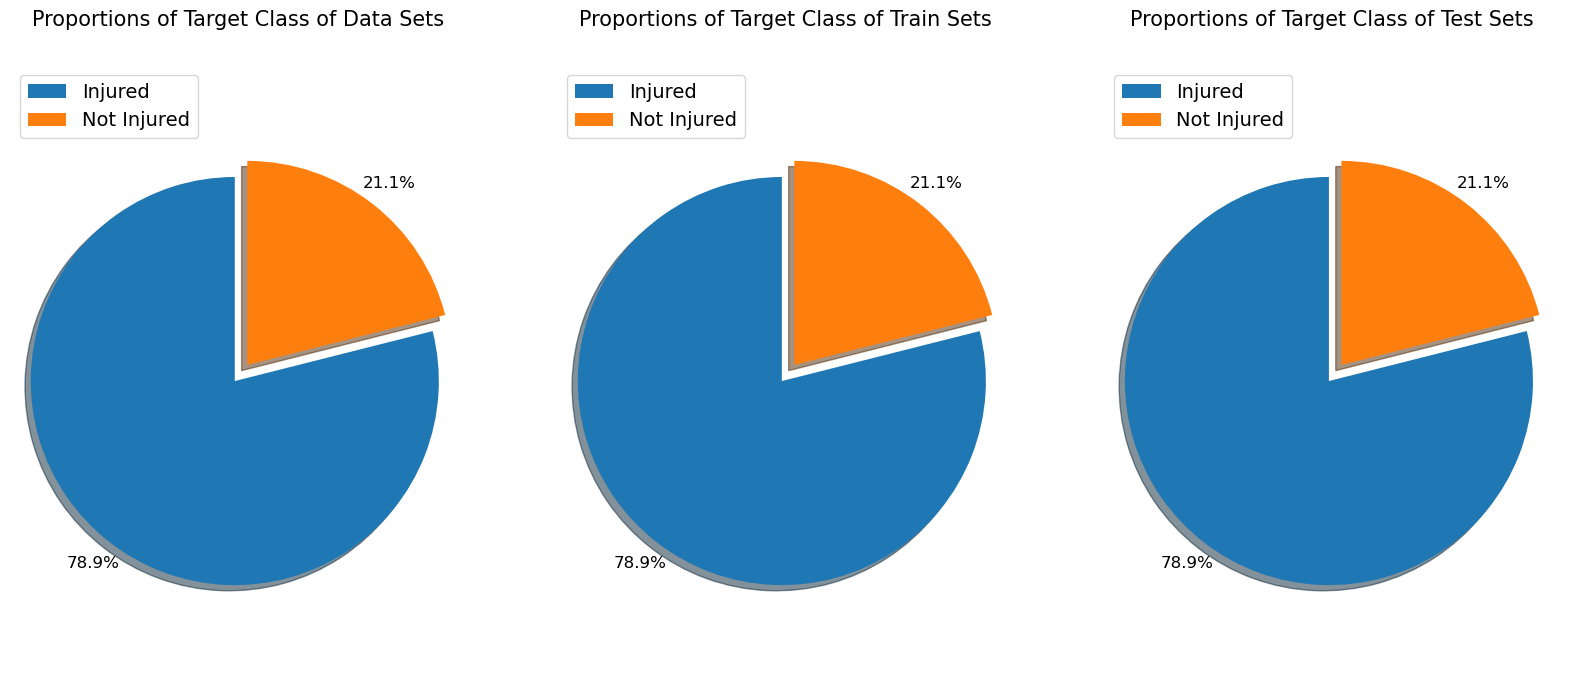

In [29]:
fig = plt.figure(figsize=(20, 8))

labels = ['Injured', 'Not Injured']
explode = [0, 0.10]

ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)

# subplot 1
ax0.pie(size_data, labels=None, autopct='%1.1f%%', startangle=90, shadow=True, pctdistance=1.13, explode=explode, textprops={'fontsize': 12})

ax0.set_title('Proportions of Target Class of Data Sets', y=1.05, fontsize=15)
ax0.legend(labels=labels, loc='upper left', fontsize=14)
ax0.axis('equal')

# subplot 2
ax1.pie(size_train, labels=None, autopct='%1.1f%%', startangle=90, shadow=True, pctdistance=1.13, explode=explode, textprops={'fontsize': 12})

ax1.set_title('Proportions of Target Class of Train Sets', y=1.05, fontsize=15)
ax1.legend(labels=labels, loc='upper left', fontsize=14)
ax1.axis('equal')

# subplot 3
ax2.pie(size_test, labels=None, autopct='%1.1f%%', startangle=90, shadow=True, pctdistance=1.13, explode=explode, textprops={'fontsize': 12})

ax2.set_title('Proportions of Target Class of Test Sets', y=1.05, fontsize=15)
ax2.legend(labels=labels, loc='upper left', fontsize=14)
ax2.axis('equal')

plt.show()

# Missing Value

Ensuring the presence of complete and reliable data is crucial for analysis. Thus, it is necessary to assess the dataset for missing values and handle them appropriately.

First, we need to check the dataset for missing values, identifying any variables or instances with incomplete information. Once identified, we can employ various techniques to handle these missing values.

One approach is to remove instances or features with missing values if they are limited and do not significantly impact the overall dataset. Alternatively, we can utilize imputation methods such as mean, median, mode, or regression imputation to fill in the missing values based on the nature of the data.

In [30]:
def missing_percent_plot(df, title):
    """
    Function to visualize the percentage of missing data in a DataFrame.
    """
    # Calculate the percentage of missing value in each column
    nan_ratio = df.isnull().mean() * 100

    # Filter out columns with no missing data
    nan_ratio = nan_ratio[nan_ratio > 0].sort_values()
    nan_ratio_rounded = nan_ratio.round(1)

    plt.figure(figsize=(8, 4))

    bar_plot = sns.barplot(x=nan_ratio_rounded.values, y=nan_ratio_rounded.index, palette='rocket')

    for p in bar_plot.patches:
        percentage = p.get_width()
        if percentage > 10:
            bar_plot.annotate(f"{percentage}%", 
                              (p.get_x() + p.get_width(), p.get_y() + p.get_height()/2),
                              ha='right', va='center', 
                              fontsize=10, color='white', 
                              xytext=(-20,0), 
                              textcoords='offset points')
    
    plt.title("Percentage of Missing Data in " + title, fontsize=14)
    plt.xlabel('Percentage of Missing Data (%)', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.show()

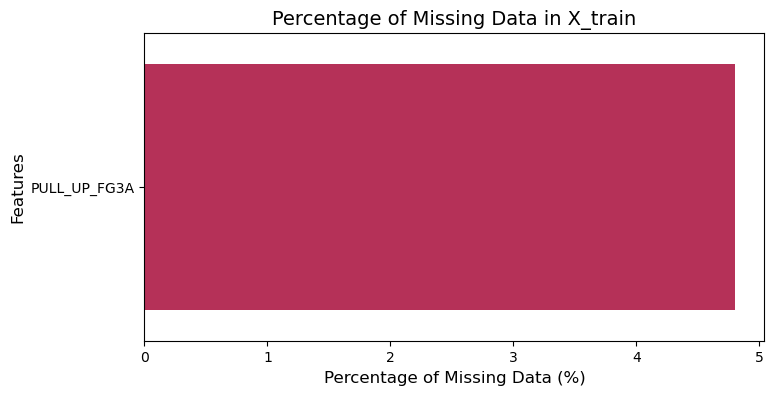

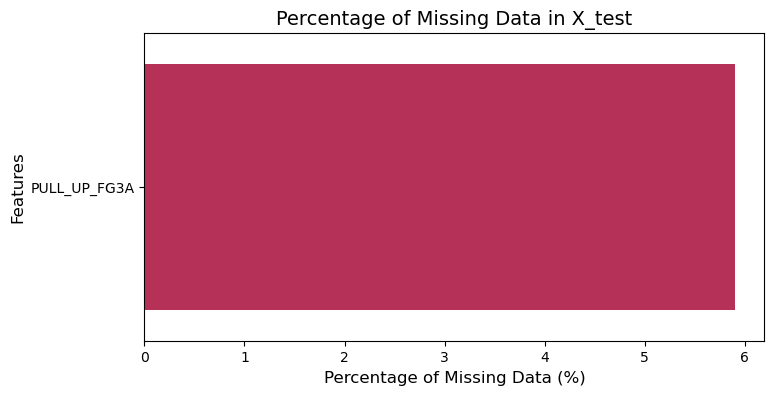

In [31]:
missing_percent_plot(X_train, 'X_train')
missing_percent_plot(X_test, 'X_test')

When encountering features with missing values and their related features, I utilize box plots to make informed decisions regarding their treatment. By visualizing the distributions and variations within the data, I can assess the impact of missing values on the features and determine appropriate strategies for handling them.

Based on the insights gained from the box plots, I consider whether to remove the features entirely or employ specific techniques to address the missing values.

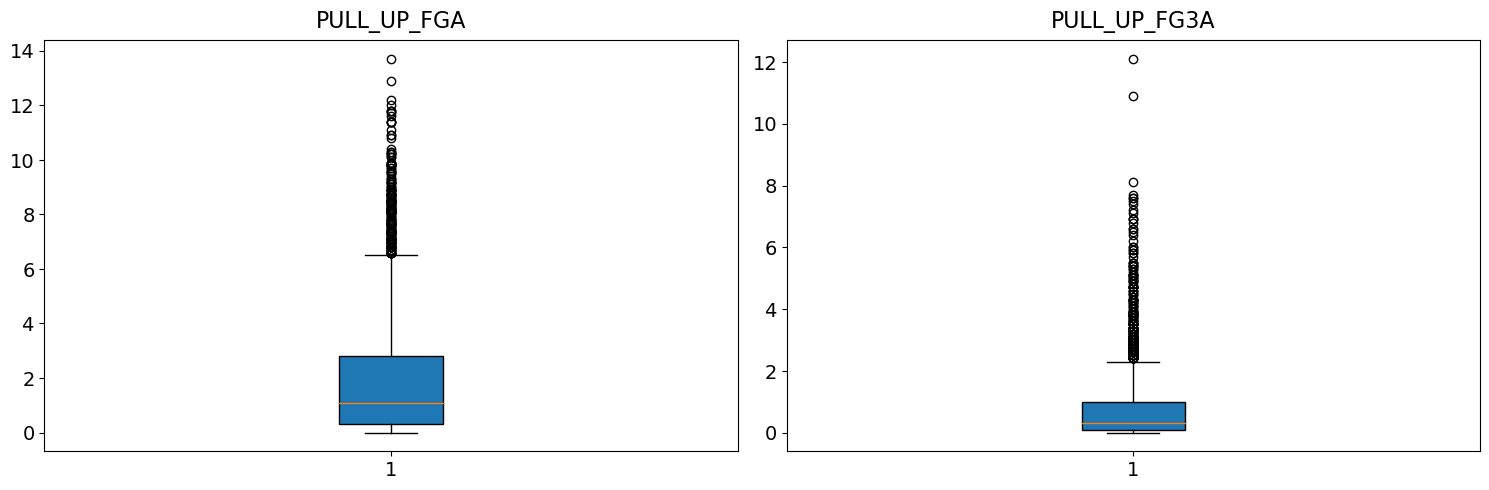

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

columns = ['PULL_UP_FGA','PULL_UP_FG3A']
cmap = plt.cm.Blues

for i, column in enumerate(columns):
    box = axes[i].boxplot(X_train[column].dropna(), patch_artist=True)
    axes[i].set_title(column, fontsize=16, y=1.01)
    axes[i].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()

In the context of basketball, the variables PULL_UP_FGA (field goal attempts) and PULL_UP_FG3A (three-point field goal attempts) exhibit a close relationship due to the modern trends in the game. Players who frequently attempt pull-up mid-range shots also tend to have a higher number of pull-up three-point attempts, and vice versa.

To confirm this observation, I examine the box plots of these variables and find that their distributions are similar. To further analyze their relationship, I calculate the correlation between them and generate a kernel density estimation (kdeplot) to visualize the correlation's strength and direction.

In [33]:
print('Correlation of PULL_UP_FGA and PULL_UP_FG3A:', X_train['PULL_UP_FGA'].corr(X_train['PULL_UP_FG3A']))

Correlation of PULL_UP_FGA and PULL_UP_FG3A: 0.8412380500454033


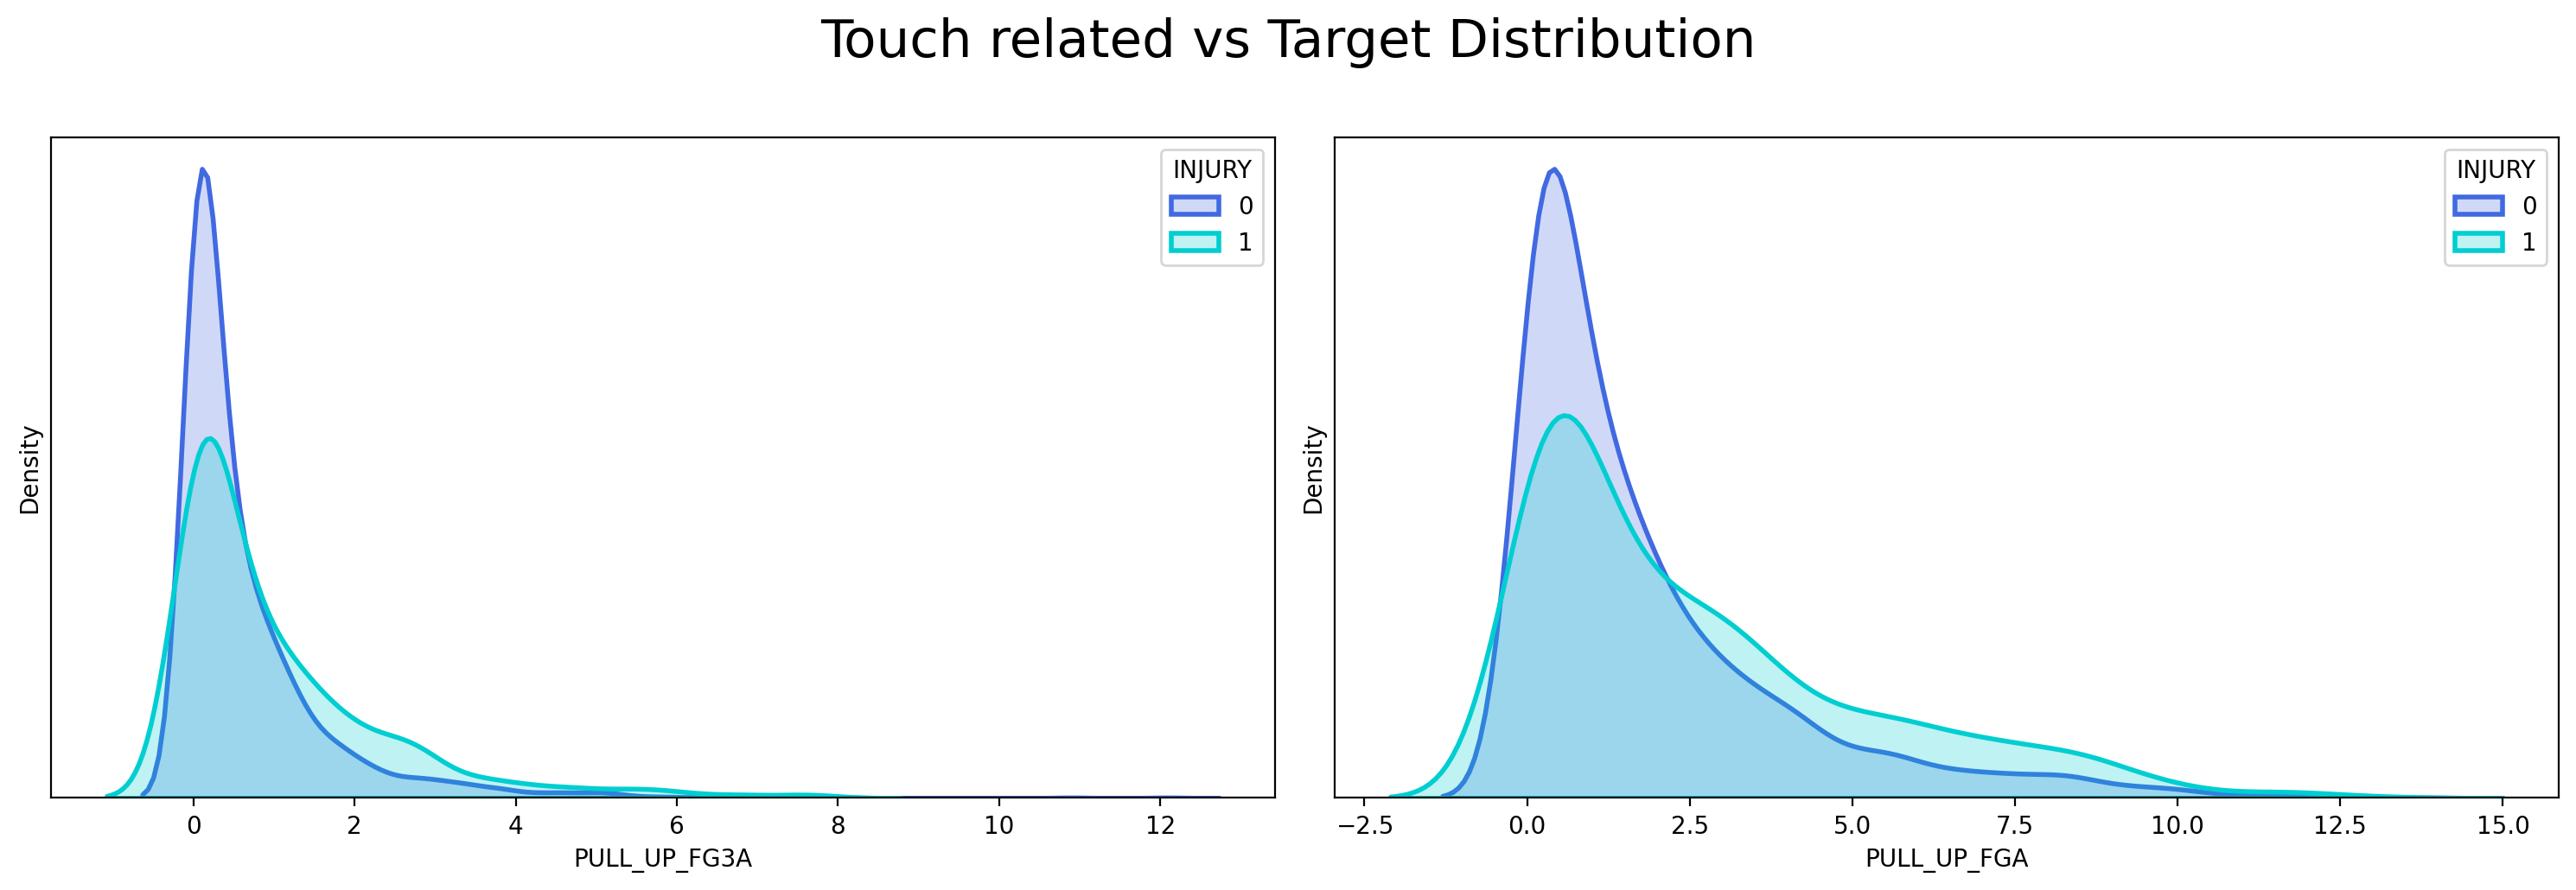

In [34]:
num_features = ['PULL_UP_FG3A', 'PULL_UP_FGA']

sns.set_palette(['royalblue', 'darkturquoise'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=200)

combined_data = pd.concat([X_train, y_train], axis=1)


for j, num_feature in enumerate(num_features):

    sns.kdeplot(data=combined_data[combined_data[y_train.name] == 0], x=num_feature, fill=True, linewidth=2, ax=ax[j], label='0')

    sns.kdeplot(data=combined_data[combined_data[y_train.name] == 1], x=num_feature, fill=True, linewidth=2, ax=ax[j], label='1')

    ax[j].set_yticks([])
    ax[j].legend(title=y_train.name, loc='upper right')

plt.suptitle('Touch related vs Target Distribution', fontsize=22, y=1.02)
plt.tight_layout()
plt.show()

Considering the high correlation between the variables PULL_UP_FGA and PULL_UP_FG3A, as well as the similar distributions observed in the kde plot, I have made the decision to drop the entire column of PULL_UP_FG3A. 

In [35]:
X_train.drop(['PULL_UP_FG3A'], axis = 1, inplace=True)
X_test.drop(['PULL_UP_FG3A'], axis = 1, inplace=True)

# Feature Engineering

## Drop Similiar Features

To identify and mitigate potential overfitting issues caused by redundant features, it is important to examine the dataset for similar features that provide the same information.

By comparing the characteristics and information captured by different features, we can assess if there is redundancy. If multiple features are found to be highly correlated or provide similar information, dropping one or more of these similar features becomes necessary to avoid overfitting.

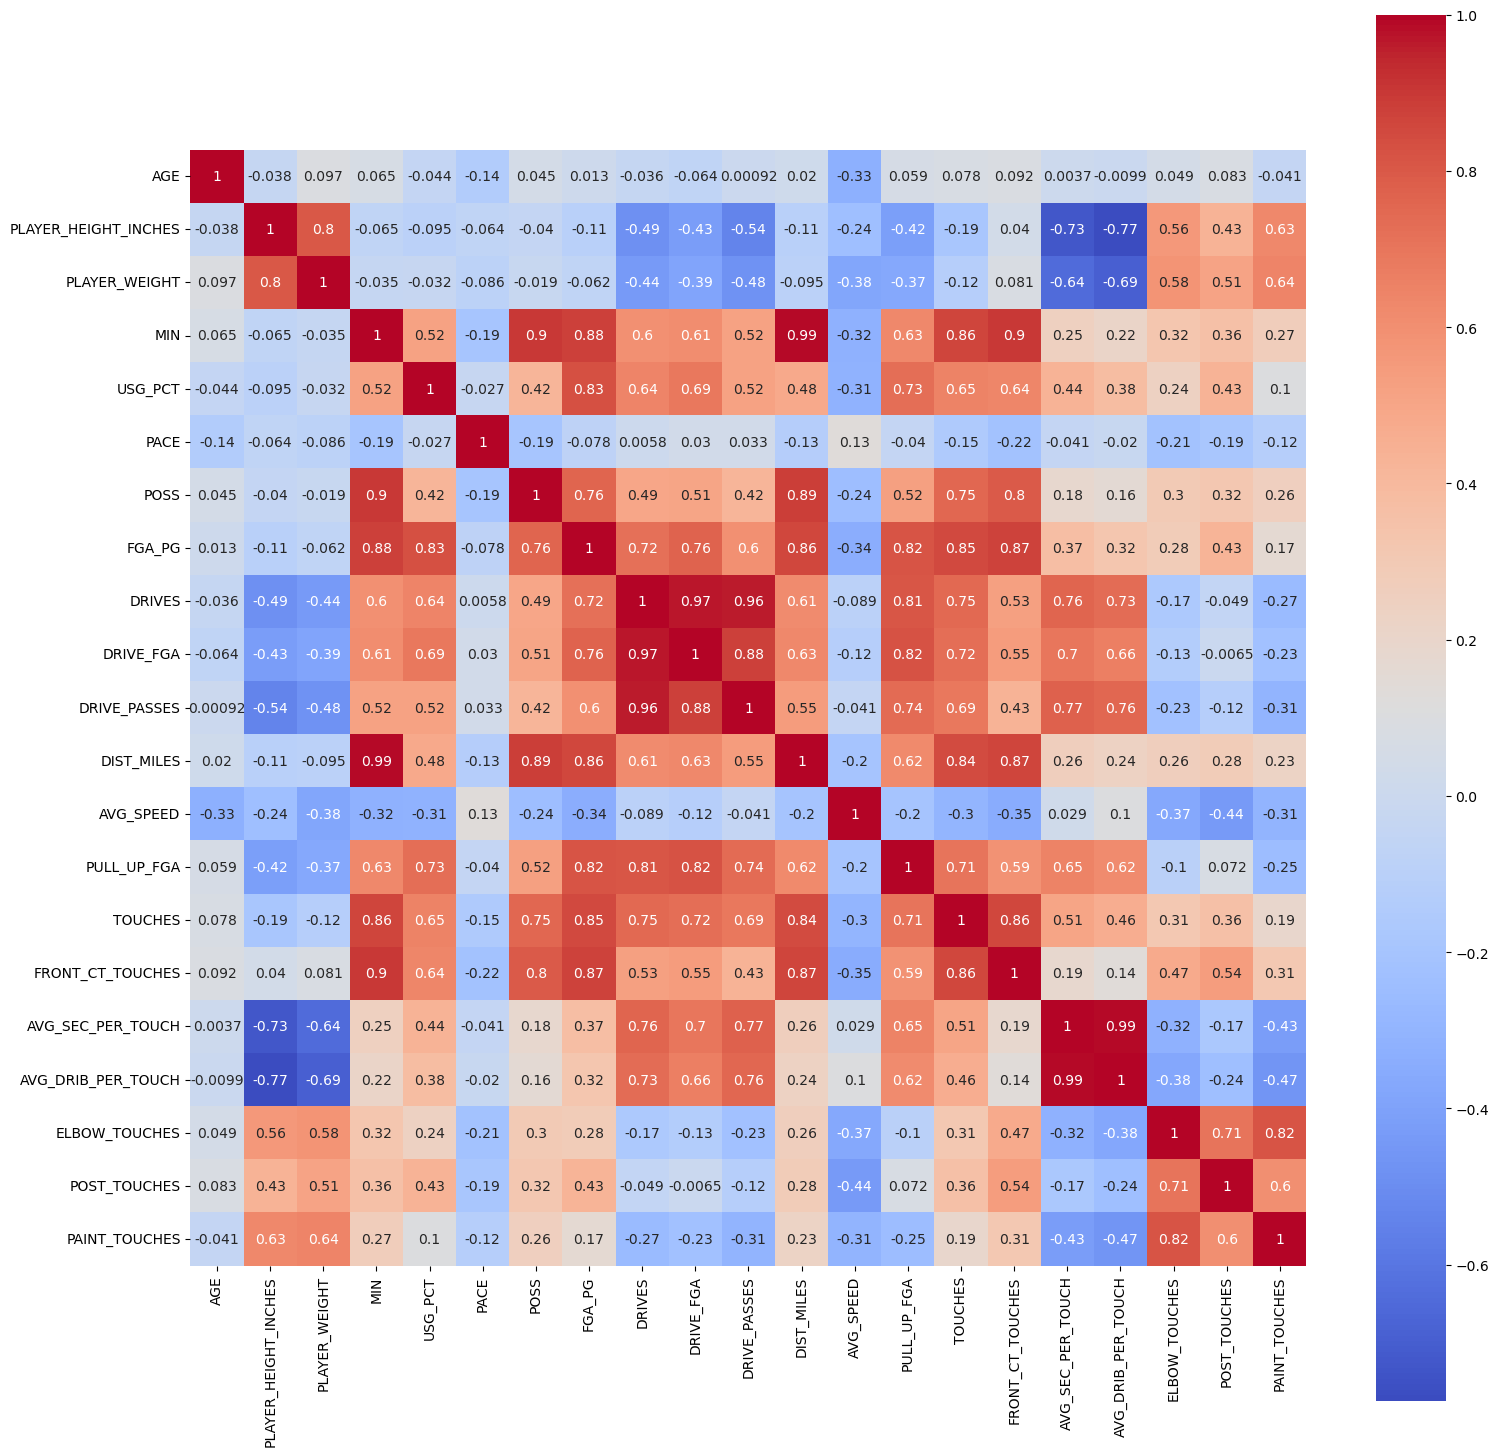

In [36]:
corr_matrix = X_train.corr(numeric_only=True)

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.show()

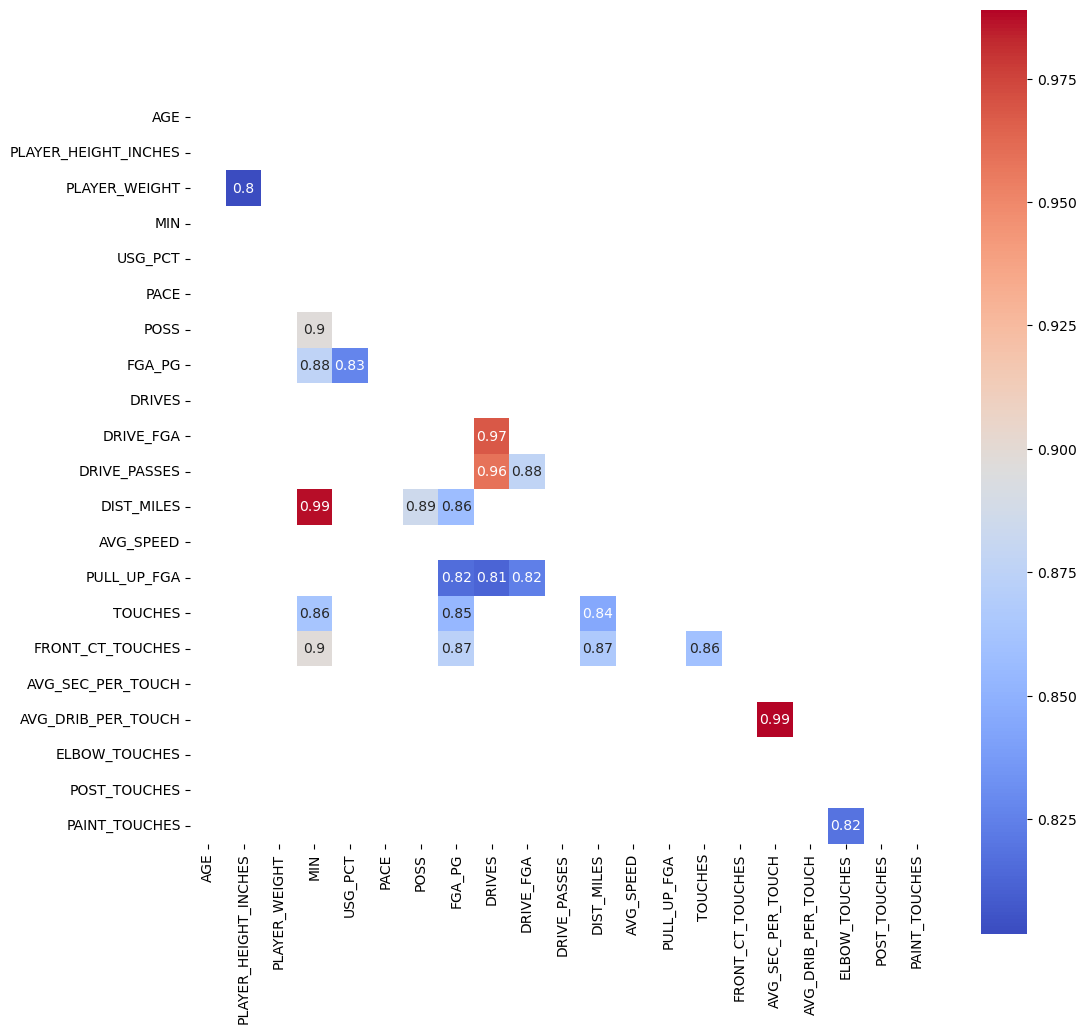

In [37]:
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True
mask[np.abs(corr_matrix) < 0.8] = True

plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True, mask=mask)
plt.show()

---
The kde plot is a valuable tool for assessing whether features provide similar information, as it enables us to visualize the distribution directly. To simplify the process of drawing kde plots for multiple features, I have developed a convenient function. This function allows me to compare the distributions of different features side by side, making it easier to identify similarities and redundancies in the data. By leveraging the kde plot and the function, I can efficiently assess the degree of overlap and decide which features should be dropped to mitigate the risk of overfitting.

---

In [38]:
def plot_feature_distributions(X_train, y_train, num_features, n_cols):
    sns.set_palette(['royalblue', 'darkturquoise'])

    n_rows = (len(num_features) + n_cols - 1) // n_cols

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), dpi=200)
    ax = ax.flatten()

    combined_data = pd.concat([X_train, y_train], axis=1)

    for idx, num_feature in enumerate(num_features):
        
        sns.kdeplot(data=combined_data[combined_data[y_train.name] == 0], x=num_feature, fill=True, linewidth=2, ax=ax[idx], label='0')
        sns.kdeplot(data=combined_data[combined_data[y_train.name] == 1], x=num_feature, fill=True, linewidth=2, ax=ax[idx], label='1')

        ax[idx].set_yticks([])
        ax[idx].legend(title=y_train.name, loc='upper right')

    for i in range(idx + 1, len(ax)):
        fig.delaxes(ax[i])

    plt.suptitle('Feature Distributions vs Target', fontsize=22, y=1.02)
    plt.tight_layout()
    plt.show()

In [39]:
def plot_feature_boxplots(X_train, y_train, num_features, n_cols):
    n_rows = (len(num_features) + n_cols - 1) // n_cols

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), dpi=200)
    ax = ax.flatten()

    combined_data = pd.concat([X_train, y_train], axis=1)

    for idx, num_feature in enumerate(num_features):
        sns.boxplot(y=combined_data[num_feature], color='royalblue', ax=ax[idx])
        ax[idx].set_title(num_feature)

    for i in range(idx + 1, len(ax)):
        fig.delaxes(ax[i])

    plt.suptitle('Feature Boxplots', fontsize=22, y=1.02)
    plt.tight_layout()
    plt.show()

---
By plotting the kde (kernel density estimation) curves for these correlated features, I can directly compare their distributions. This visualization allows me to determine if the features provide similar information or exhibit redundancy. If the kde plots show overlapping or highly similar distributions, it indicates a potential redundancy in the information captured by those features.

By focusing on features with high correlation and conducting kde plot comparisons, I can effectively identify and address any redundancies in the dataset, leading to a more streamlined and informative feature set for further analysis.

---

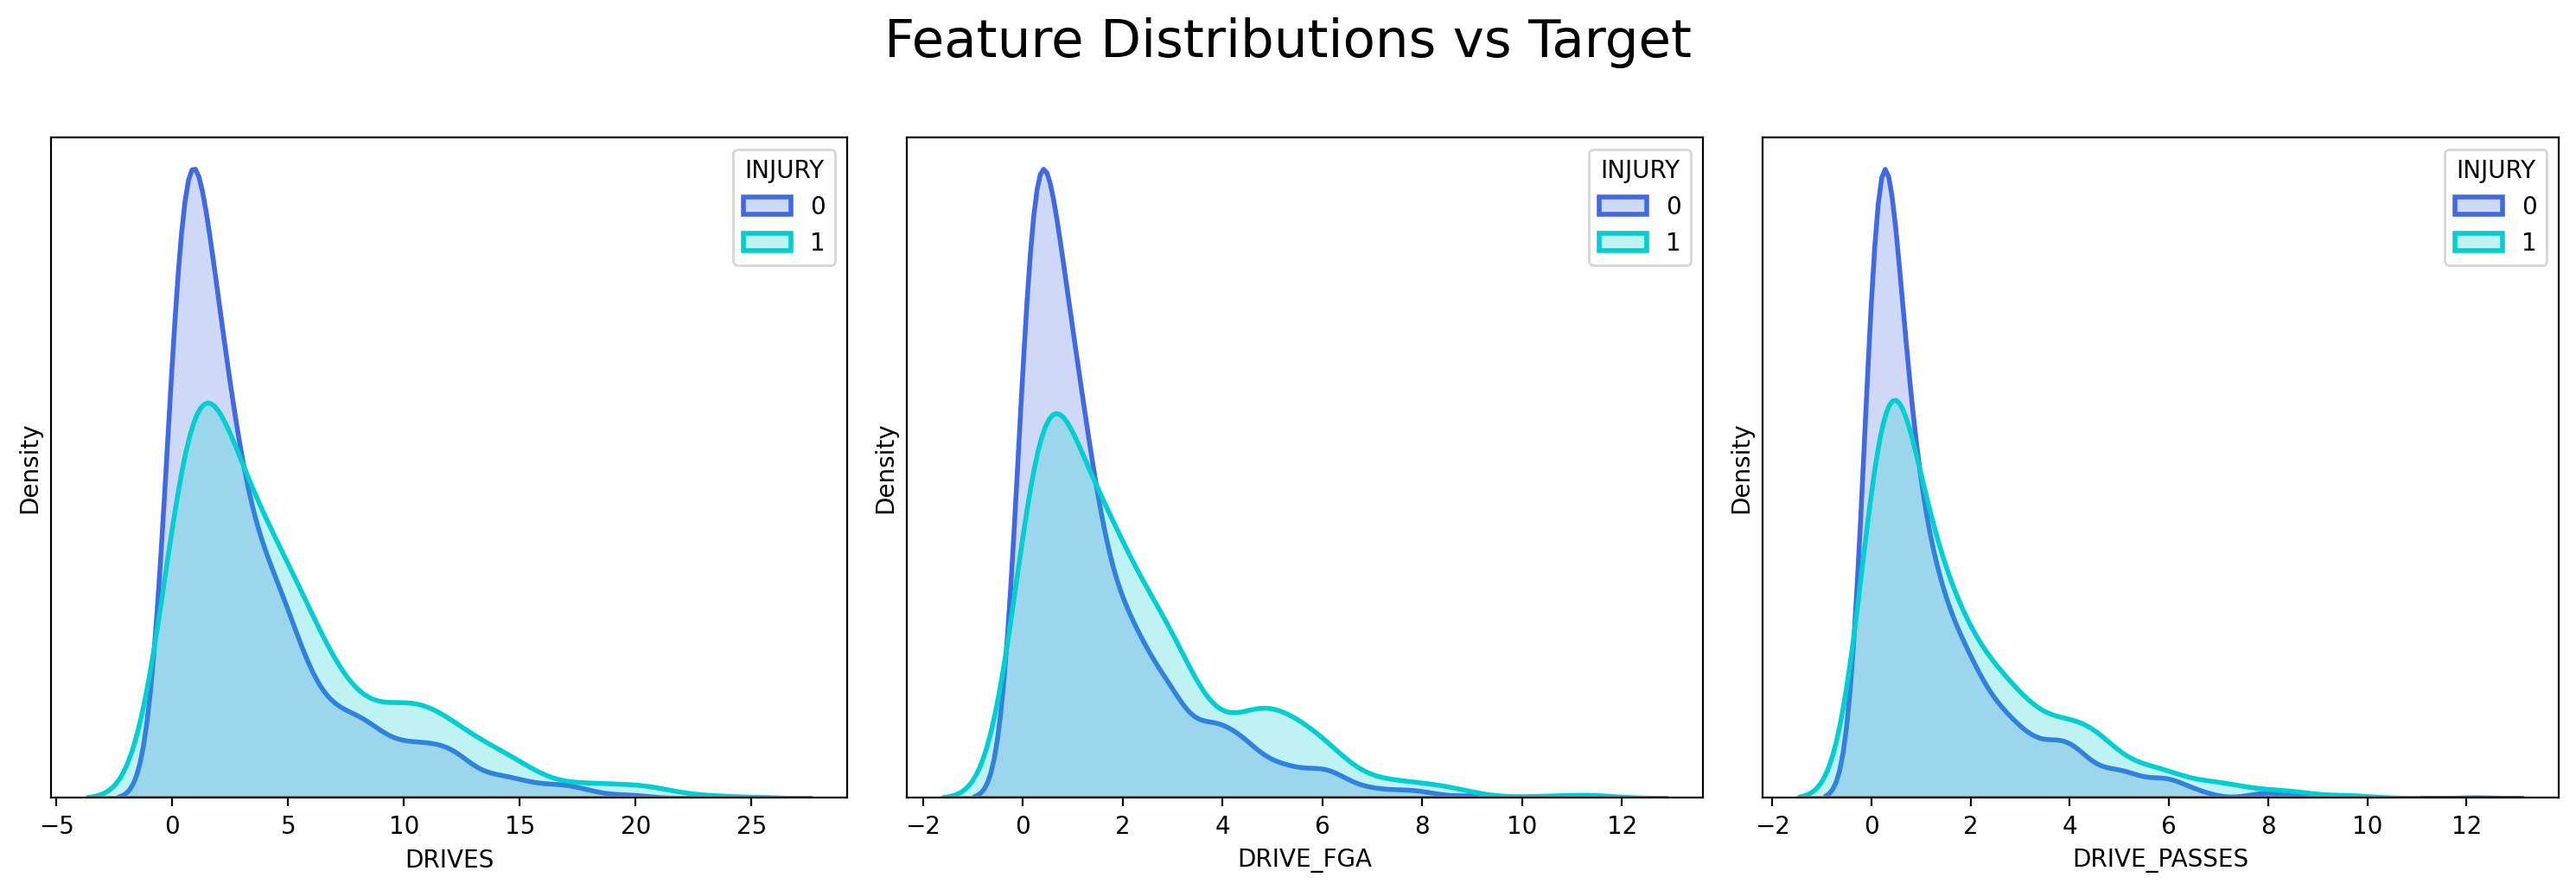

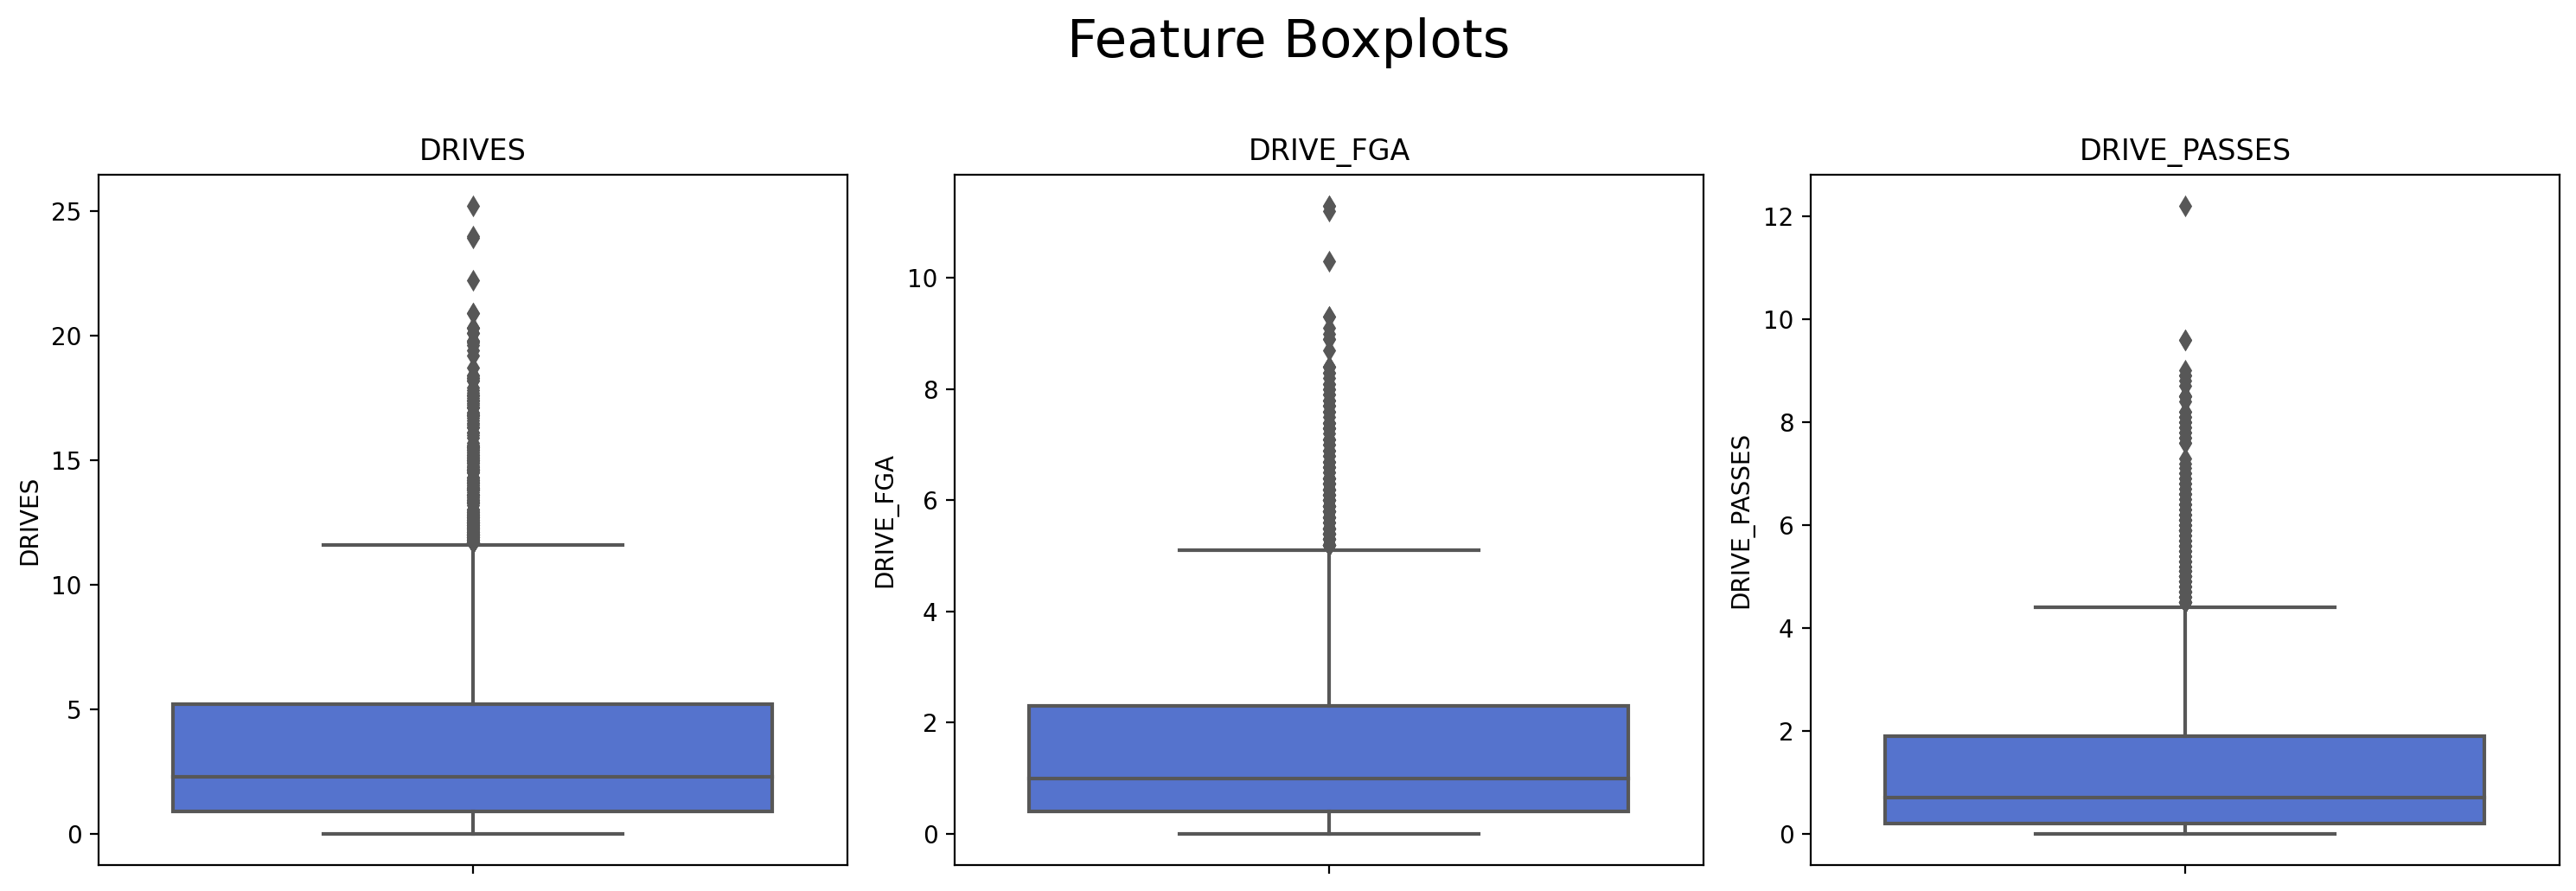

In [40]:
num_features = ['DRIVES', 'DRIVE_FGA', 'DRIVE_PASSES']

plot_feature_distributions(X_train, y_train, num_features, 3)
plot_feature_boxplots(X_train, y_train, num_features, 3)

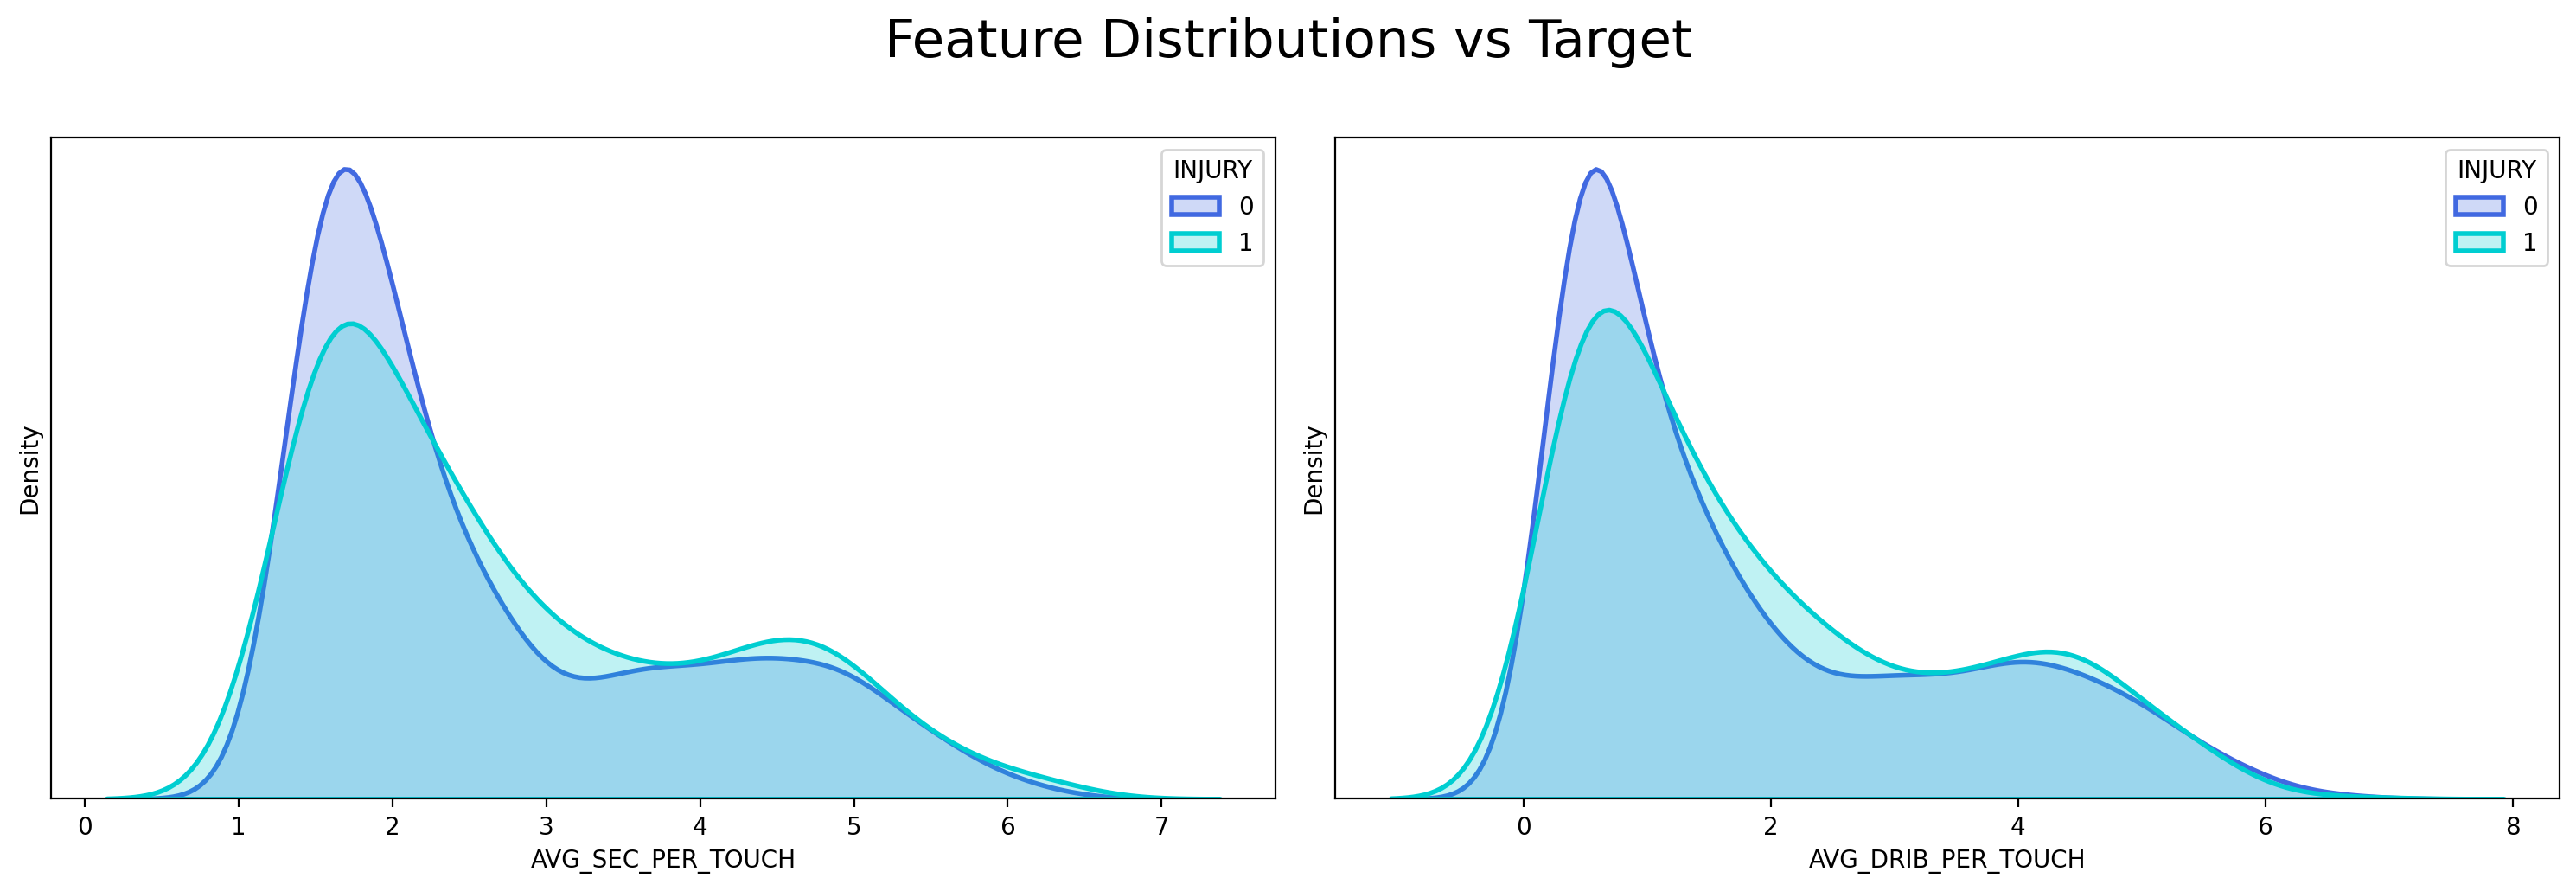

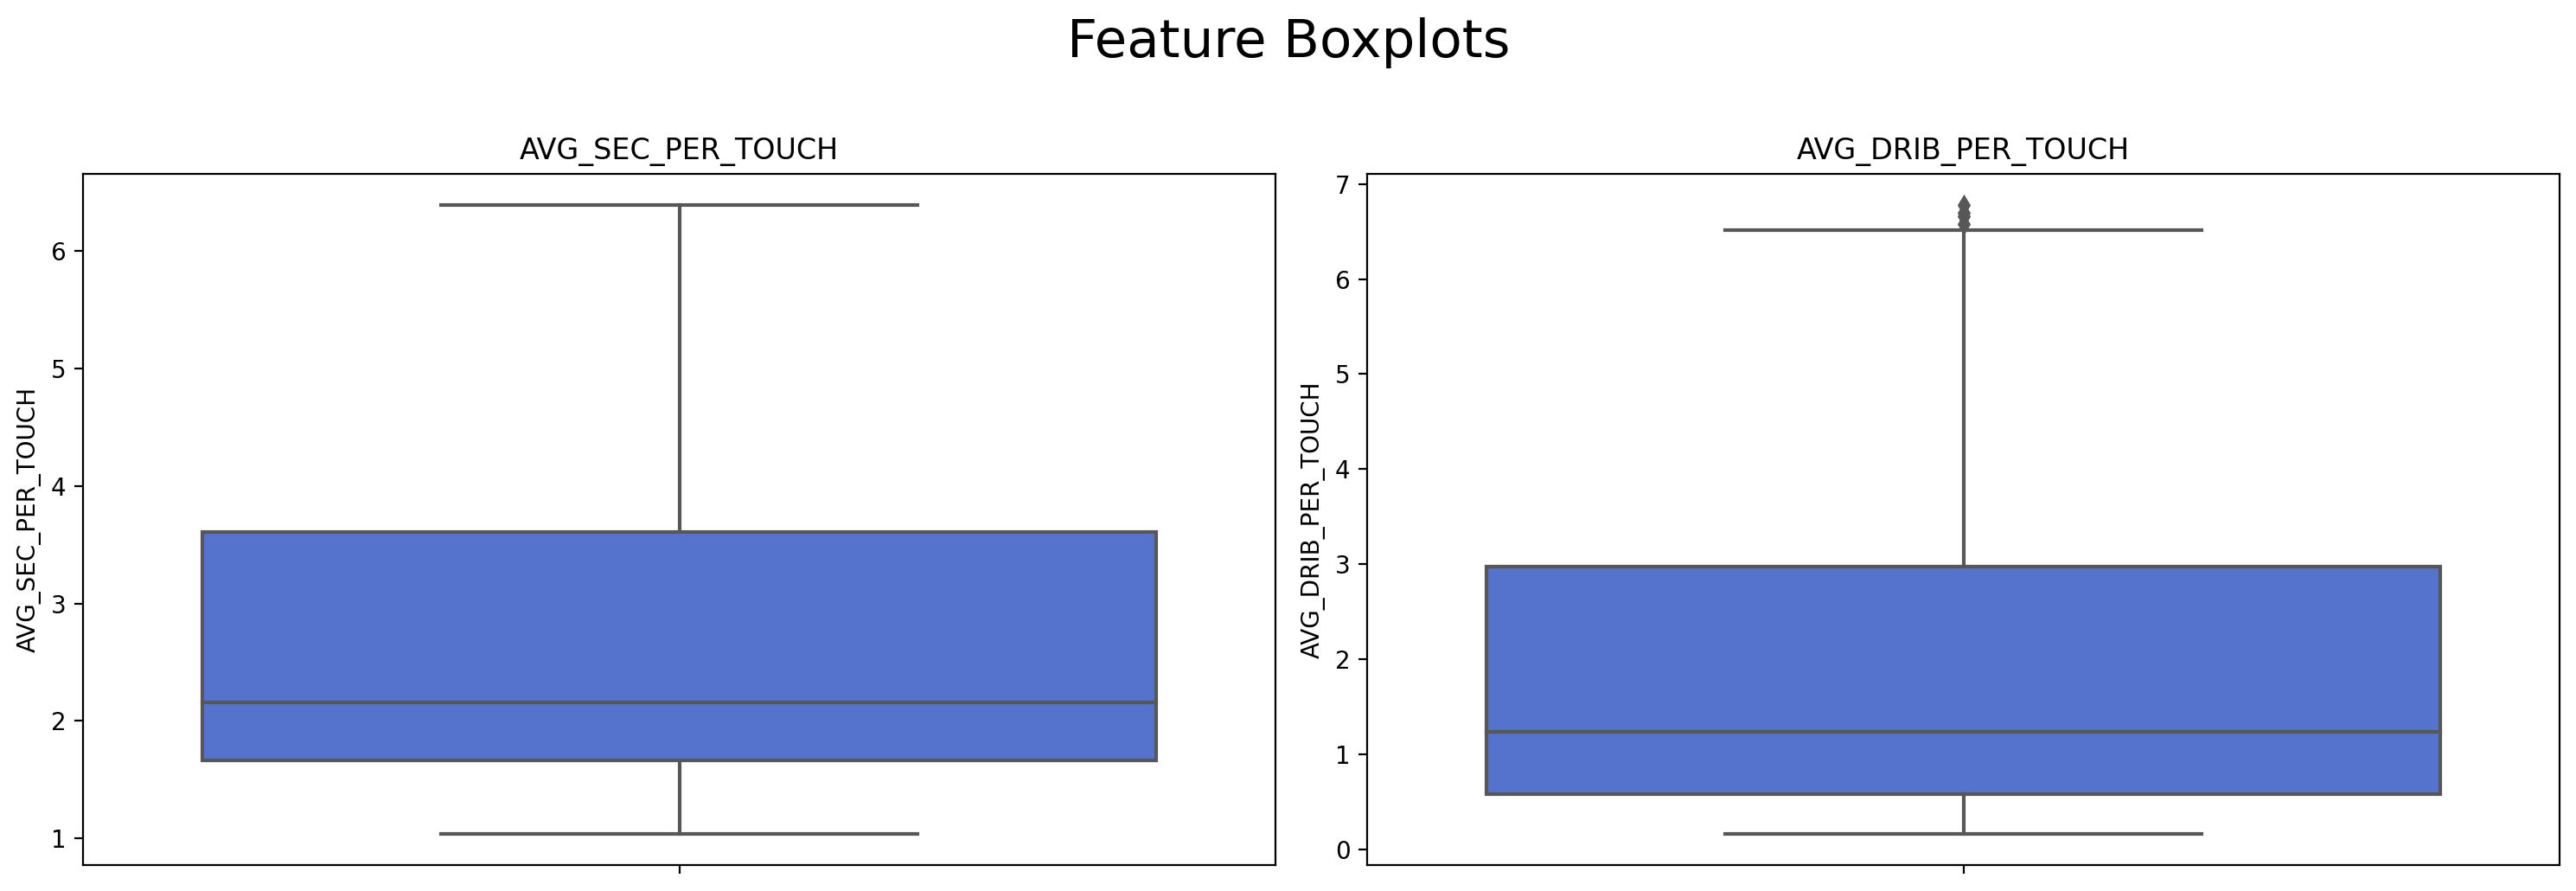

In [41]:
num_features = ['AVG_SEC_PER_TOUCH', 'AVG_DRIB_PER_TOUCH']

plot_feature_distributions(X_train, y_train, num_features, 2)
plot_feature_boxplots(X_train, y_train, num_features, 2)

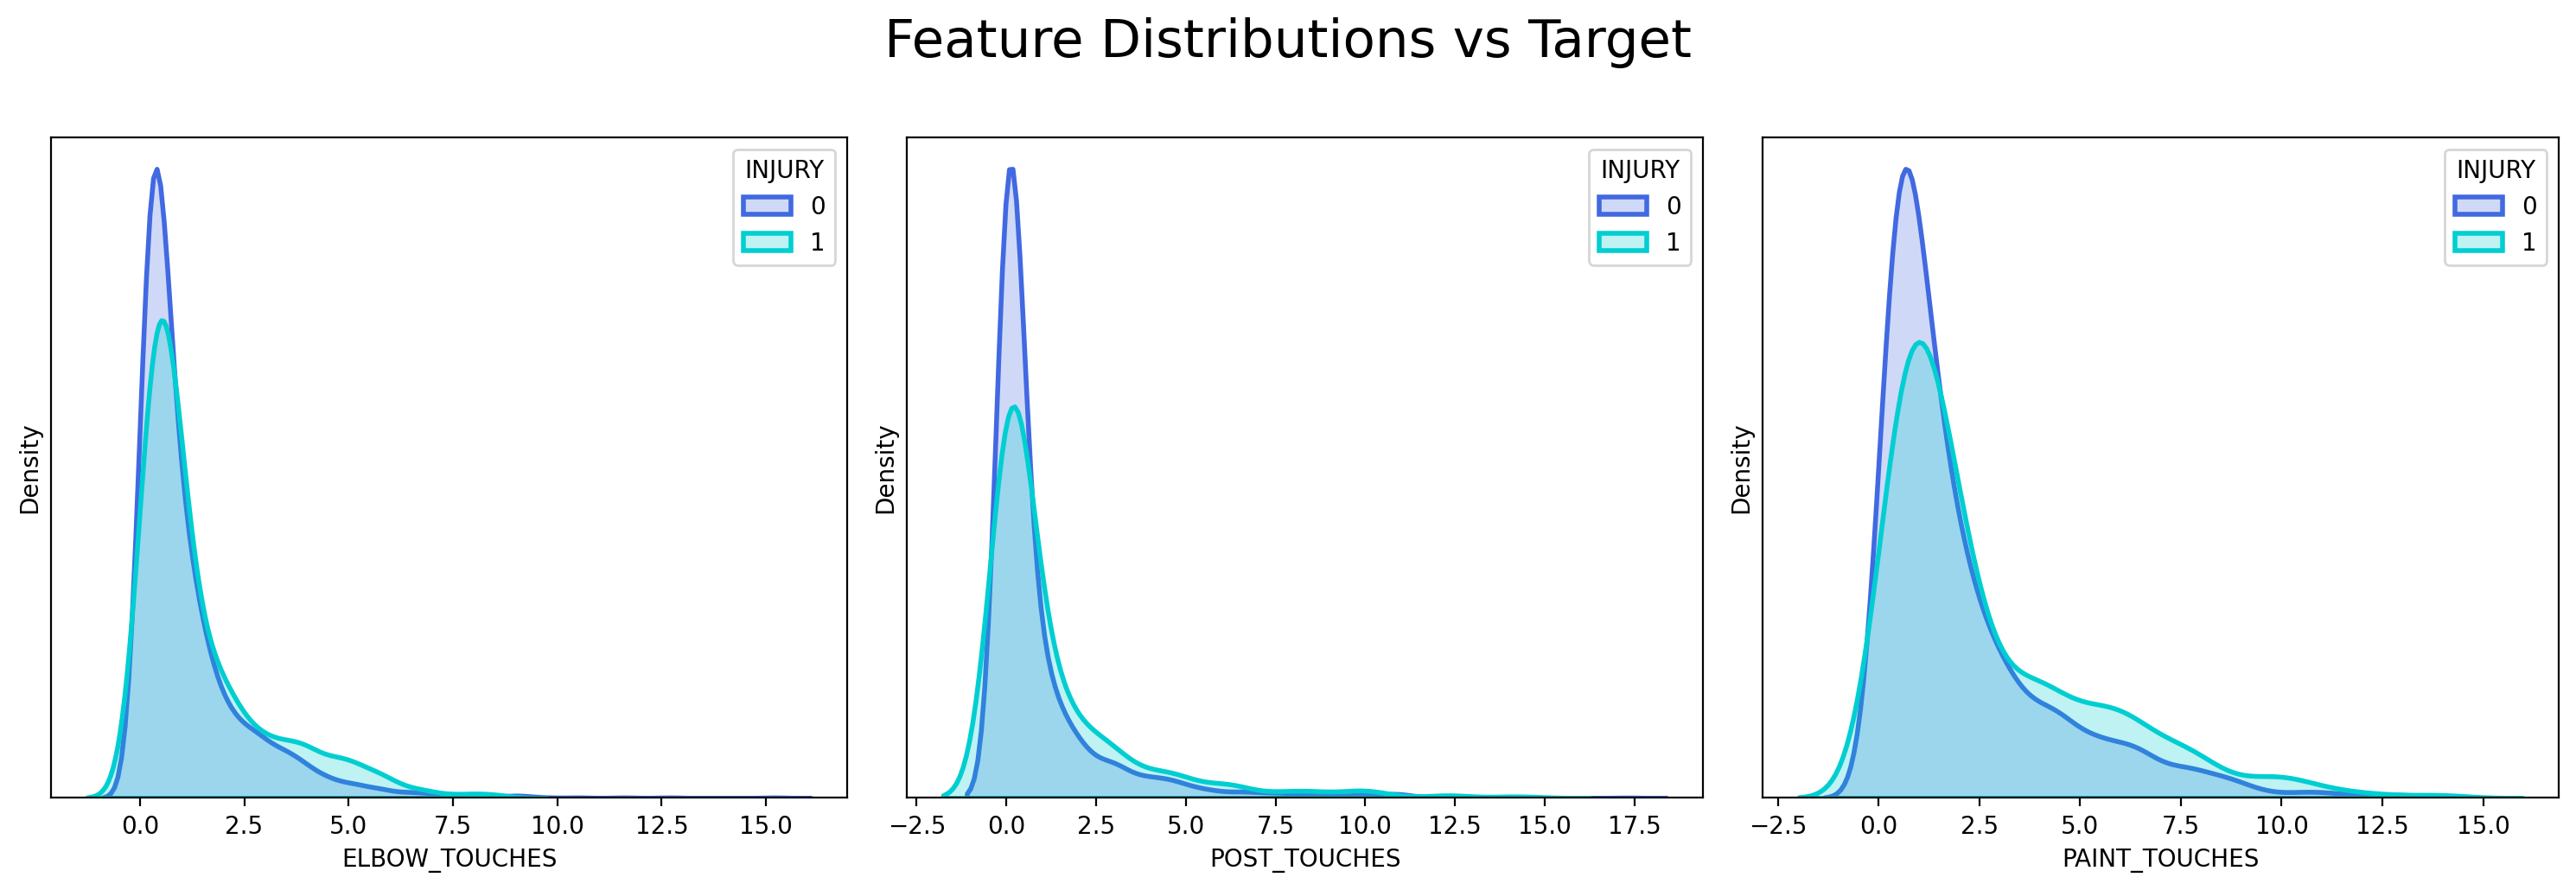

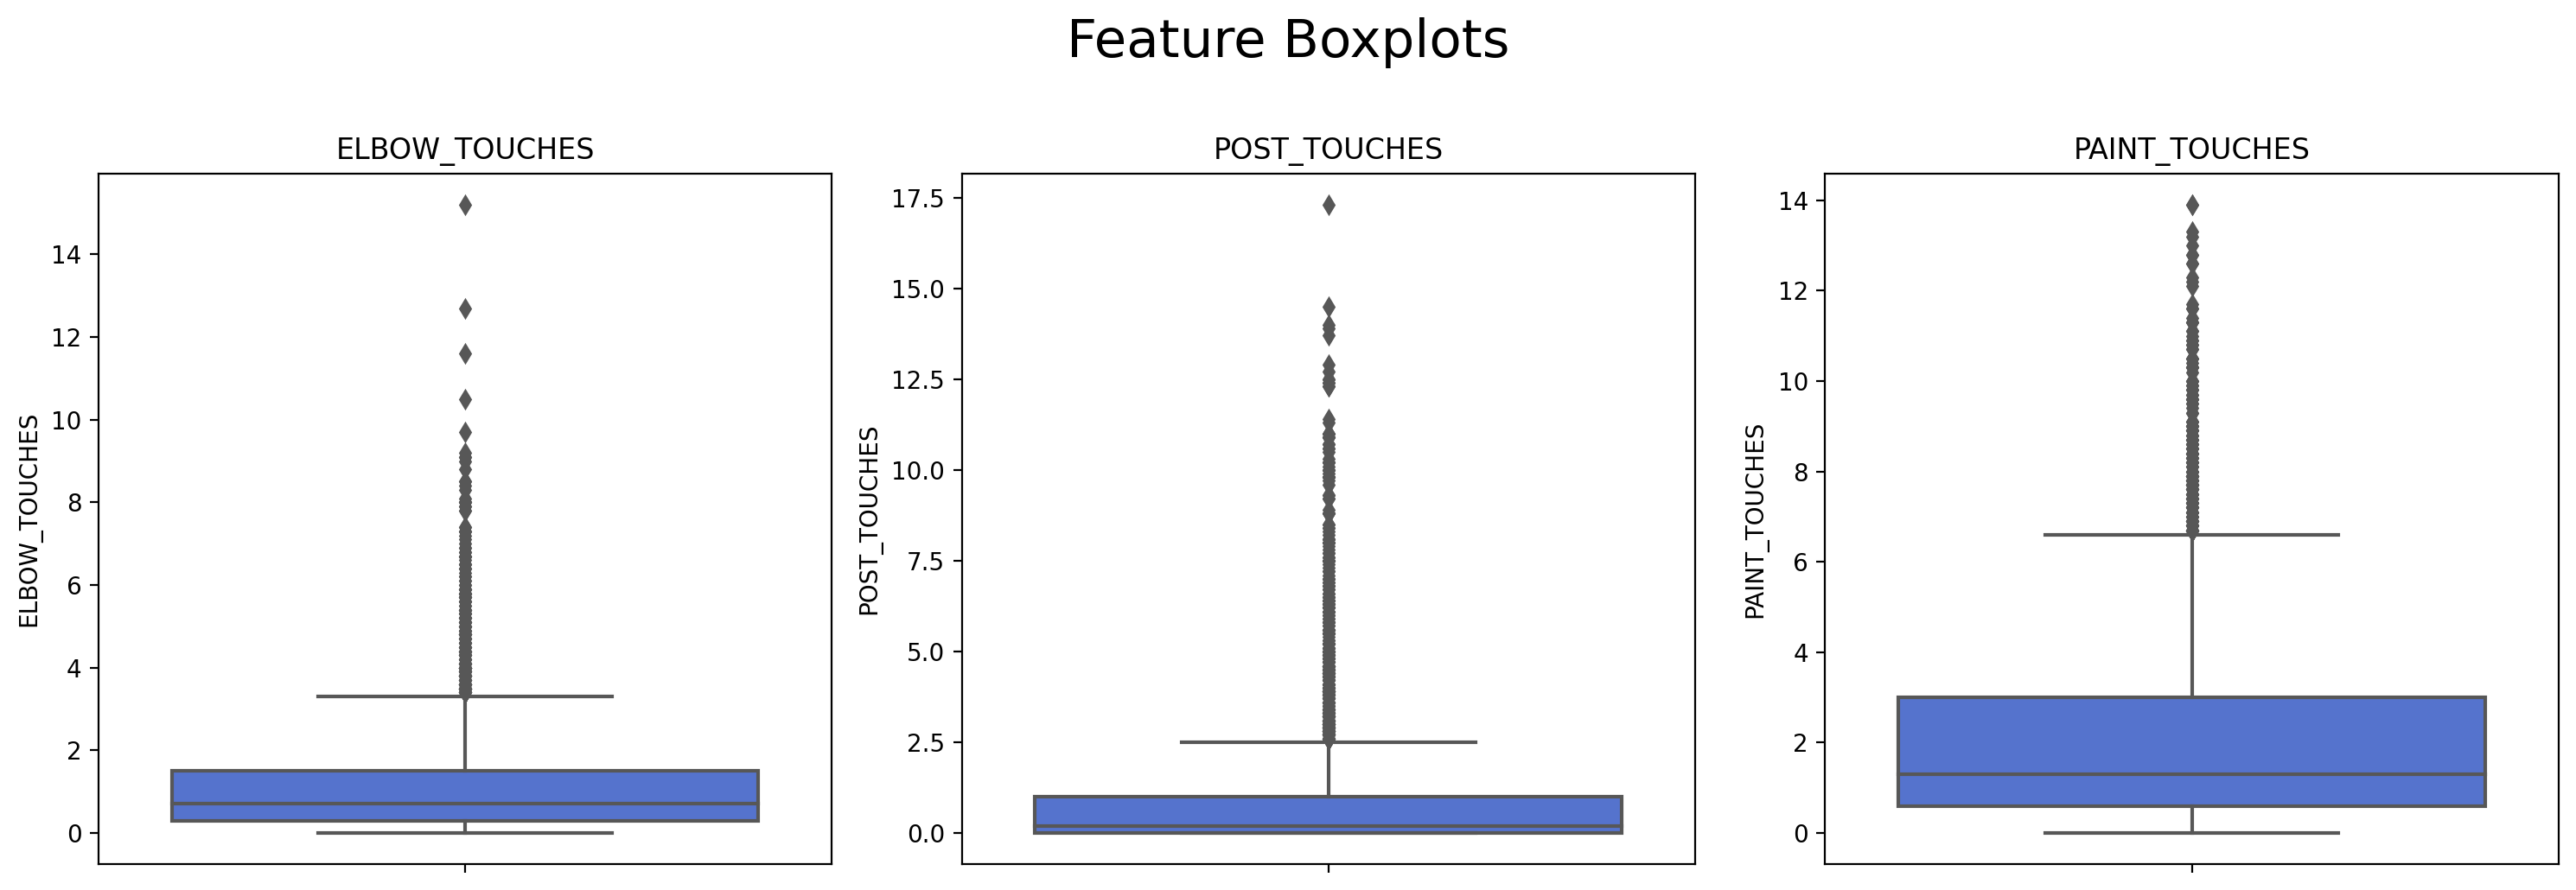

In [42]:
num_features = ['ELBOW_TOUCHES', 'POST_TOUCHES', 'PAINT_TOUCHES']

plot_feature_distributions(X_train, y_train, num_features, 3)
plot_feature_boxplots(X_train, y_train, num_features, 3)

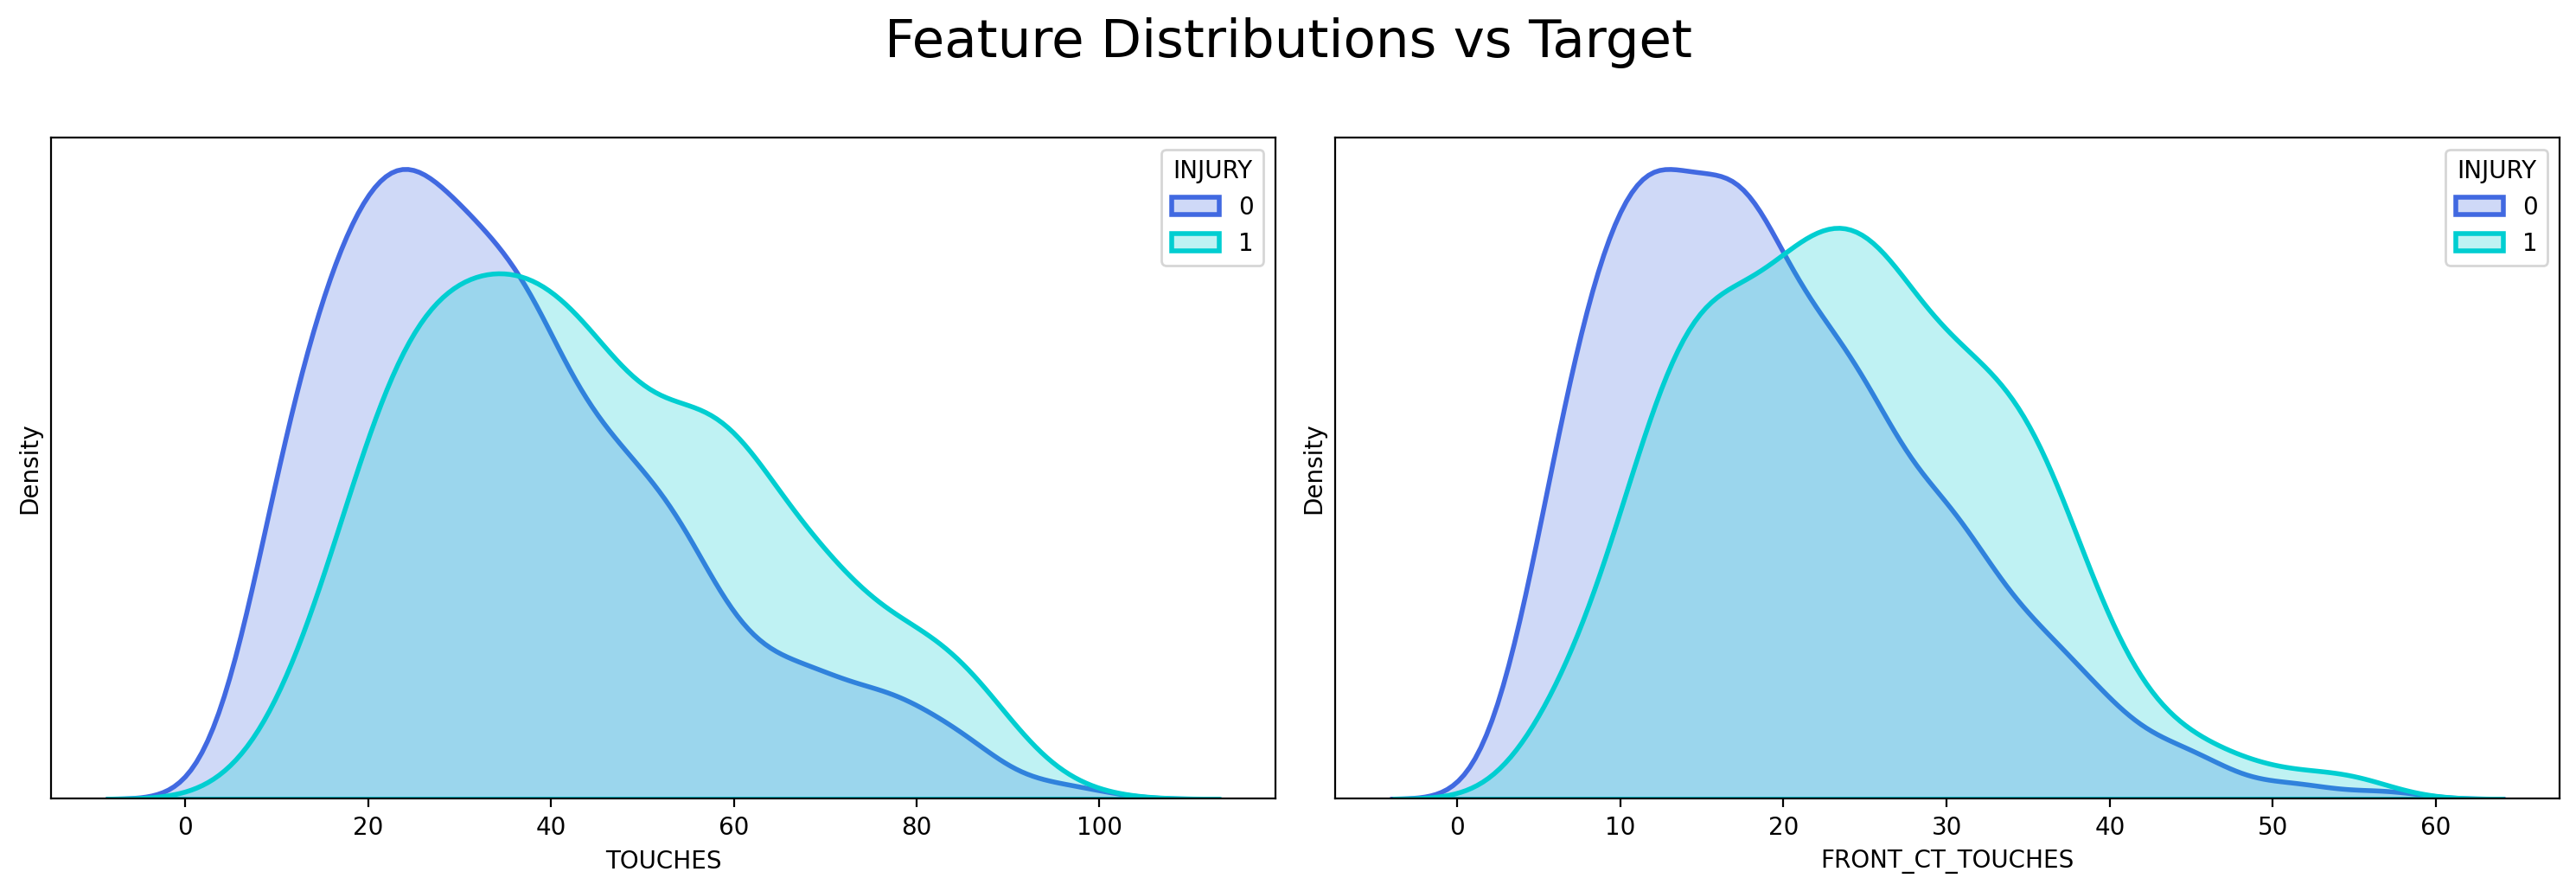

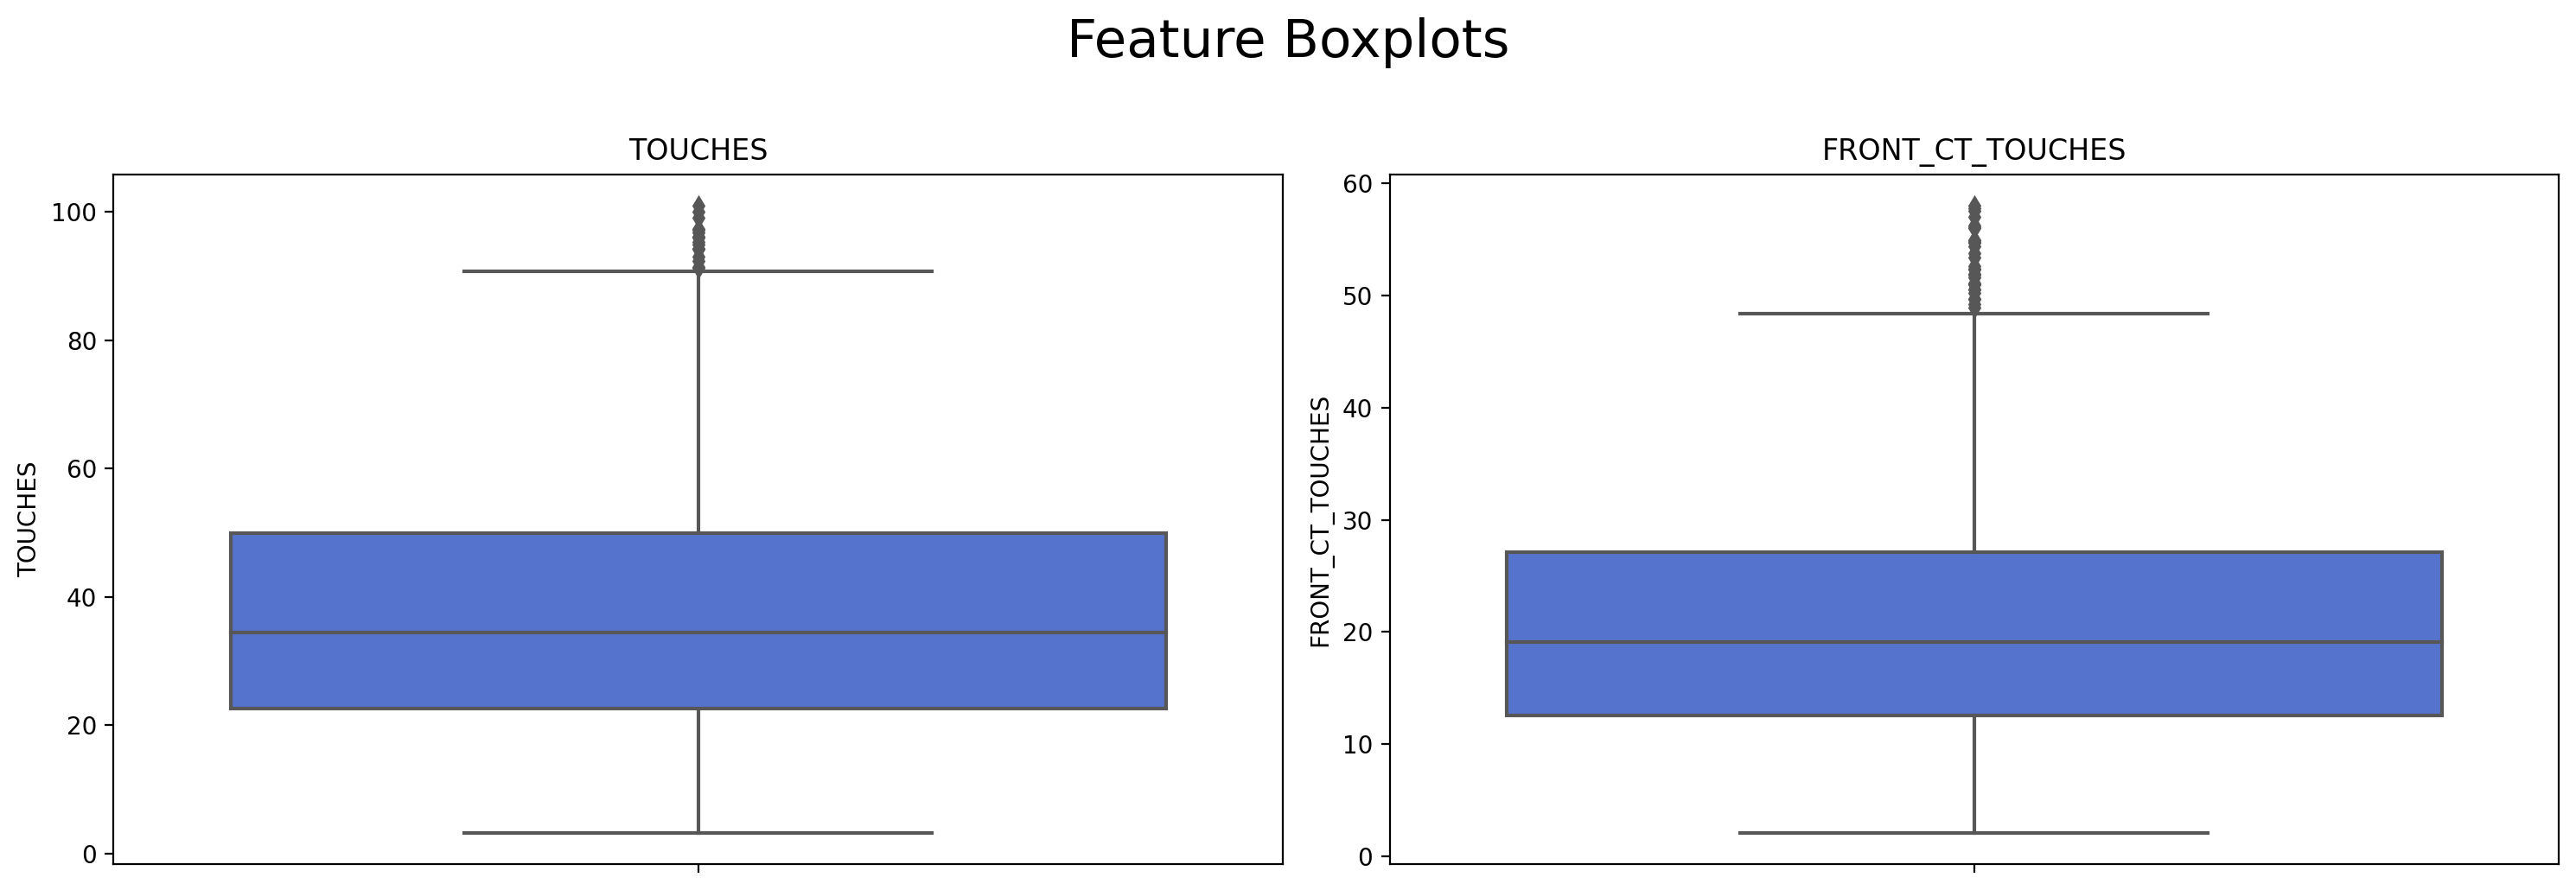

In [43]:
num_features = ['TOUCHES', 'FRONT_CT_TOUCHES']

plot_feature_distributions(X_train, y_train, num_features, 2)
plot_feature_boxplots(X_train, y_train, num_features, 2)

Based on the correlation analysis and the examination of the plotted distributions, it becomes evident which features provide similar information.

Considering the findings, I proceed to drop the redundant features. 

In [44]:
X_train = X_train.drop(['DRIVE_FGA', 'DRIVE_PASSES', 'AVG_SEC_PER_TOUCH', 'TOUCHES', 'POST_TOUCHES'], axis=1)
X_test = X_test.drop(['DRIVE_FGA', 'DRIVE_PASSES', 'AVG_SEC_PER_TOUCH', 'TOUCHES', 'POST_TOUCHES'], axis=1)

After dropping the redundant features, I proceed to examine the remaining features by generating their respective kde plots. These plots allow for a visual assessment of the distributions and provide insights into the information each feature carries.

By analyzing the kde plots, I can further assess the uniqueness and distribution characteristics of the remaining features. This step ensures that the selected features offer distinct information and helps validate their suitability for subsequent analysis tasks.

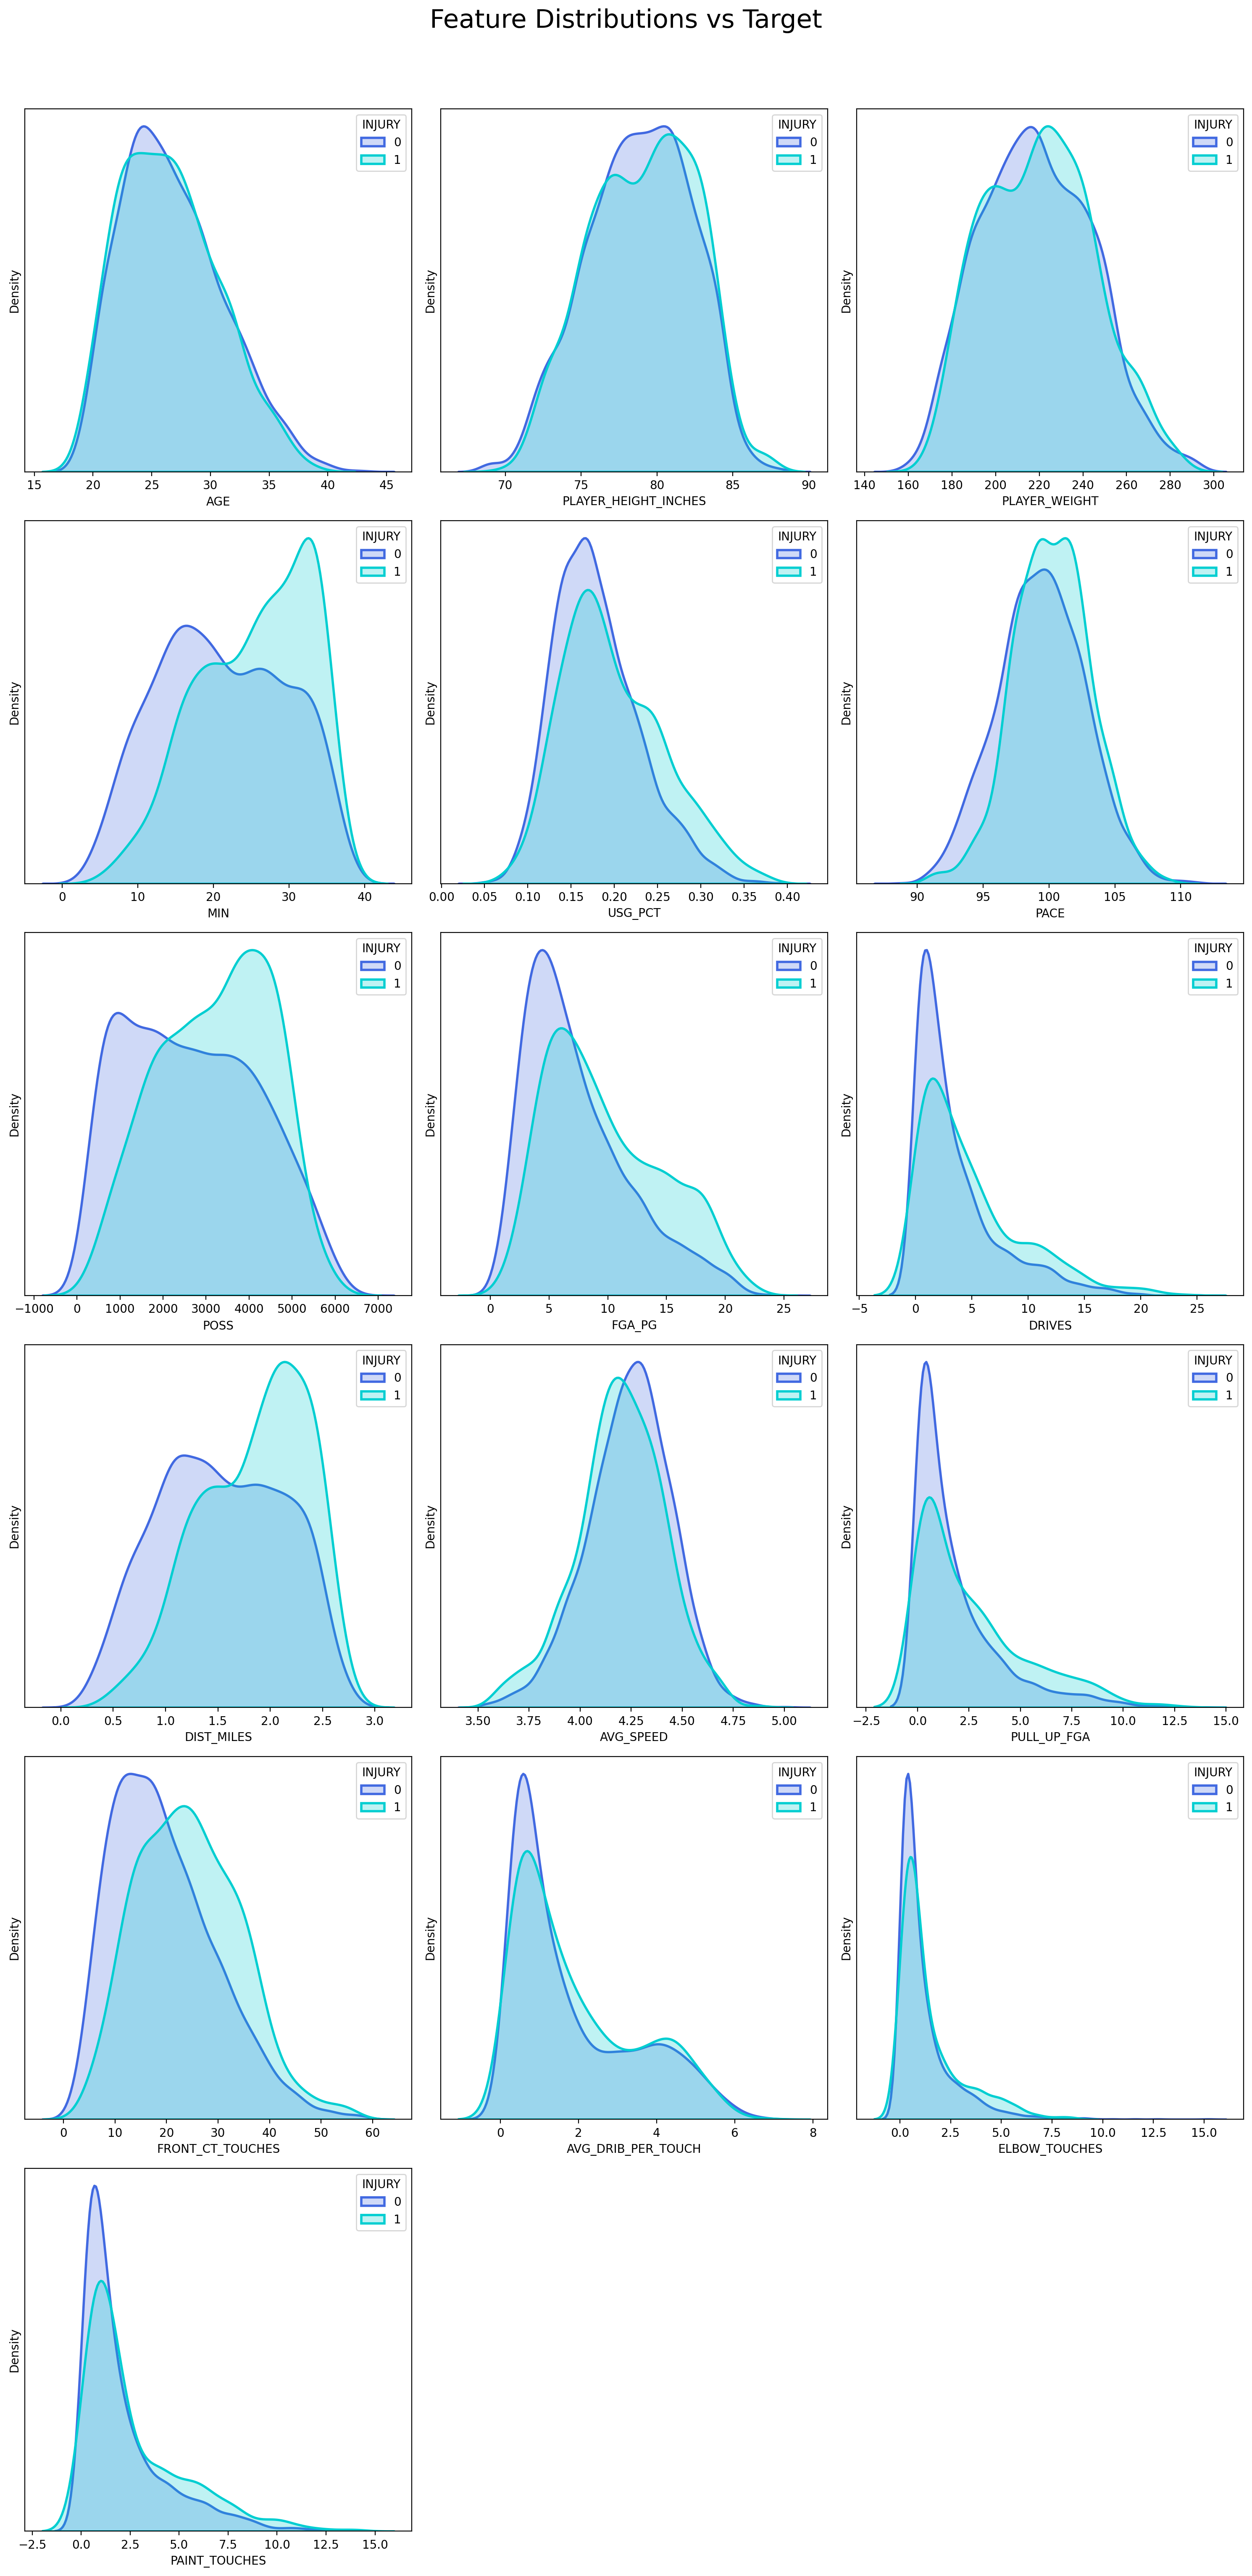

In [45]:
num_features = X_train.columns.to_list()

plot_feature_distributions(X_train, y_train, num_features, 3)

# Transformation and Scaling

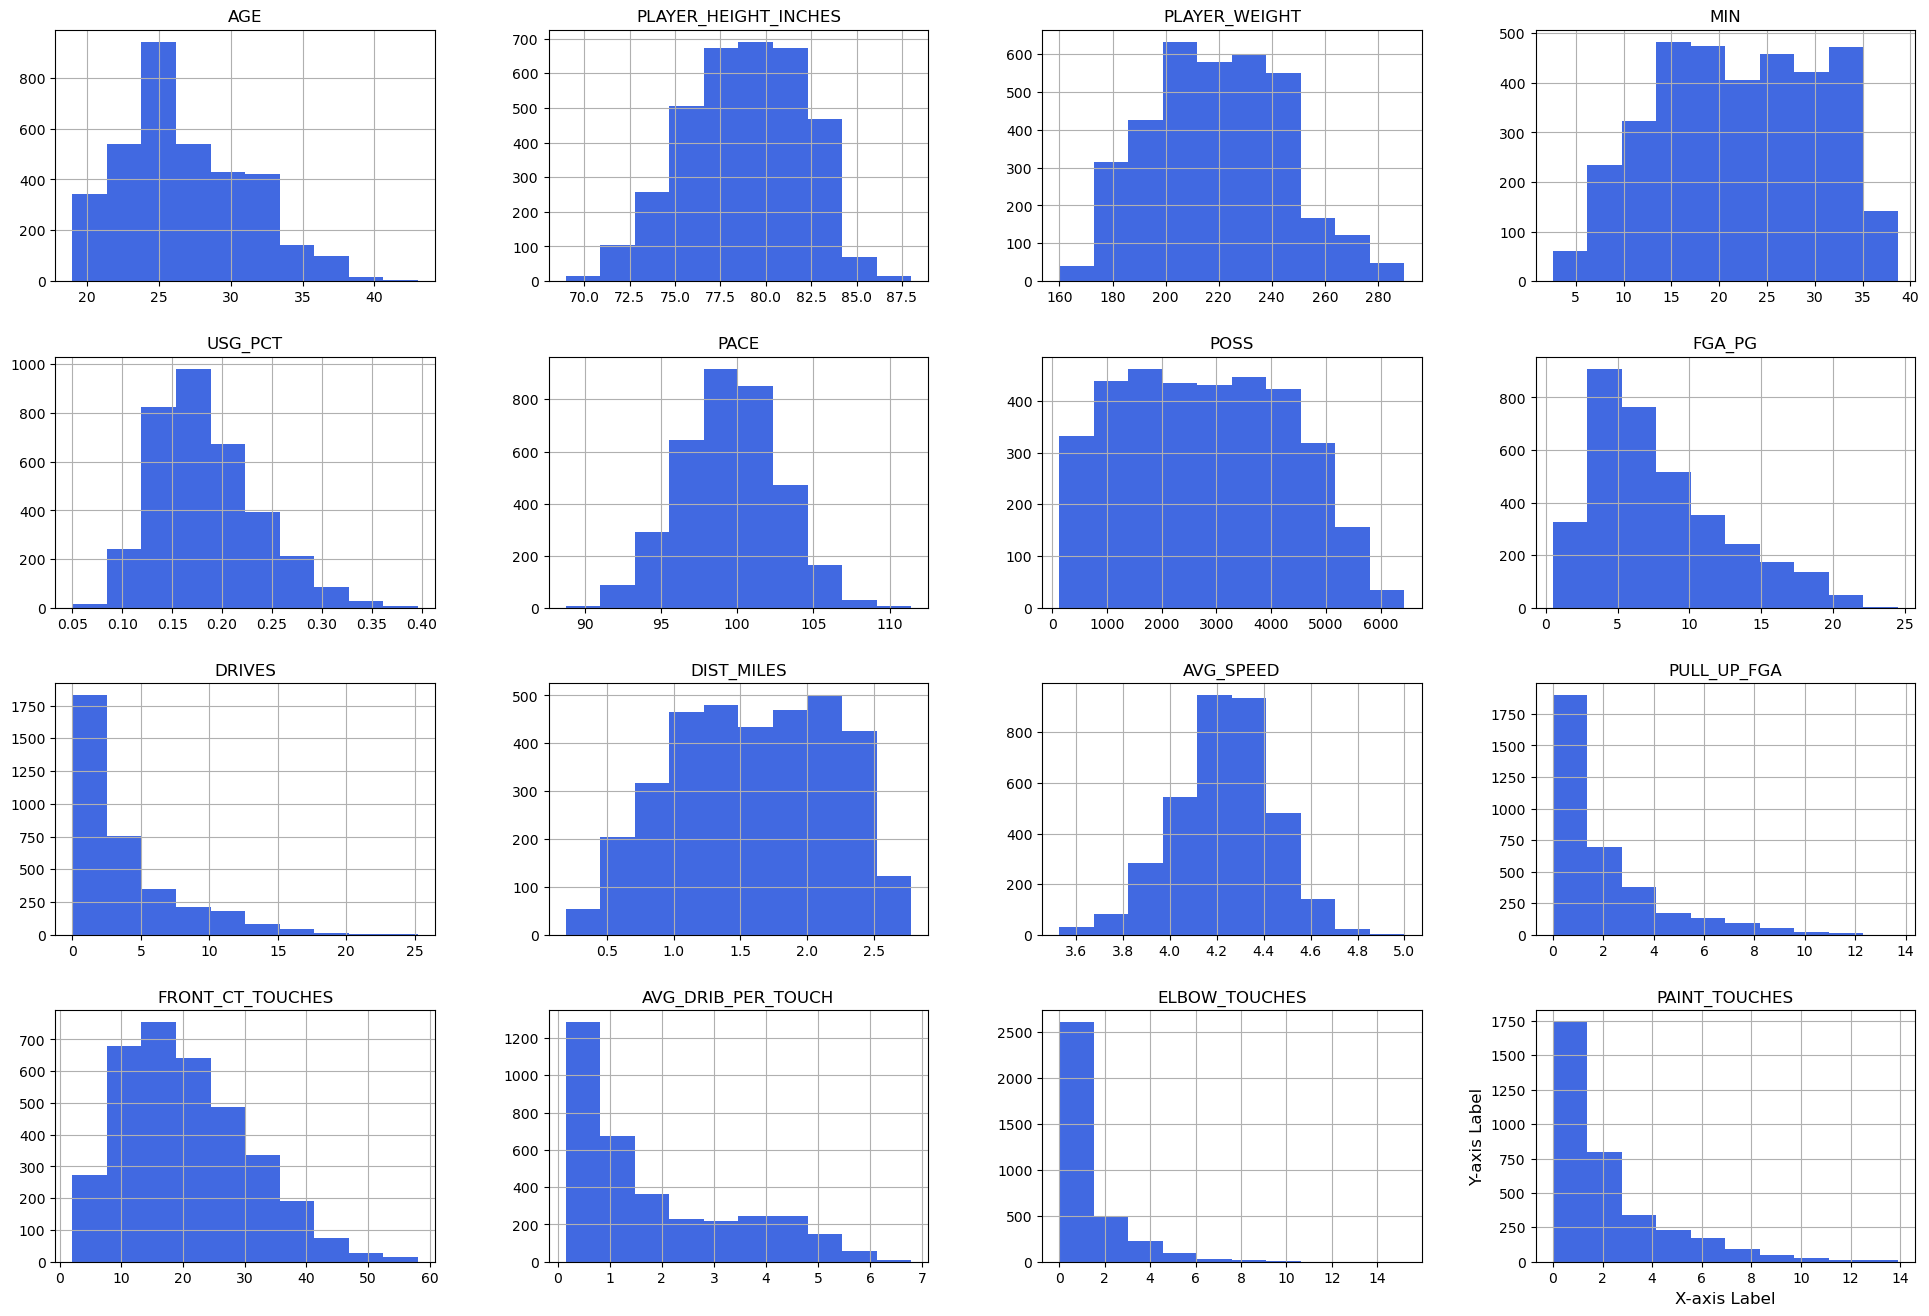

In [46]:
X_train.hist(figsize=(24, 16))

plt.xlabel('X-axis Label', fontsize=12)
plt.ylabel('Y-axis Label', fontsize=12)

plt.show()

In [47]:
skewed_features = ['AGE', 'USG_PCT', 'POSS', 'FGA_PG', 'DRIVES',
                   'PULL_UP_FGA', 'FRONT_CT_TOUCHES', 'AVG_DRIB_PER_TOUCH', 'ELBOW_TOUCHES', 'PAINT_TOUCHES']
pt = PowerTransformer(method='yeo-johnson')

X_train_skewed = X_train.copy()
X_test_skewed = X_test.copy()
pt.fit(X_train_skewed[skewed_features])

X_train_skewed_transformed = pt.transform(X_train[skewed_features])
X_test_skewed_transformed = pt.transform(X_test[skewed_features])

X_train_skewed[skewed_features] = X_train_skewed_transformed
X_test_skewed[skewed_features] = X_test_skewed_transformed

In [48]:
scaler = MinMaxScaler()

scaler.fit(X_train_skewed)

X_train_scaled = scaler.transform(X_train_skewed)
X_test_scaled = scaler.transform(X_test_skewed)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

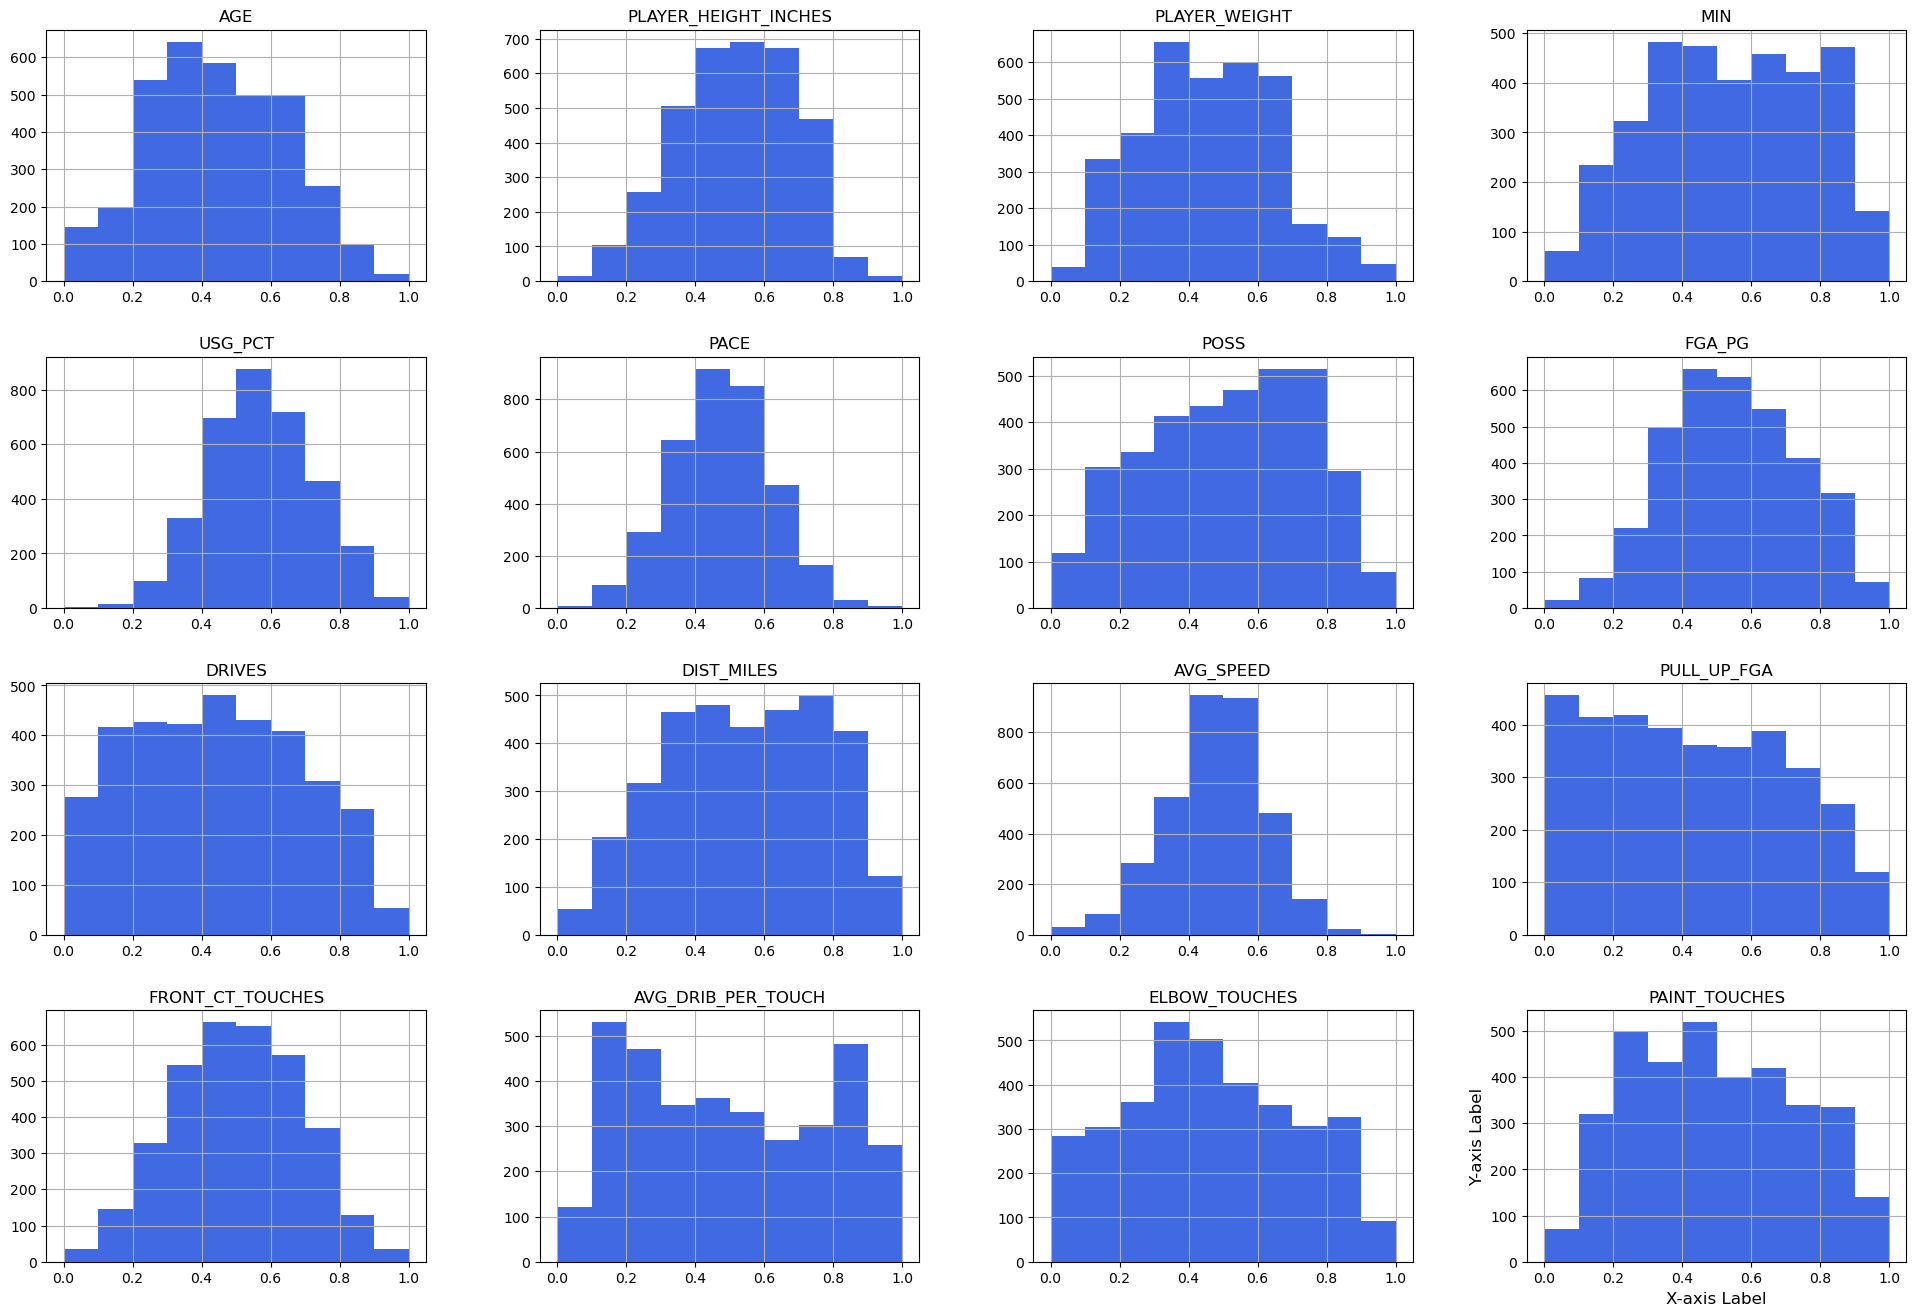

In [49]:
X_train_scaled.hist(figsize=(24, 16))

plt.xlabel('X-axis Label', fontsize=12)
plt.ylabel('Y-axis Label', fontsize=12)

plt.show()

# Model Evaluation Function

In [50]:
def plot_roc_auc(model, X, Y):
    Y_prob = model.predict_proba(X)[:, 1]

    fpr, tpr, _ = roc_curve(Y, Y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    print("AUC Score: ", roc_auc)

In [51]:
def evaluate_and_plot_cm(model, X, Y, dataset_type, threshold=0.5):
    y_probs = model.predict_proba(X)[:, 1]

    y_pred = (y_probs >= threshold).astype(int)

    cm = confusion_matrix(Y, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {dataset_type} set (Threshold: {threshold:.2f})')
    plt.show()

    print(f"Classification report for {dataset_type} set")
    print("-------------------------------------------------------")
    print(classification_report(Y, y_pred, zero_division=1))

In [52]:
def plot_feature_importances(importances, feature_names):

    importance_df = pd.DataFrame({'features': feature_names, 'importance': importances})

    importance_df = importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10,8))
    plt.barh(importance_df['features'], importance_df['importance'], color='skyblue')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.title('Feature Importances', fontsize=16)
    plt.gca().invert_yaxis()  # Reverse the order to have the most important at the top
    plt.show()

# Model Evaluation 

## Test and Validation Set Split

In [53]:
sss_valid = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for test_index, valid_index in sss_valid.split(X_test, y_test):
    X_test_scaled, X_valid_scaled = X_test_scaled.iloc[test_index], X_train_scaled.iloc[valid_index]
    X_test, X_valid = X_test.iloc[test_index], X_test.iloc[valid_index]
    y_test, y_valid = y_test.iloc[test_index], y_test.iloc[valid_index]

In [54]:
xgb_smote = xgb.XGBClassifier(random_state=42)

smote = SMOTE(random_state=42)                

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [55]:
ratio = sum(y_train == 0) / sum(y_train == 1)

## XGBoost

In [56]:
# param_grid = {
#     'max_depth': [5, 7],
#     'learning_rate': [0.1, 0.3],
#     'n_estimators': [100, 200],
#     'min_child_weight': [1, 10],
#     'scale_pos_weight': [ratio, ratio * 1.5],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
#     'reg_alpha': [0, 1],
#     'reg_lambda': [0, 1],
#     'max_delta_step': [0, 2],
#     'gamma': [0, 1]
# }

# xgb_clf = xgb.XGBClassifier(random_state=42)

# grid_search_xgb = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# grid_search_xgb.fit(X_train, y_train)

# print("Best parameters found: ", grid_search_xgb.best_params_)

Fitting 5 folds for each of 2048 candidates, totalling 10240 fits
Best parameters found:  {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 3.7472677595628414, 'subsample': 0.8}

In [57]:
params_opt_xgb = {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 
                  'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1,
                  'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1,
                  'scale_pos_weight': 3.7472677595628414, 'subsample': 0.8}

xgb_opt = xgb.XGBClassifier(**params_opt_xgb, random_state=42)

xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

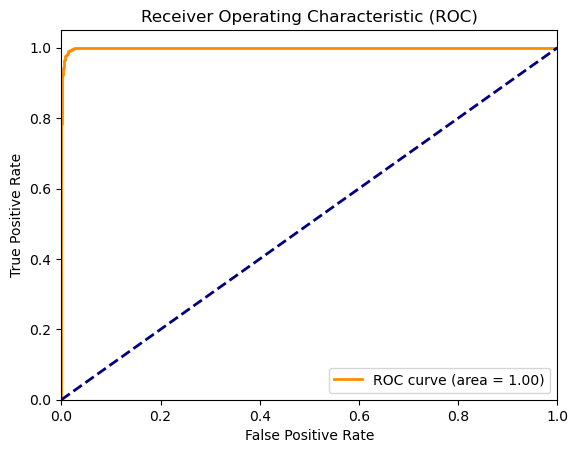

AUC Score:  0.9992509497598457


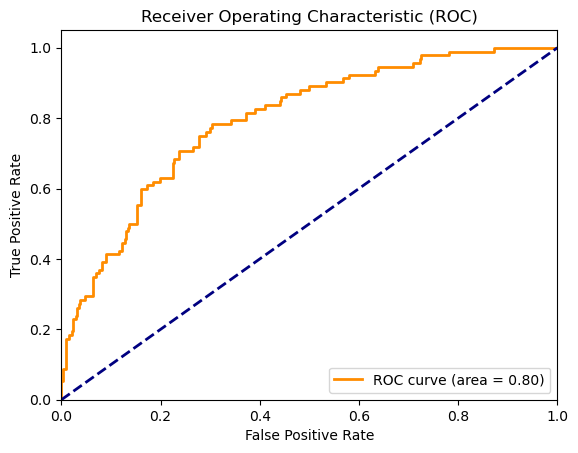

AUC Score:  0.796298643681075


In [58]:
plot_roc_auc(xgb_opt, X_train, y_train)
plot_roc_auc(xgb_opt, X_valid, y_valid)

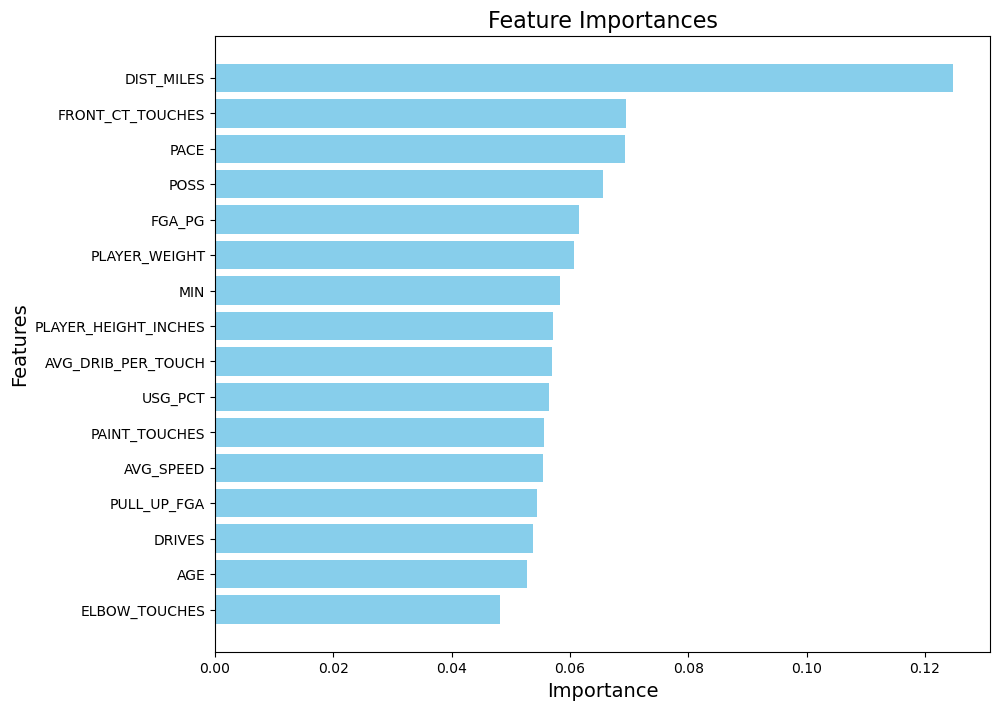

In [59]:
plot_feature_importances(xgb_opt.feature_importances_, X_train.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


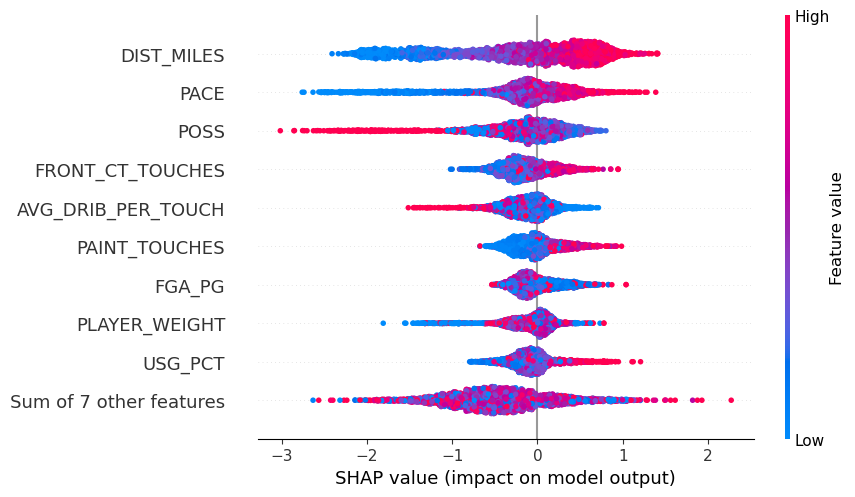

In [60]:
explainer = shap.Explainer(xgb_opt)

shap_values = explainer(X_train)

shap.plots.beeswarm(shap_values)

After conducting an extensive analysis using both Feature Importance and SHAP values, and subsequently experimenting with different combinations of features, I've arrived at the following optimized selection of features. This iterative process was crucial in ensuring that the chosen features provide the best possible input for the predictive model

In [61]:
xgb_selected = ['DIST_MILES', 'PACE', 'POSS', 'FRONT_CT_TOUCHES', 'AVG_DRIB_PER_TOUCH',
                'PAINT_TOUCHES', 'FGA_PG', 'PLAYER_WEIGHT', 'USG_PCT', 'AVG_SPEED', 'MIN']


X_train_xgb_selected = X_train.copy()[xgb_selected]
X_valid_xgb_selected = X_valid.copy()[xgb_selected]
X_test_xgb_selected = X_test.copy()[xgb_selected]

X_train_smote_xgb_selected = X_train_smote.copy()[xgb_selected]

Our initial models demonstrated a noticeable degree of overfitting. To mitigate this issue, we undertook parameter tuning; although this has made some improvements, it hasn't completely alleviated the overfitting. Further adjustments and strategies will need to be explored to sufficiently address this challenge

In [62]:
params_opt_xgb = {'colsample_bytree': 1, 'gamma': 3, 'learning_rate': 0.1, 
                  'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1,
                  'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1,
                  'scale_pos_weight': 3.7472677595628414, 'subsample': 0.8}

xgb_opt_2 = xgb.XGBClassifier(**params_opt_xgb, random_state=42)
xgb_opt_2.fit(X_train_xgb_selected, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

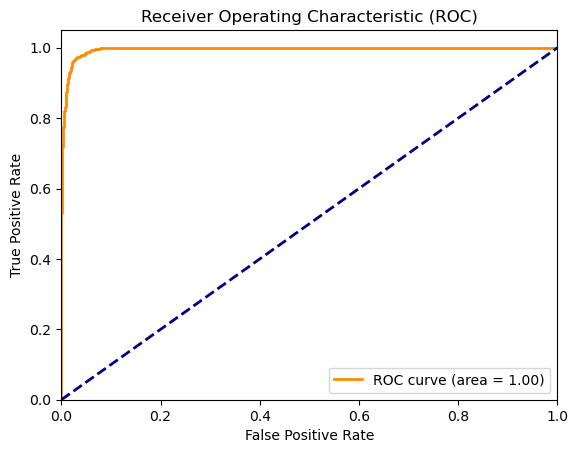

AUC Score:  0.9956944552352835


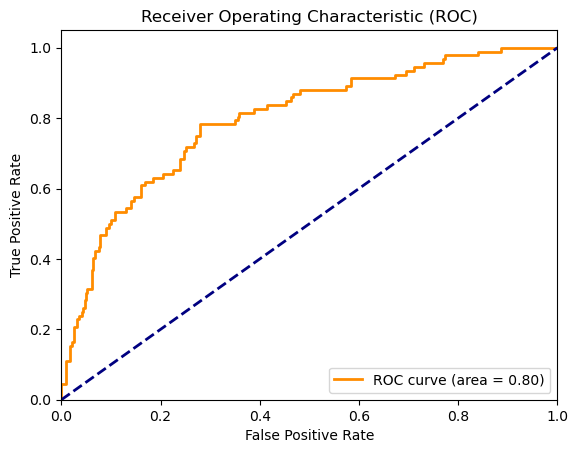

AUC Score:  0.7968056787932565


In [63]:
plot_roc_auc(xgb_opt_2, X_train_xgb_selected, y_train)
plot_roc_auc(xgb_opt_2, X_valid_xgb_selected, y_valid)

### SMOTE

Given the imbalanced nature of our dataset, we have examined the potential of the Synthetic Minority Over-sampling Technique (SMOTE) as a strategy to mitigate overfitting. The next steps involve evaluating its effectiveness and potential integration into our modeling process

In [64]:
params_opt_xgb = {'colsample_bytree': 1, 'gamma': 3, 'learning_rate': 0.1, 
                  'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1,
                  'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1,
                  'scale_pos_weight': 1, 'subsample': 0.8}

xgb_opt_2_smote = xgb.XGBClassifier(**params_opt_xgb, random_state=42)
xgb_opt_2_smote.fit(X_train_smote_xgb_selected, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

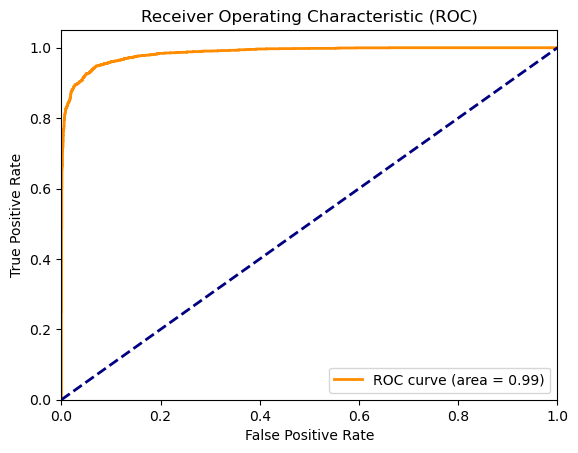

AUC Score:  0.985138786310403


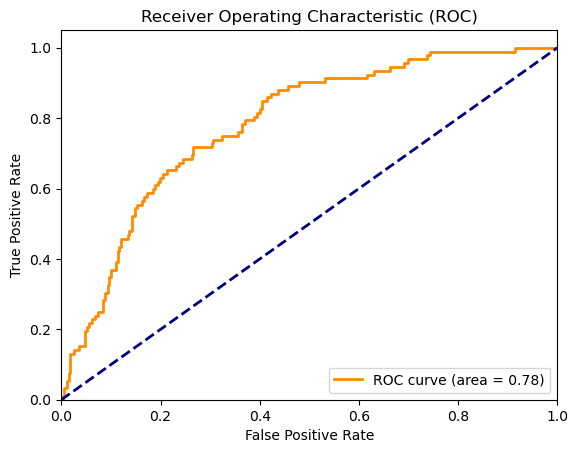

AUC Score:  0.7833692483204461


In [65]:
plot_roc_auc(xgb_opt_2_smote, X_train_smote_xgb_selected, y_train_smote)
plot_roc_auc(xgb_opt_2_smote, X_valid_xgb_selected, y_valid)

## XGBoost Random Forest

In [66]:
params_opt_xgb = {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 
                  'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1,
                  'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1,
                  'scale_pos_weight': 3.7472677595628414, 'subsample': 0.8}

xgbrf_opt = xgb.XGBRFClassifier(**params_opt_xgb, random_state=42)

xgbrf_opt.fit(X_train, y_train)

XGBRFClassifier(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bytree=1.0,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=1, gpu_id=-1,
                grow_policy='depthwise', importance_type=None,
                interaction_constraints='', learning_rate=0.1, max_bin=256,
                max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
                max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=200, n_jobs=0,
                num_parallel_tree=200, objective='binary:logistic',
                predictor='auto', random_state=42, ...)

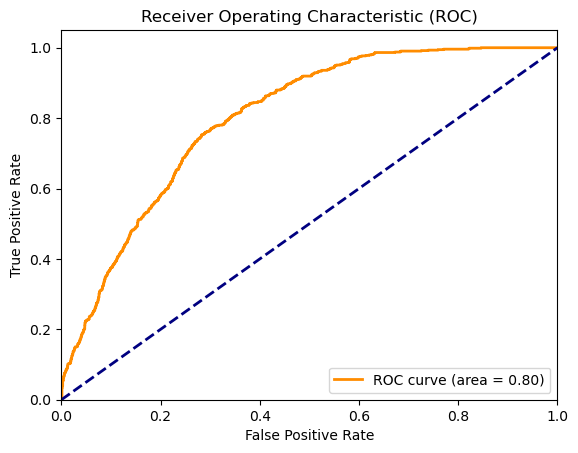

AUC Score:  0.8002135092007673


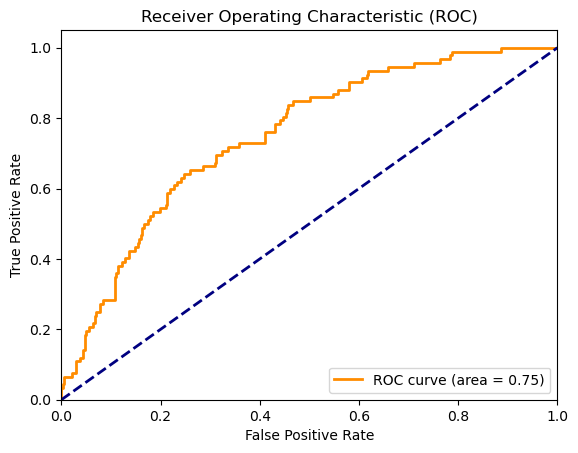

AUC Score:  0.750728862973761


In [67]:
plot_roc_auc(xgbrf_opt, X_train, y_train)
plot_roc_auc(xgbrf_opt, X_valid, y_valid)

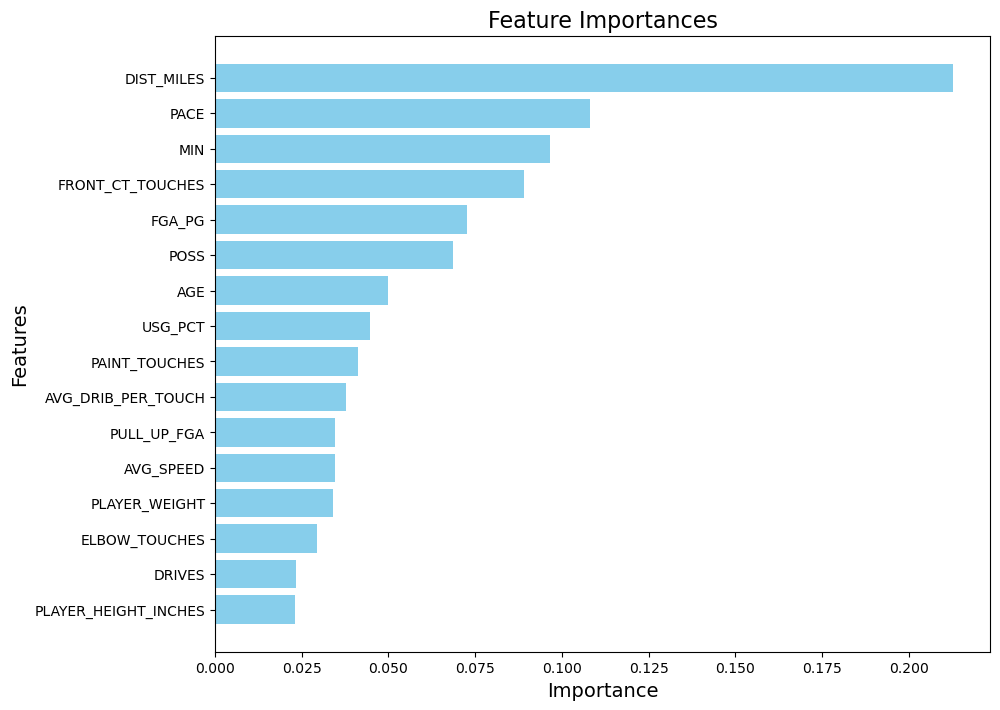

In [68]:
plot_feature_importances(xgbrf_opt.feature_importances_, X_train.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


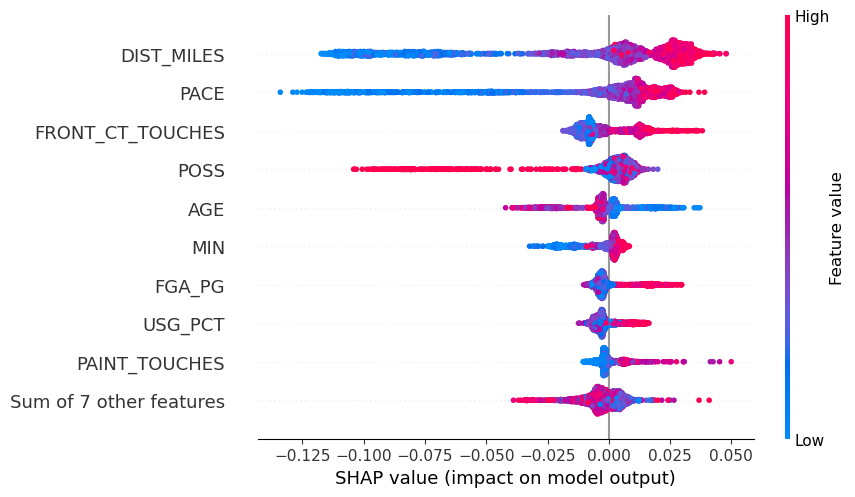

In [69]:
explainer_xgbrf = shap.Explainer(xgbrf_opt)

shap_values_xgbrf = explainer_xgbrf(X_train)

shap.plots.beeswarm(shap_values_xgbrf)

In [70]:
xgbrf_selected = ['DIST_MILES', 'PACE', 'POSS', 'FRONT_CT_TOUCHES', 'AGE',
                  'MIN', 'FGA_PG', 'USG_PCT', 'PAINT_TOUCHES']

X_train_xgbrf_selected = X_train.copy()[xgbrf_selected]
X_valid_xgbrf_selected = X_valid.copy()[xgbrf_selected]
X_test_xgbrf_selected = X_test.copy()[xgbrf_selected]

X_train_smote_xgbrf_selected = X_train_smote.copy()[xgbrf_selected]

In [71]:
params_opt_xgb = {'colsample_bytree': 1, 'gamma': 3, 'learning_rate': 0.1, 
                  'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1,
                  'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1,
                  'scale_pos_weight': 3.7472677595628414, 'subsample': 0.8}

xgbrf_opt_2 = xgb.XGBClassifier(**params_opt_xgb, random_state=42)
xgbrf_opt_2.fit(X_train_xgbrf_selected, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

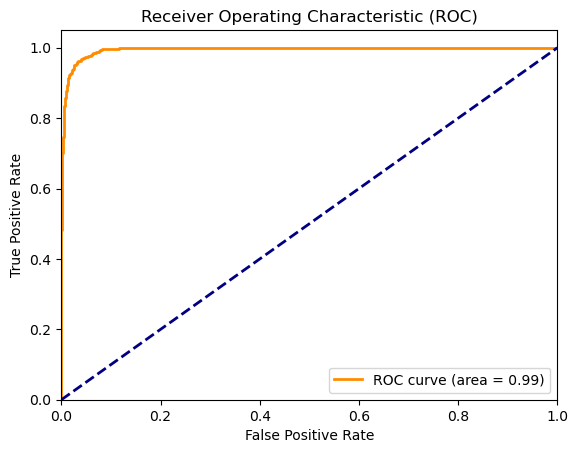

AUC Score:  0.9948014718040358


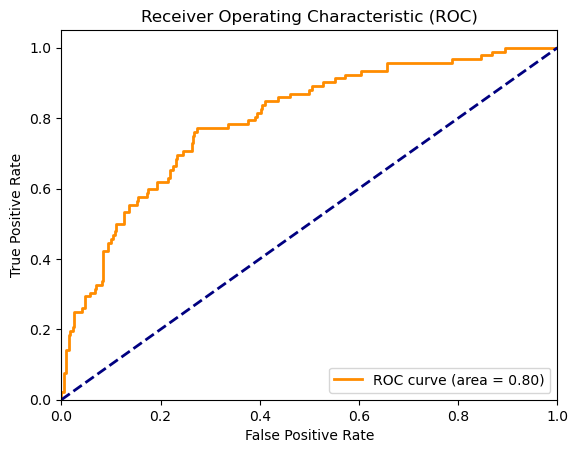

AUC Score:  0.7954430219292685


In [72]:
plot_roc_auc(xgbrf_opt_2, X_train_xgbrf_selected, y_train)
plot_roc_auc(xgbrf_opt_2, X_valid_xgbrf_selected, y_valid)

### SMOTE

In [73]:
params_opt_xgb = {'colsample_bytree': 1, 'gamma': 3, 'learning_rate': 0.1, 
                  'max_delta_step': 2, 'max_depth': 5, 'min_child_weight': 1,
                  'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1,
                  'scale_pos_weight': 1, 'subsample': 0.8}

xgbrf_opt_2_smote = xgb.XGBClassifier(**params_opt_xgb, random_state=42)
xgbrf_opt_2_smote.fit(X_train_smote_xgbrf_selected, y_train_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=3, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=2,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42, ...)

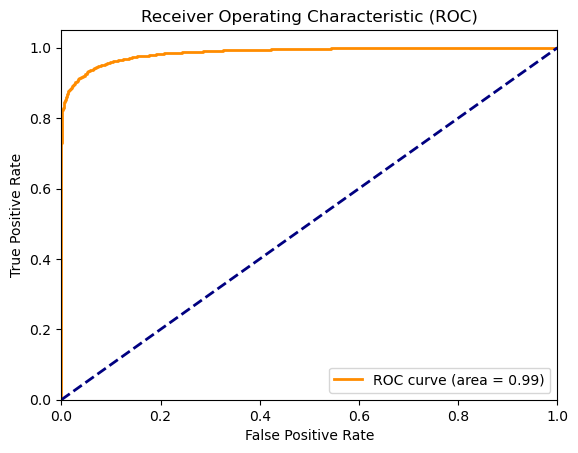

AUC Score:  0.9861465548669339


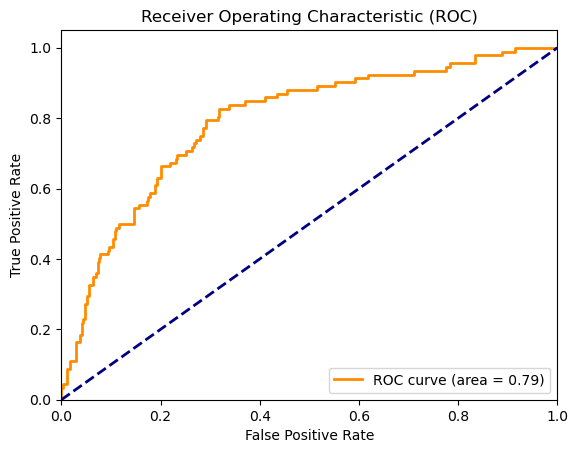

AUC Score:  0.7921156040055775


In [74]:
plot_roc_auc(xgbrf_opt_2_smote, X_train_smote_xgbrf_selected, y_train_smote)
plot_roc_auc(xgbrf_opt_2_smote, X_valid_xgbrf_selected, y_valid)

## Random Forest

In [75]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False],
#     'class_weight': [None, 'balanced', 'balanced_subsample']
# }

# rf_clf = RandomForestClassifier(random_state=42)                        

# grid_search_rf_clf = GridSearchCV(estimator=rf_clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# grid_search_rf_clf.fit(X_train, y_train)

# print("Best parameters found: ", grid_search_rf_clf.best_params_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
Best parameters found:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

In [76]:
params_opt_rf = {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20,
                 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

rf_opt = RandomForestClassifier(**params_opt_rf, random_state=42)

rf_opt.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, n_estimators=300, random_state=42)

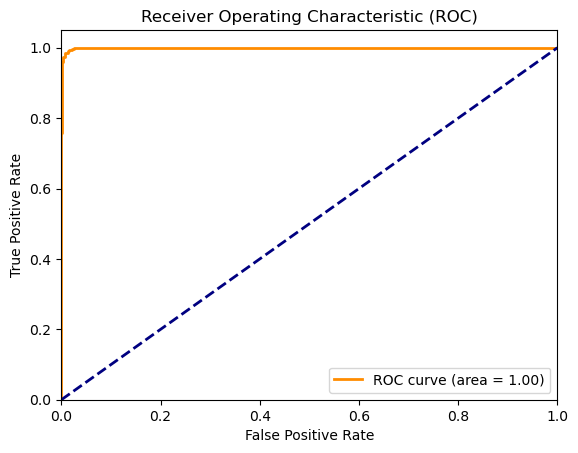

AUC Score:  0.999381933944128


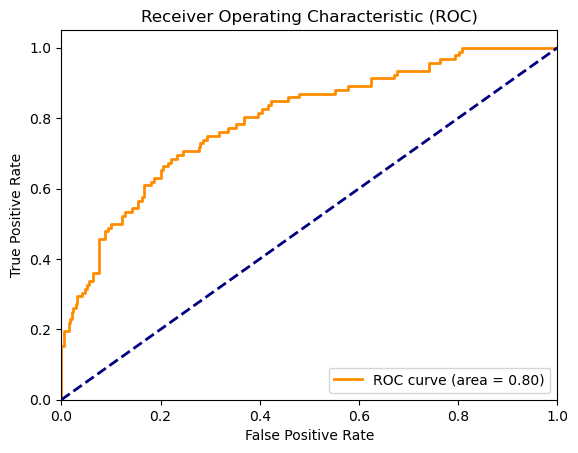

AUC Score:  0.7956331600963367


In [77]:
plot_roc_auc(rf_opt, X_train, y_train)
plot_roc_auc(rf_opt, X_valid, y_valid)

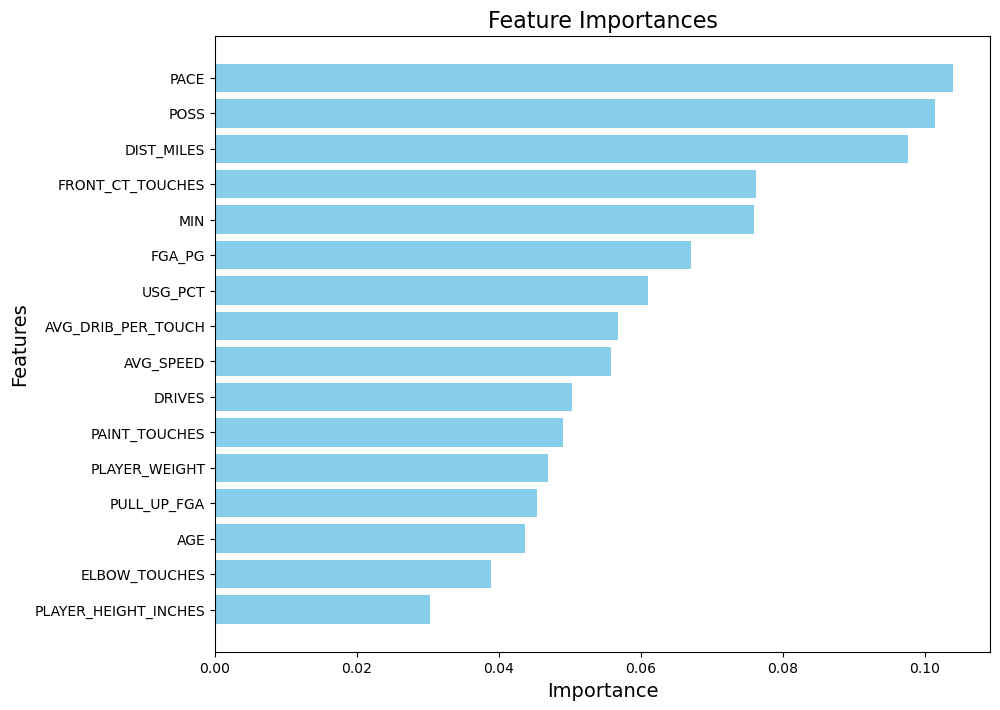

In [78]:
plot_feature_importances(rf_opt.feature_importances_, X_train.columns)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


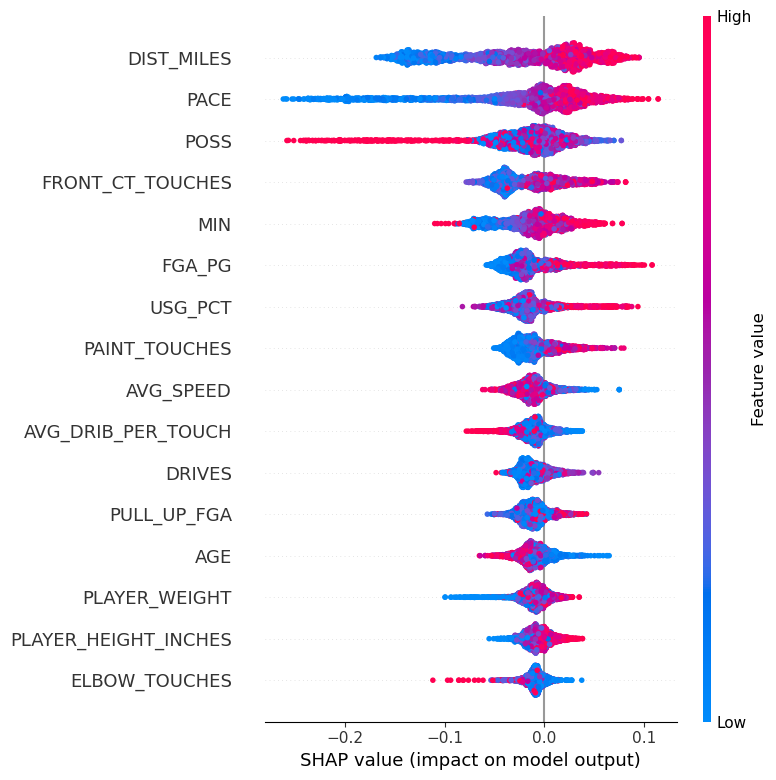

In [79]:
explainer = shap.TreeExplainer(rf_opt)

shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values[1], X_train)

In [80]:
rf_selected = ['DIST_MILES', 'PACE', 'POSS', 'FRONT_CT_TOUCHES', 'MIN', 'FGA_PG',
            'USG_PCT', 'PAINT_TOUCHES', 'AVG_SPEED', 'AVG_DRIB_PER_TOUCH']


X_train_rf_selected = X_train.copy()[rf_selected]
X_valid_rf_selected = X_valid.copy()[rf_selected]
X_test_rf_selected = X_test.copy()[rf_selected]

X_train_smote_rf_selected = X_train_smote.copy()[rf_selected]

In [81]:
params_opt_rf = {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20,
                 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

rf_opt_2 = RandomForestClassifier(**params_opt_rf, random_state=42)

rf_opt_2.fit(X_train_rf_selected, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, n_estimators=300, random_state=42)

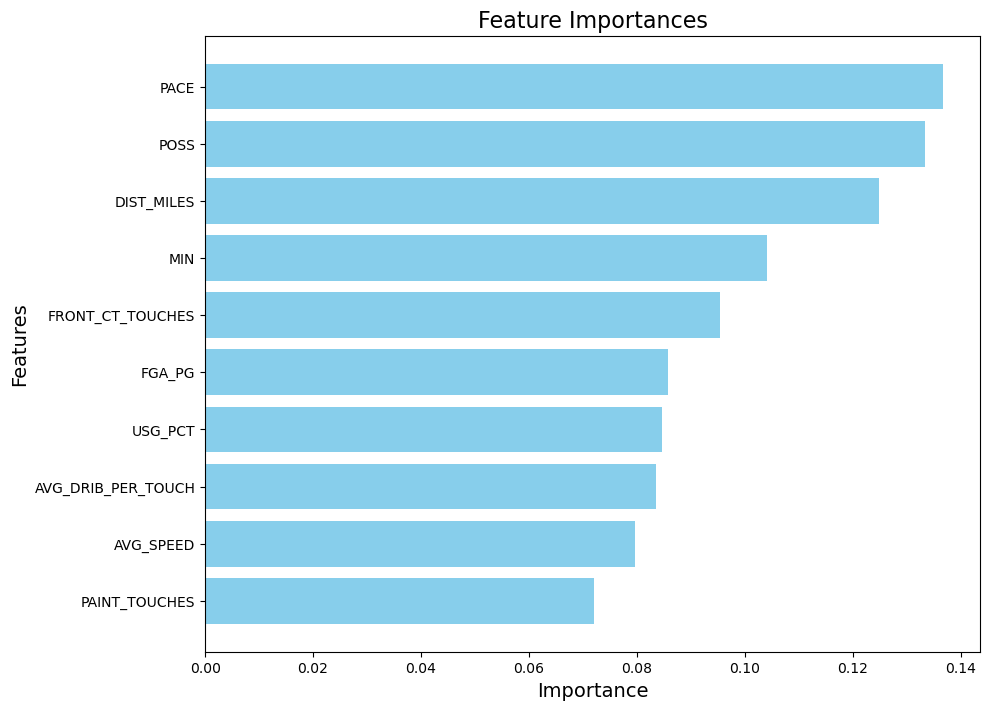

In [82]:
plot_feature_importances(rf_opt_2.feature_importances_, X_train[rf_selected].columns)

In [83]:
rf_opt_2.feature_importances_

array([0.1247882 , 0.13674124, 0.1333653 , 0.09538118, 0.10400137,
       0.08574381, 0.08472132, 0.07205066, 0.07965443, 0.08355248])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


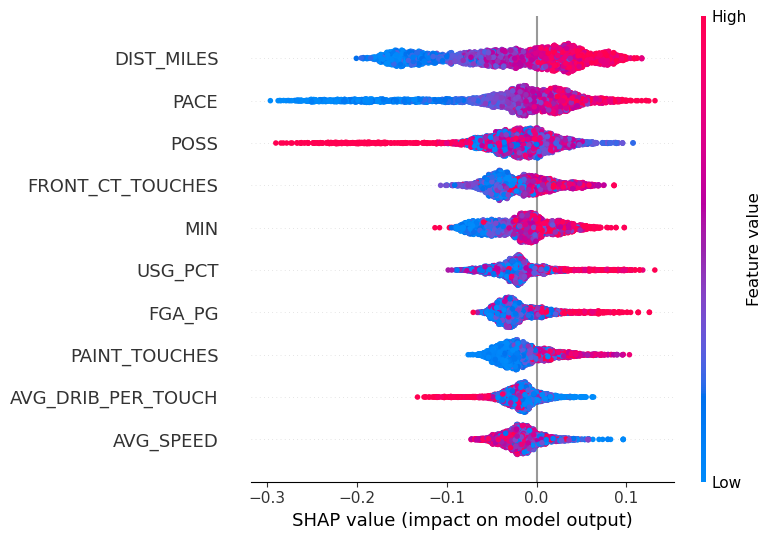

In [84]:
explainer = shap.TreeExplainer(rf_opt_2)

shap_values = explainer.shap_values(X_train[rf_selected])

shap.summary_plot(shap_values[1], X_train[rf_selected])

In [85]:
import pickle

# Save the shap_values using pickle
with open('shap_values.pkl', 'wb') as file:
    pickle.dump(shap_values, file)

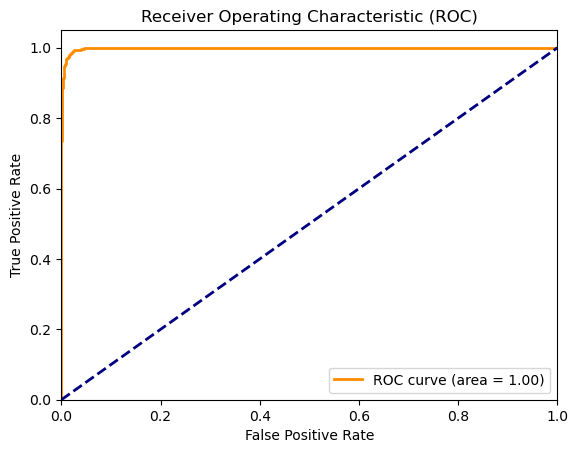

AUC Score:  0.99868916207973


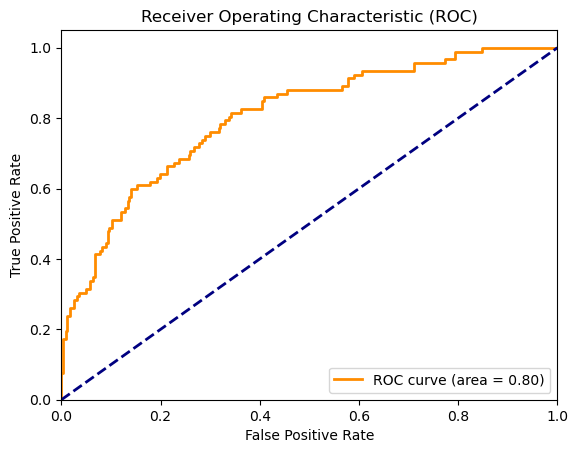

AUC Score:  0.8047281024210925


In [80]:
plot_roc_auc(rf_opt_2, X_train_rf_selected, y_train)
plot_roc_auc(rf_opt_2, X_valid_rf_selected, y_valid)

### SMOTE

In [81]:
params_opt_rf = {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20,
                 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}

rf_opt_2_smote = RandomForestClassifier(**params_opt_rf, random_state=42)

rf_opt_2_smote.fit(X_train_smote_rf_selected, y_train_smote)

RandomForestClassifier(class_weight='balanced', max_depth=20,
                       min_samples_leaf=4, n_estimators=300, random_state=42)

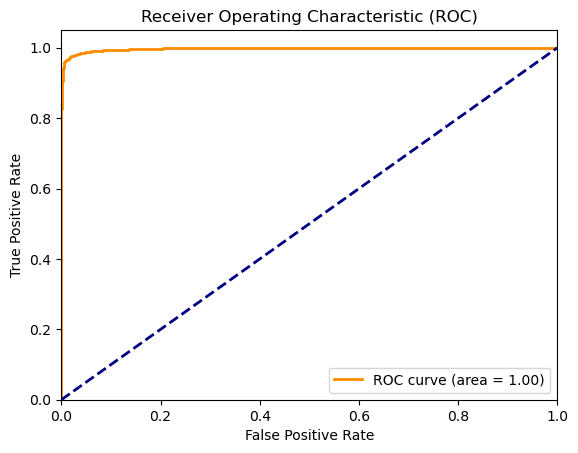

AUC Score:  0.997506927453556


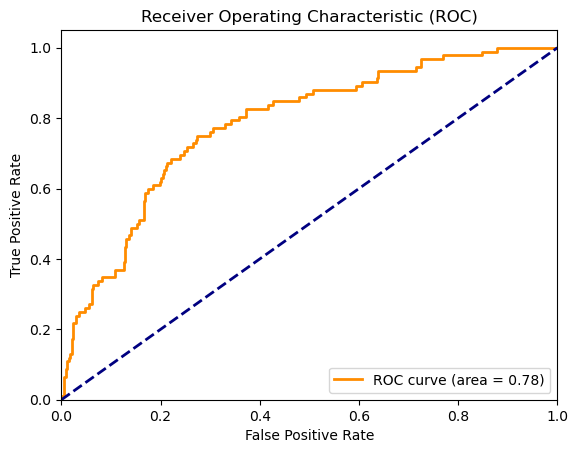

AUC Score:  0.7835276967930028


In [82]:
plot_roc_auc(rf_opt_2_smote, X_train_smote_rf_selected, y_train_smote)
plot_roc_auc(rf_opt_2_smote, X_valid_rf_selected, y_valid)

## SVM

In [83]:
# svm_clf = SVC(probability=True, random_state=42)

# class_weights = [{0:x, 1:1.0-x} for x in np.linspace(0.001,0.5,5)]

# param_grid = [{'kernel': ['poly'], 
#                'degree': [2, 3], 
#                'gamma': [1, 0.01, 0.0001], 
#                'C': [0.1, 1, 10],
#                'class_weight': ['balanced'] + class_weights},
                  
#               {'kernel': ['rbf','sigmoid'],
#                'gamma': [1, 0.01, 0.0001], 
#                'C': [0.1, 1, 10],
#                'class_weight': ['balanced'] + class_weights},
                  
#               {'kernel': ['linear'],
#                'C': [0.1, 1, 10],
#                'class_weight': ['balanced'] + class_weights}
#              ]

# grid_search_svm_clf = GridSearchCV(svm_clf, param_grid, scoring='roc_auc', cv=5, verbose=1, n_jobs=-1)

# grid_search_svm_clf.fit(X_train_scaled, y_train)

# # Get the best parameters
# print("Best parameters found: ", grid_search_svm_clf.best_params_)

Fitting 5 folds for each of 234 candidates, totalling 1170 fits
Best parameters found:  {'C': 10, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}

In [84]:
params_opt_svm_clf = {'C': 10, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
svm_clf_opt = SVC(**params_opt_svm_clf, probability=True, random_state=42)
svm_clf_opt.fit(X_train_scaled, y_train)

SVC(C=10, class_weight='balanced', gamma=1, probability=True, random_state=42)

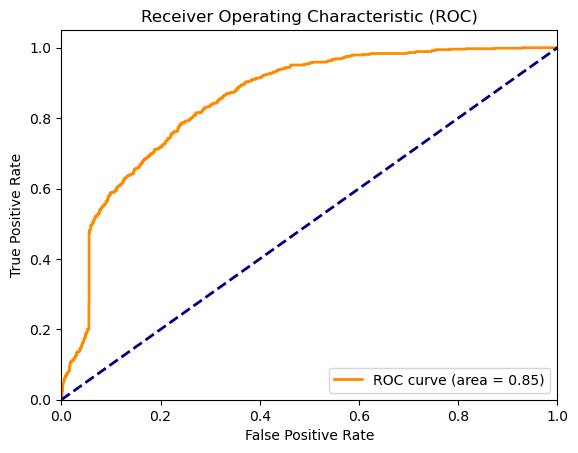

AUC Score:  0.8500335678099643


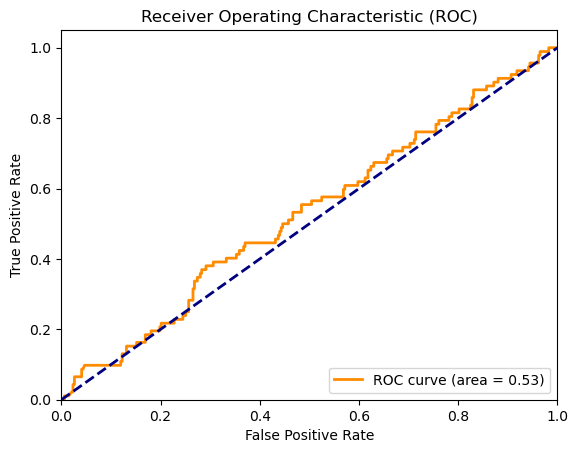

AUC Score:  0.5274908099885917


In [85]:
plot_roc_auc(svm_clf_opt, X_train_scaled, y_train)
plot_roc_auc(svm_clf_opt, X_valid_scaled, y_valid)

# Model Decision

In [86]:
def find_optimal_threshold_f1(model, X, Y):
    y_probs = model.predict_proba(X)[:, 1]

    thresholds = np.linspace(0.01, 1, 1000)

    f1_scores = [f1_score(Y, y_probs >= thr) for thr in thresholds]

    optimal_threshold = thresholds[np.argmax(f1_scores)]
    
    return optimal_threshold

Let's proceed with the evaluation of the best models from XGBoost, XGBoost Random Forest, and Random Forest, utilizing the optimal thresholds. This comparative analysis will assist us in determining the most robust and reliable model for our final implementation.

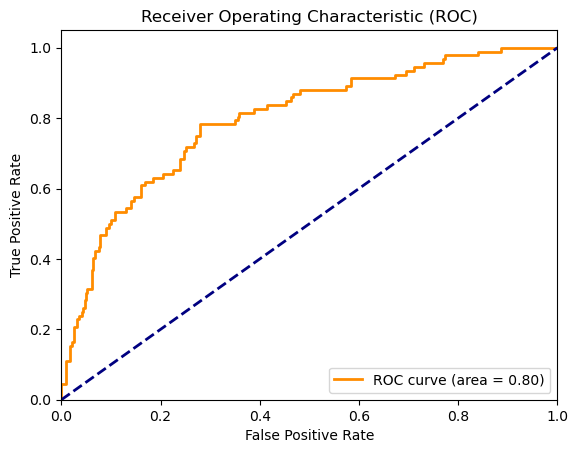

AUC Score:  0.7968056787932565


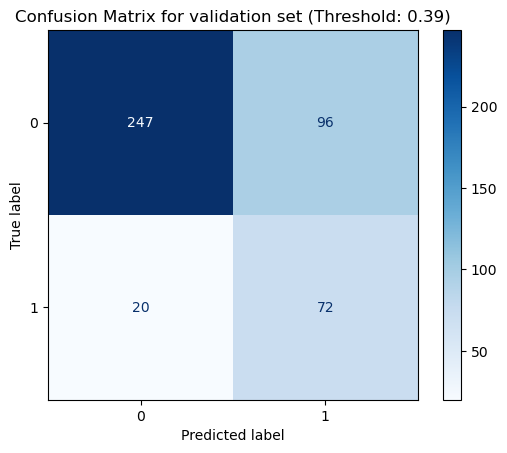

Classification report for validation set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       343
           1       0.43      0.78      0.55        92

    accuracy                           0.73       435
   macro avg       0.68      0.75      0.68       435
weighted avg       0.82      0.73      0.76       435



In [87]:
optimal_threshold = find_optimal_threshold_f1(xgb_opt_2, X_valid_xgb_selected, y_valid)
plot_roc_auc(xgb_opt_2, X_valid_xgb_selected, y_valid)
evaluate_and_plot_cm(xgb_opt_2, X_valid_xgb_selected, y_valid, 'validation', optimal_threshold)

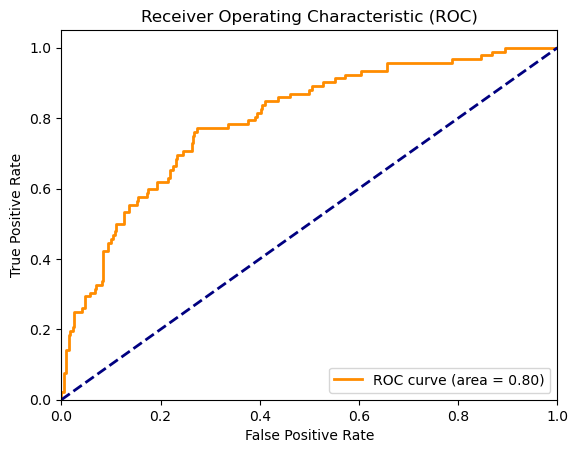

AUC Score:  0.7954430219292685


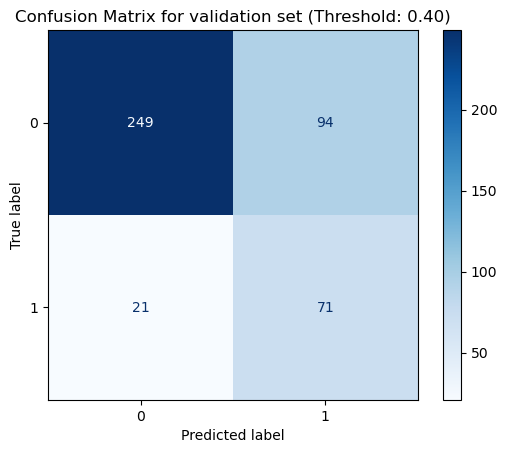

Classification report for validation set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.73      0.81       343
           1       0.43      0.77      0.55        92

    accuracy                           0.74       435
   macro avg       0.68      0.75      0.68       435
weighted avg       0.82      0.74      0.76       435



In [88]:
optimal_threshold = find_optimal_threshold_f1(xgbrf_opt_2, X_valid_xgbrf_selected, y_valid)
plot_roc_auc(xgbrf_opt_2, X_valid_xgbrf_selected, y_valid)
evaluate_and_plot_cm(xgbrf_opt_2, X_valid_xgbrf_selected, y_valid, 'validation', optimal_threshold)

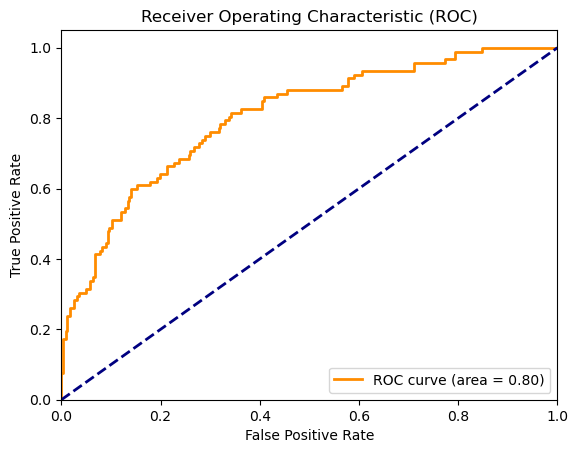

AUC Score:  0.8047281024210925


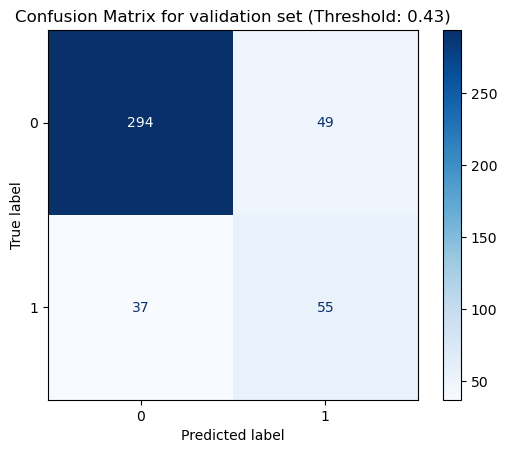

Classification report for validation set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.86      0.87       343
           1       0.53      0.60      0.56        92

    accuracy                           0.80       435
   macro avg       0.71      0.73      0.72       435
weighted avg       0.81      0.80      0.81       435



In [89]:
optimal_threshold = find_optimal_threshold_f1(rf_opt_2, X_valid_rf_selected, y_valid)
plot_roc_auc(rf_opt_2, X_valid_rf_selected, y_valid)
evaluate_and_plot_cm(rf_opt_2, X_valid_rf_selected, y_valid, 'validation', optimal_threshold)

Based on the evaluation metrics from the validation set, which include the confusion matrix, F1-score, accuracy, and ROC_AUC score, it is clear that the Random Forest model outperforms the others. Hence, I've selected the Random Forest model as my final choice. Now, let's evaluate the performance of this model on the test set for a comprehensive understanding of its predictive capability

## Test Set Evaluation of Random Forest Model

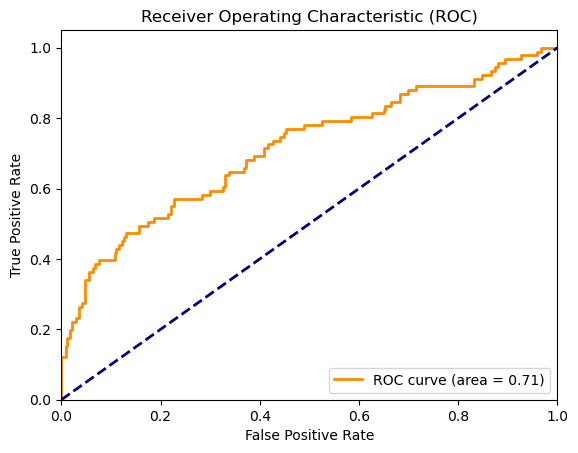

AUC Score:  0.7131964245666869


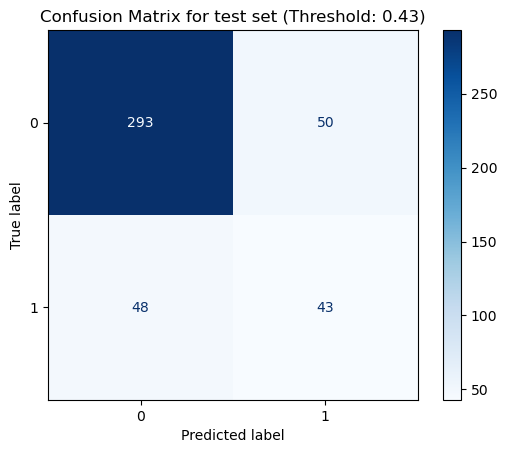

Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       343
           1       0.46      0.47      0.47        91

    accuracy                           0.77       434
   macro avg       0.66      0.66      0.66       434
weighted avg       0.78      0.77      0.78       434



In [90]:
plot_roc_auc(rf_opt_2, X_test_rf_selected, y_test)
evaluate_and_plot_cm(rf_opt_2, X_test_rf_selected, y_test, 'test', 0.43)

As we've observed, there is a significant drop in the ROC_AUC score and F1 score when transitioning from the validation set to the test set. However, this could potentially be attributed to the extremely limited amount of data at our disposal. Therefore, to obtain a more reliable assessment of the model's performance, I will apply cross-validation to the entire dataset and examine the average ROC_AUC score. As for the confusion matrix, given its complexity and the volume of information it provides, I will focus solely on the ROC_AUC score for the cross-validation set.

In [91]:
X = df_player[rf_selected]
y = df_player['INJURY']

In [92]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(rf_opt_2, X, y, cv=skf, scoring='roc_auc')

print('Cross-validation scores:', scores)
print('Average cross-validation score:', scores.mean())

Cross-validation scores: [0.73376985 0.74318533 0.77313642 0.75661553 0.74537912]
Average cross-validation score: 0.7504172511583139


# Model Conclusion

The average cross-validation score for our model is 0.75. This value is midway between the scores obtained on the validation and test sets, and thus appears reasonable. This leads us to conclude that the roc_auc score of our model is approximately **0.75**.

However, given the imperfect nature of our model, we should approach the interpretation of its results with care. Using only precision and accuracy may not provide a comprehensive view of our model's performance. Therefore, I propose a different approach: setting various thresholds to categorize players into distinct injury risk levels. This method could provide a more useful and contextually appropriate interpretation of our model's results

# Model Application

In the subsequent sections, I will apply three thresholds (0.25, 0.5, and 0.75) to divide the data into four risk regions: low, moderate, increased, and high risk. The actual risk of injury within each partition is estimated based on the precision in each corresponding range. For instance, if the average injury ratio in the low risk region is 0.23, then a player whose predicted probability falls within this region (say, 0.2) would have a 23% chance of getting injured. The same principle applies to the remaining risk levels.

Furthermore, despite the limited size of the cross-validation set (five folds), I will enhance the robustness of our model interpretation by calculating the average, standard deviation, and confidence interval for each risk leve

In [93]:
# List to hold injured ratios for each fold
injured_ratios = []

# Perform cross-validation on the whole dataset
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model on the training data
    rf_opt_2.fit(X_train, y_train)
    
    # Calculate probabilities for the label 1
    probs = rf_opt_2.predict_proba(X_test)[:, 1]

    # Create a new DataFrame for the output
    X_test_new = X_test.copy()

    # Create a new column based on the probabilities
    X_test_new['risk'] = pd.cut(probs,
                                bins=[0, 0.25, 0.50, 0.75, 1],
                                labels=['very low risk', 'moderate risk', 'increased risk', 'high risk'],
                                include_lowest=True)
    # Add y_test to the new DataFrame
    X_test_new['Injury'] = y_test

    # Calculate ratio of injured players in each risk level and append to list
    injured_ratio = X_test_new.groupby('risk')['Injury'].mean()
    injured_ratios.append(injured_ratio)

# Create DataFrame with injured ratios for each fold
injured_ratios_df = pd.concat(injured_ratios, axis=1)

# Calculate average injured ratio across all folds
average_injured_ratio = injured_ratios_df.mean(axis=1)

# Calculate standard deviation of injured ratio across all folds
std_injured_ratio = injured_ratios_df.std(axis=1)

print('Average injured ratio across all folds:')
print(average_injured_ratio)
print('\nStandard deviation of injured ratio across all folds:')
print(std_injured_ratio)

Average injured ratio across all folds:
risk
very low risk     0.089157
moderate risk     0.230045
increased risk    0.477567
high risk         0.933685
dtype: float64

Standard deviation of injured ratio across all folds:
risk
very low risk     0.016110
moderate risk     0.023722
increased risk    0.036245
high risk         0.061810
dtype: float64


In [94]:
injured_ratios 

[risk
 very low risk     0.082474
 moderate risk     0.255682
 increased risk    0.435897
 high risk         0.833333
 Name: Injury, dtype: float64,
 risk
 very low risk     0.105528
 moderate risk     0.204082
 increased risk    0.508772
 high risk         0.928571
 Name: Injury, dtype: float64,
 risk
 very low risk     0.067332
 moderate risk     0.252941
 increased risk    0.457143
 high risk         0.956522
 Name: Injury, dtype: float64,
 risk
 very low risk     0.085859
 moderate risk     0.227147
 increased risk    0.521739
 high risk         0.950000
 Name: Injury, dtype: float64,
 risk
 very low risk     0.104592
 moderate risk     0.210375
 increased risk    0.464286
 high risk         1.000000
 Name: Injury, dtype: float64]

In [95]:
# Calculate standard error
stderr = pd.concat(injured_ratios, axis=1).std(axis=1)/np.sqrt(len(injured_ratios))

# Calculate the 95% confidence intervals
confidence_interval = stderr.apply(lambda x: x * stats.t.ppf((1 + 0.95) / 2., len(injured_ratios)-1))

# Print the lower and upper bounds of the confidence intervals
lower_bound = average_injured_ratio - confidence_interval
upper_bound = average_injured_ratio + confidence_interval

print('Lower bounds of the 95% confidence intervals:')
print(lower_bound)

print('Upper bounds of the 95% confidence intervals:')
print(upper_bound)


Lower bounds of the 95% confidence intervals:
risk
very low risk     0.069154
moderate risk     0.200591
increased risk    0.432563
high risk         0.856938
dtype: float64
Upper bounds of the 95% confidence intervals:
risk
very low risk     0.109160
moderate risk     0.259500
increased risk    0.522572
high risk         1.010433
dtype: float64


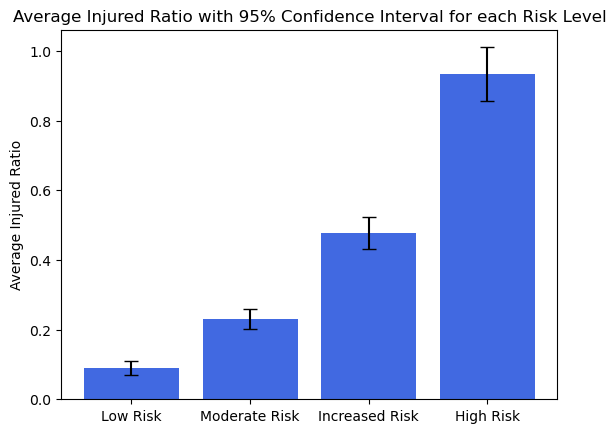

In [96]:
average_ratios = [0.089157, 0.230045, 0.477567, 0.933685]

conf_intervals = [(0.069154, 0.109160), (0.200591, 0.259500), (0.432563, 0.522572), (0.856938, 1.010433)]

yerr = [[average - lower for average, (lower, upper) in zip(average_ratios, conf_intervals)],
        [upper - average for average, (lower, upper) in zip(average_ratios, conf_intervals)]]

fig, ax = plt.subplots()

ax.bar(['Low Risk', 'Moderate Risk', 'Increased Risk', 'High Risk'], average_ratios, yerr=yerr, capsize=5)

ax.set_ylabel('Average Injured Ratio')
ax.set_title('Average Injured Ratio with 95% Confidence Interval for each Risk Level')

plt.show()


In [97]:
X

DIST_MILES    PACE  POSS  FRONT_CT_TOUCHES   MIN  FGA_PG  USG_PCT  \
1           0.74  102.85   651               7.3   9.4     3.4    0.160   
2           1.58  102.71  2749              14.2  19.4     7.4    0.174   
3           2.14  100.06  3828              23.3  30.1    11.0    0.206   
4           1.05  103.64  1680               8.0  13.7     3.5    0.128   
5           1.92  101.82  3441              19.9  24.6     8.0    0.170   
...          ...     ...   ...               ...   ...     ...      ...   
5573        1.13   98.46  1781              15.1  15.8     4.9    0.162   
5574        2.19   99.49  3996              29.1  31.1    11.9    0.193   
5575        1.57  101.48  1923              20.2  21.1     8.0    0.223   
5576        2.21   90.59  5113              39.0  34.2    15.2    0.258   
5577        1.65   94.26  2594              29.9  25.0     6.6    0.167   

      PAINT_TOUCHES  AVG_SPEED  AVG_DRIB_PER_TOUCH  
1               0.3       4.36                1.84  
2               0.7       4.56                1.49  
3               6.8       3.99                2.11  
4               0.4       4.28                3.82  
5               1.1       4.38                0.80  
...             ...        ...                 ...  
5573            0.5       4.32                1.84  
5574            1.7       4.24                1.26  
5575            1.2       4.49                2.45  
5576            9.5       3.88                0.81  
5577            6.3       3.94                0.54  

[4344 rows x 10 columns]

In [99]:
X.to_csv('X.csv')

In [100]:
rf_opt_2.predict_proba(X)

array([[0.90971731, 0.09028269],
       [0.64572142, 0.35427858],
       [0.27563683, 0.72436317],
       ...,
       [0.72350066, 0.27649934],
       [0.75410491, 0.24589509],
       [0.85031188, 0.14968812]])